In [1]:
import gym
import random
import numpy as np
import tensorflow as tf

from collections import deque

from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)
random.seed(seed)

# Helper Function

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# EFFICIENT REPLAY MEMORY

In [3]:
class PrioritizedReplayMemory: #PER memory
    def __init__(self, memory_size=10000, per_alpha=0.2, per_beta0=0.4):       
        self.memory = SumTree(capacity=memory_size) # Use sumtree
        self.memory_size = memory_size
       
        # hyperparameter for importance probability
        self.per_alpha = per_alpha
        
        # hyperparameter for importance weight
        self.per_beta0 = per_beta0
        self.per_beta = per_beta0
        
        self.per_epsilon = 1E-6
        self.prio_max = 0
    
    def anneal_per_importance_sampling(self, step, max_step): # Anneal beta
        self.per_beta = self.per_beta0 + step*(1-self.per_beta0)/max_step

    def error2priority(self, errors): # Get priority from TD error
        return np.power(np.abs(errors) + self.per_epsilon, self.per_alpha)

    def save_experience(self, state, action, reward, state_next, done):
        experience = (state, action, reward, state_next, done)
        self.memory.add(np.max([self.prio_max, self.per_epsilon]), experience) # Add experience with importance weight
        
    def retrieve_experience(self, batch_size):
        idx = None
        priorities = None
        w = None

        idx, priorities, experience = self.memory.sample(batch_size) # Sample batch from memory
        sampling_probabilities = priorities / self.memory.total() # Make priorities to be sum to one
        w = np.power(self.memory.n_entries * sampling_probabilities, -self.per_beta) # Importance weight
        w = w / w.max()
        return idx, priorities, w, experience
    
    def update_experience_weight(self, idx, errors ):
        priorities = self.error2priority(errors)
        for i in range(len(idx)):
            self.memory.update(idx[i], priorities[i])
        self.prio_max = max(priorities.max(), self.prio_max)
        
class SumTree: # Sum Tree Memory
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.tree = np.zeros(2*capacity - 1)
        self.data = np.zeros(capacity, dtype=object)

        self.write = 0
        self.n_entries = 0

        self.tree_len = len(self.tree)

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1

        if left >= self.tree_len:
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            right = left + 1
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1

        return idx, self.tree[idx], self.data[data_idx]

    def sample(self, batch_size):
        batch_idx = [None] * batch_size
        batch_priorities = [None] * batch_size
        batch = [None] * batch_size
        segment = self.total() / batch_size

        a = [segment*i for i in range(batch_size)]
        b = [segment * (i+1) for i in range(batch_size)]
        s = np.random.uniform(a, b)

        for i in range(batch_size):
            (batch_idx[i], batch_priorities[i], batch[i]) = self.get(s[i])

        return batch_idx, batch_priorities, batch

# Deep Q Learning with PER

In [4]:
class DQNPERAgent:
    def __init__(self, obs_dim, n_action, seed=0,
                 discount_factor = 0.995, epsilon_decay = 0.999, epsilon_min = 0.01,
                 learning_rate = 1e-3, # STEP SIZE
                 batch_size = 64, 
                 memory_size = 2000, hidden_unit_size = 64):
        
        self.seed = seed 
        self.obs_dim = obs_dim
        self.n_action = n_action

        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.train_start = 1000

        self.memory = PrioritizedReplayMemory(memory_size=memory_size)
            
        self.hidden_unit_size = hidden_unit_size
        
        self.g = tf.Graph()
        with self.g.as_default():
            self.build_placeholders()
            self.build_model()
            self.build_loss()
            self.build_update_operation()
            self.init_session()        
    
    def build_placeholders(self):
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.target_ph = tf.placeholder(tf.float32, (None, self.n_action), 'target')
        self.batch_weights_ph = tf.placeholder(tf.float32,(None, self.n_action), name="batch_weights")
        self.learning_rate_ph = tf.placeholder(tf.float32, (), 'lr')        
    
    def build_model(self): # Build networks
        hid1_size = self.hidden_unit_size
        hid2_size = self.hidden_unit_size
        
        with tf.variable_scope('q_prediction'): # Prediction Network / Two layered perceptron / Training Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
                        
        with tf.variable_scope('q_target'): # Target Network / Two layered perceptron / Old Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict_old = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
        
        self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction') # Get Prediction network's Parameters
        self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target') # Get Target network's Parameters

    def build_loss(self):
        self.errors = self.target_ph - self.q_predict
        self.loss = 0.5*tf.reduce_mean(tf.square(self.target_ph - self.q_predict))
        self.optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph).minimize(self.loss)
            
    def build_update_operation(self):
        update_ops = []
        for var, var_old in zip(self.weights, self.weights_old):
            update_ops.append(var_old.assign(var))
        self.update_ops = update_ops
        
    def init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.update_ops)
        
    def update_target(self):
        self.sess.run(self.update_ops)
    
    def update_memory(self, step, max_step):
        self.memory.anneal_per_importance_sampling(step,max_step)
        
    def update_policy(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
    def get_prediction_old(self, obs): 
        q_value_old = self.sess.run(self.q_predict_old,feed_dict={self.obs_ph:obs})        
        return q_value_old
        
    def get_prediction(self, obs):        
        q_value = self.sess.run(self.q_predict,feed_dict={self.obs_ph:obs})        
        return q_value
    
    def get_action(self, obs):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_action)
        else:
            q_value = self.get_prediction([obs])
            return np.argmax(q_value[0])

    def add_experience(self, obs, action, reward, next_obs, done):
        self.memory.save_experience(obs, action, reward, next_obs, done)

    def train_model(self):
        loss = np.nan
        
        n_entries = self.memory.memory.n_entries
            
        if n_entries > self.train_start:
            
            # PRIORITIZED EXPERIENCE REPLAY
            idx, priorities, w, mini_batch = self.memory.retrieve_experience(self.batch_size)
            batch_weights = np.transpose(np.tile(w, (self.n_action, 1)))
            
            observations = np.zeros((self.batch_size, self.obs_dim))
            next_observations = np.zeros((self.batch_size, self.obs_dim))
            actions, rewards, dones = [], [], []

            for i in range(self.batch_size):
                observations[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                next_observations[i] = mini_batch[i][3]
                dones.append(mini_batch[i][4])

            target = self.get_prediction(observations)
            next_q_value = self.get_prediction_old(next_observations)

            # BELLMAN UPDATE RULE 
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(next_q_value[i]))

            loss, errors, _ = self.sess.run([self.loss, self.errors, self.optim], 
                                 feed_dict={self.obs_ph:observations,self.target_ph:target,self.learning_rate_ph:self.learning_rate,self.batch_weights_ph:batch_weights})
            errors = errors[np.arange(len(errors)), actions]
            
            self.memory.update_experience_weight(idx, errors)
            
        return loss

# DEFINE ENVIRONMENT AND AGENT

In [5]:
env = gym.make('CartPole-v1')
obs_space = env.observation_space
print('Observation space')
print(type(obs_space))
print(obs_space.shape)
print("Dimension:{}".format(obs_space.shape[0]))
print("High: {}".format(obs_space.high))
print("Low: {}".format(obs_space.low))
print()

act_space = env.action_space
print('Action space')
print(type(act_space))
print("Total {} actions".format(act_space.n))
print()

env.seed(seed)
max_t = env.spec.max_episode_steps
agent = DQNPERAgent(env.observation_space.high.shape[0],env.action_space.n)

[2018-05-19 03:47:20,066] Making new env: CartPole-v1


Observation space
<class 'gym.spaces.box.Box'>
(4,)
Dimension:4
High: [4.80000000e+00 3.40282347e+38 4.18879020e-01 3.40282347e+38]
Low: [-4.80000000e+00 -3.40282347e+38 -4.18879020e-01 -3.40282347e+38]

Action space
<class 'gym.spaces.discrete.Discrete'>
Total 2 actions



# TRAIN

In [6]:
avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)
nepisodes = 1500
for i in range(nepisodes):
    obs = env.reset()
    done = False
    total_reward = 0
    total_loss = 0
    for t in range(max_t):
        # Get transition
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)
        
        # Add experience
        agent.add_experience(obs,action,reward,next_obs,done)
        
        # Online update perdiction network parameter
        loss = agent.train_model()
        agent.update_policy()
                
        obs = next_obs
        total_reward += reward
        total_loss += loss
        
        if done:
            break
    
    # Update target network parameter
    agent.update_target()
    avg_return_list.append(total_reward)
    avg_loss_list.append(total_loss)
    
    if (np.mean(avg_return_list) > 490): # Threshold return to success cartpole
        print('[{}/{}] loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i,nepisodes, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))
        print('The problem is solved with {} episodes'.format(i))
        break
    
    if (i%100)==0:
        print('[{}/{}] loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i,nepisodes, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))

[0/1500] loss : nan, return : 11.000, eps : 0.989
[100/1500] loss : 93.254, return : 40.300, eps : 0.092
[200/1500] loss : 202.348, return : 55.200, eps : 0.010
[300/1500] loss : 4040.058, return : 306.500, eps : 0.010
[353/1500] loss : 8625.709, return : 500.000, eps : 0.010
The problem is solved with 353 episodes


# TEST

[2018-05-19 03:49:57,587] Making new env: CartPole-v1


Total Reward : 500.00



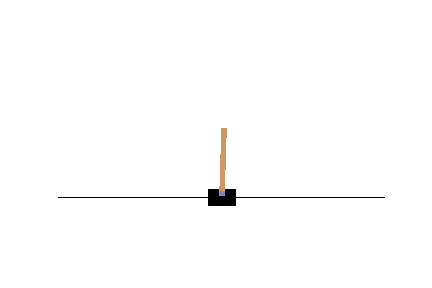
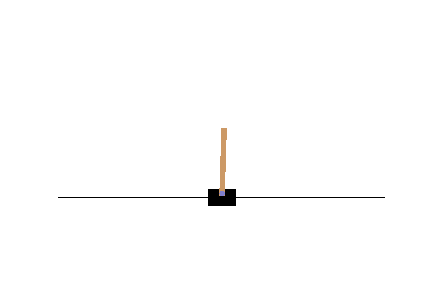
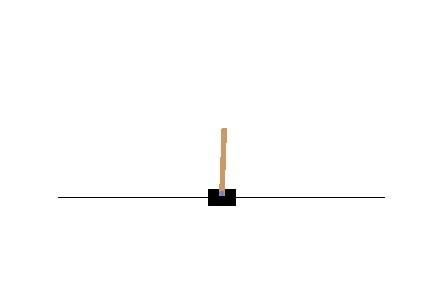
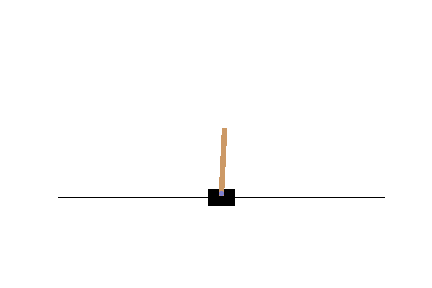
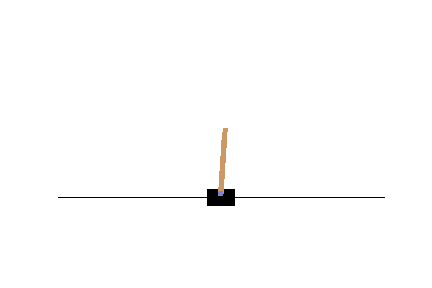
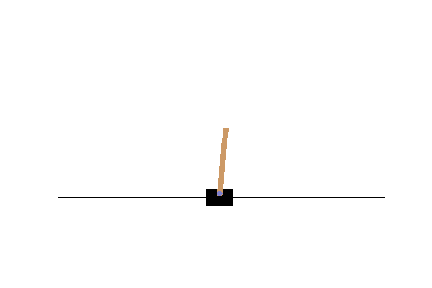
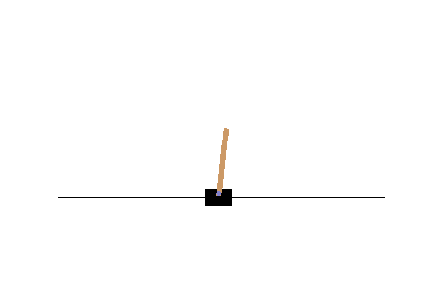
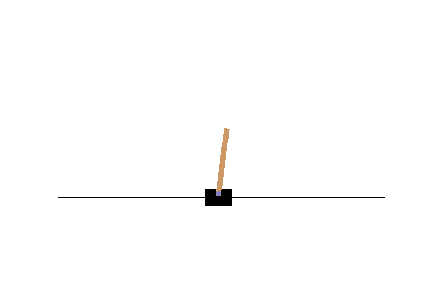
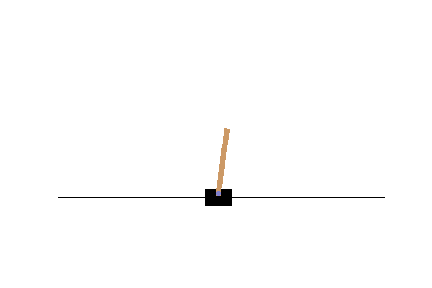
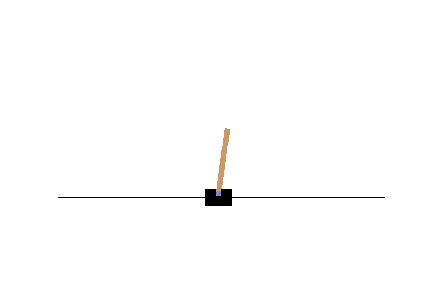
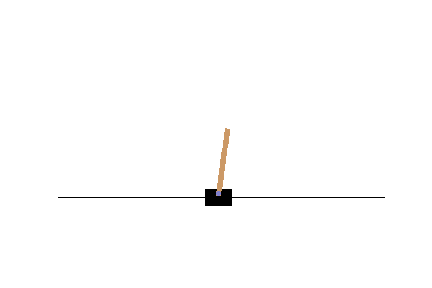
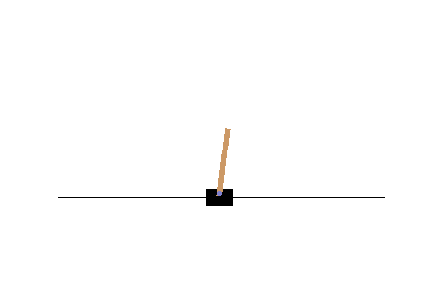
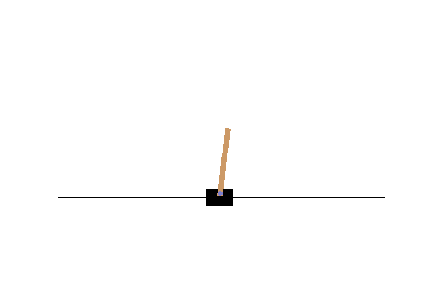
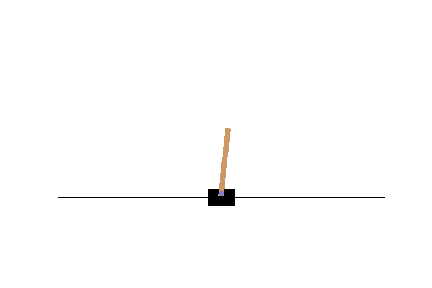
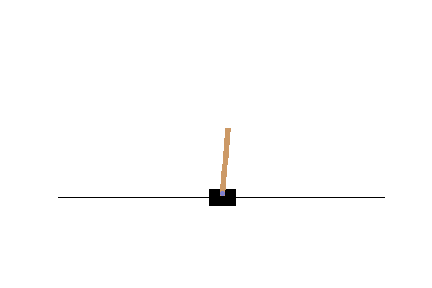
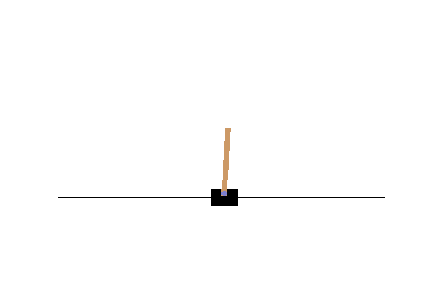
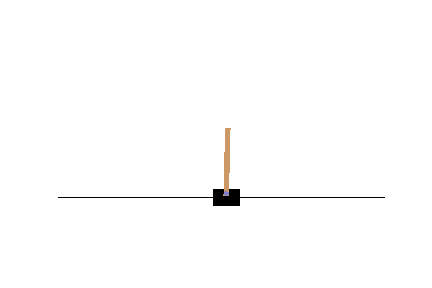
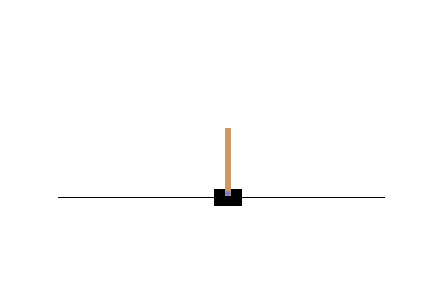
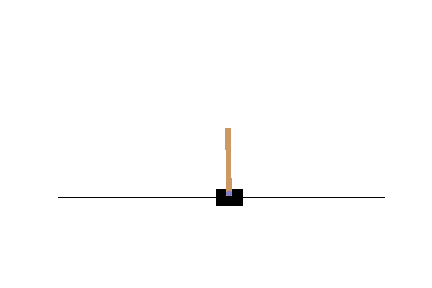
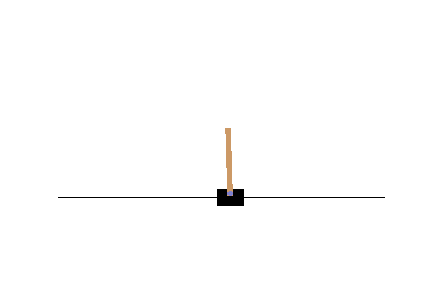
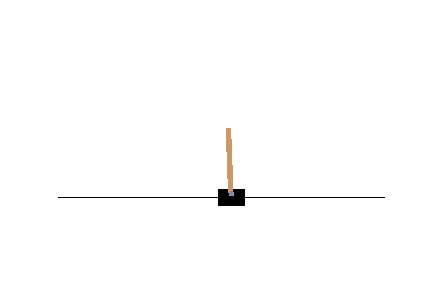
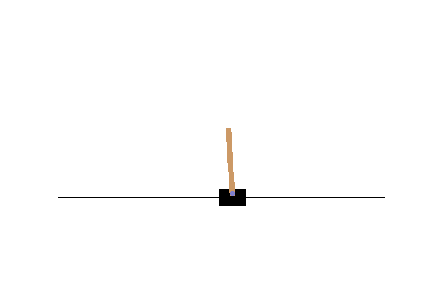
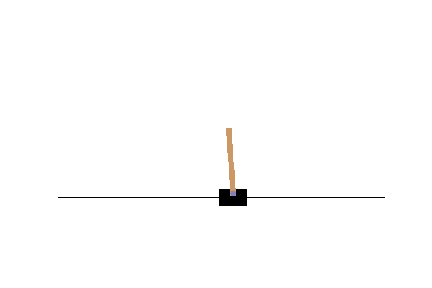
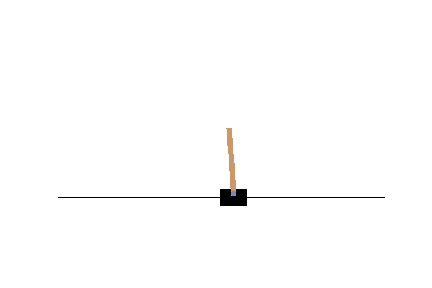
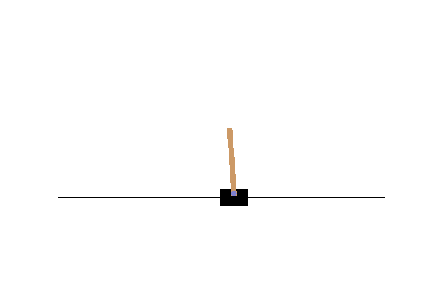
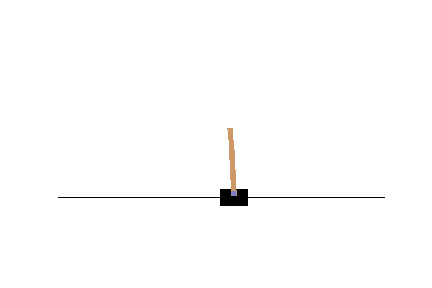
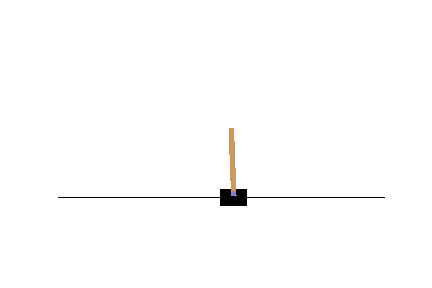
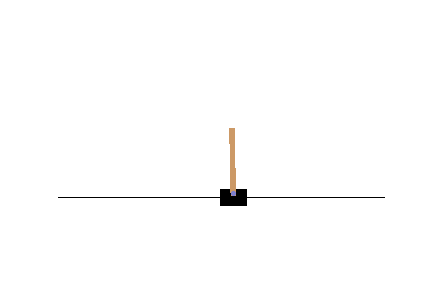
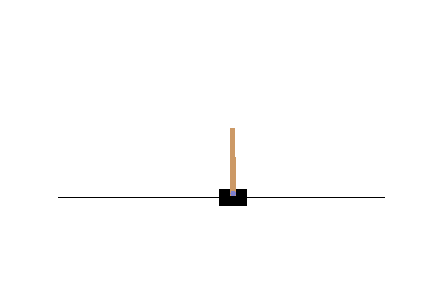
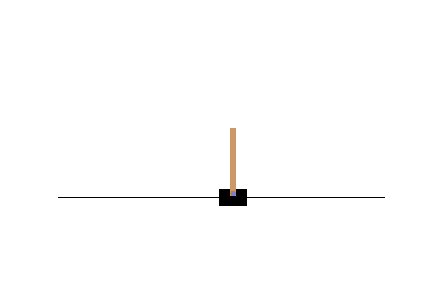
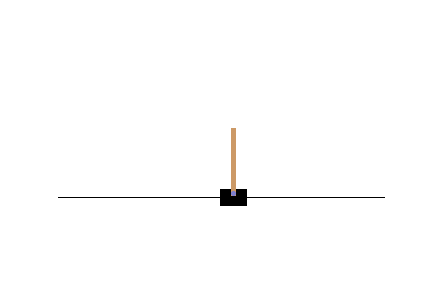
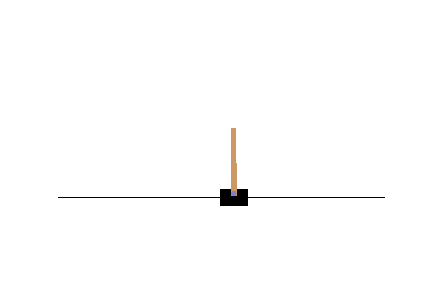
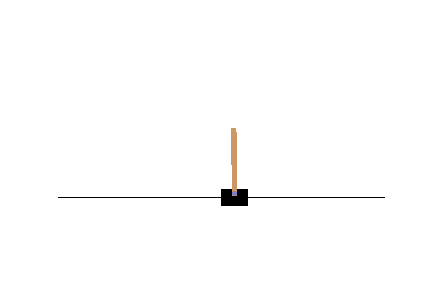
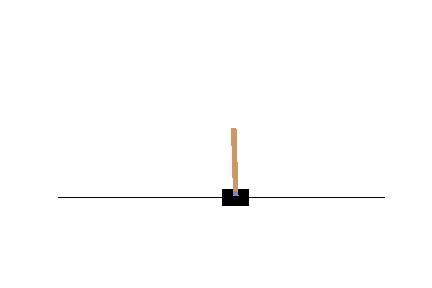
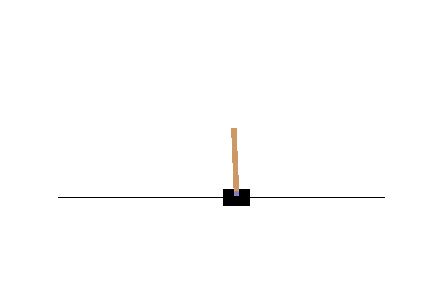
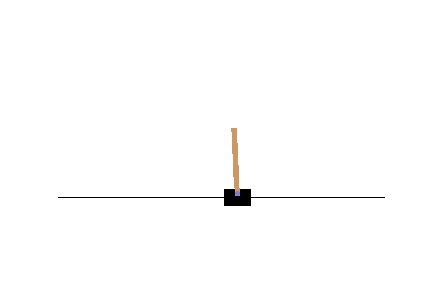
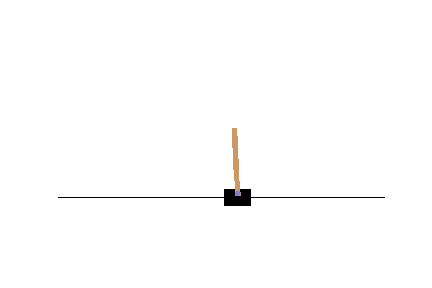
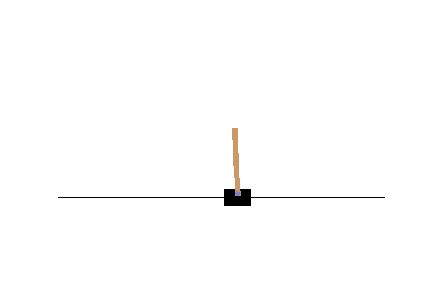
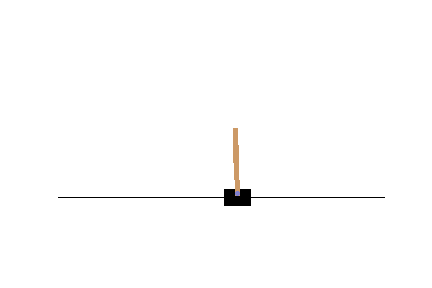
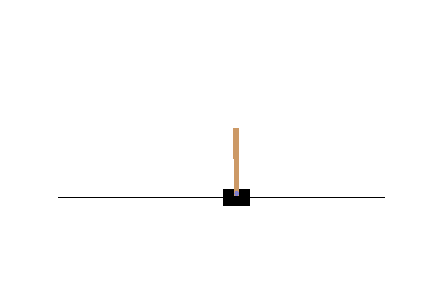
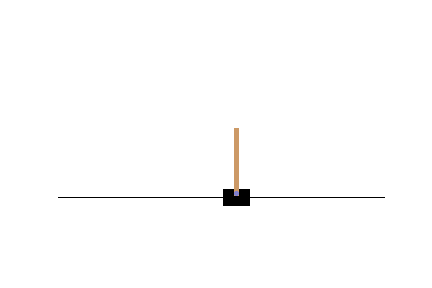
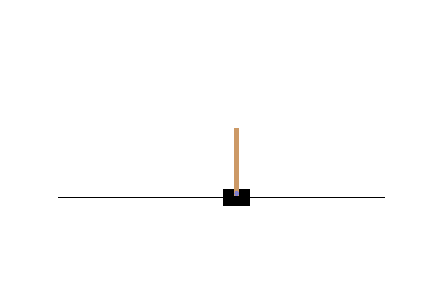
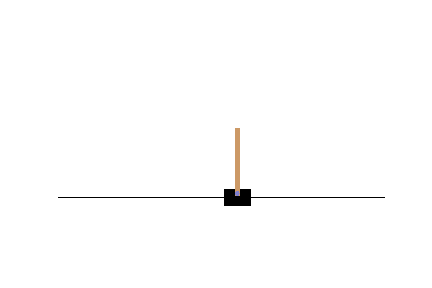
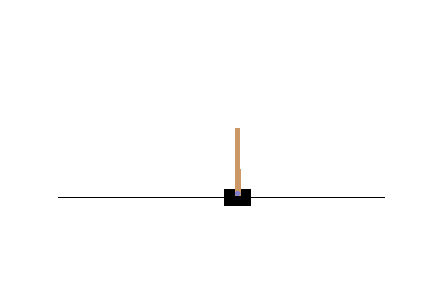
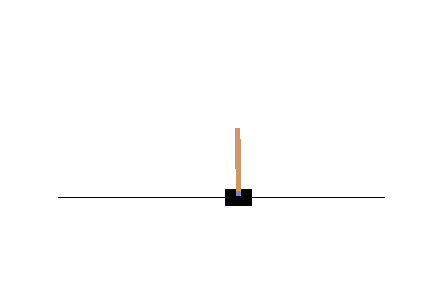
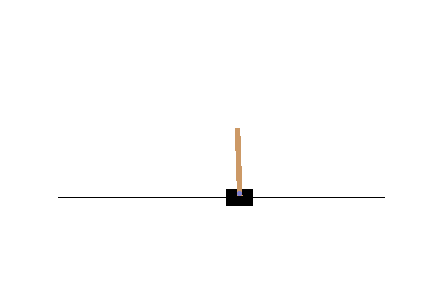
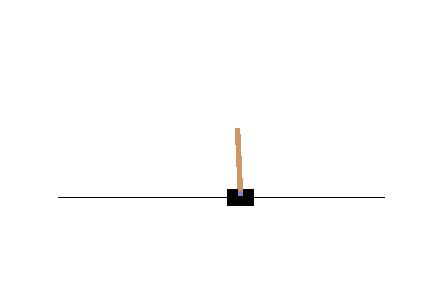
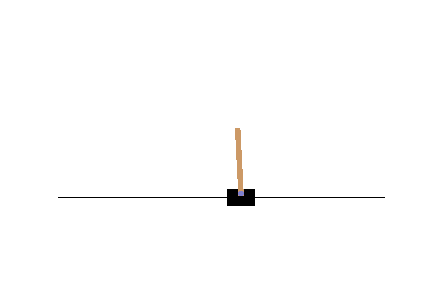
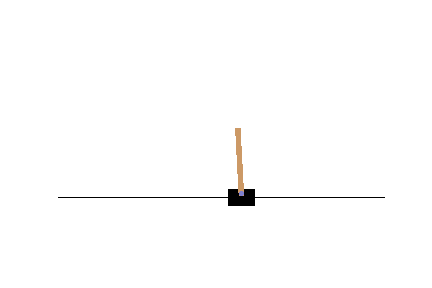
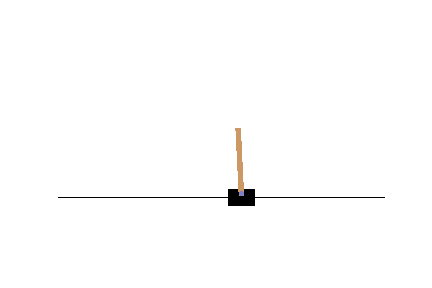
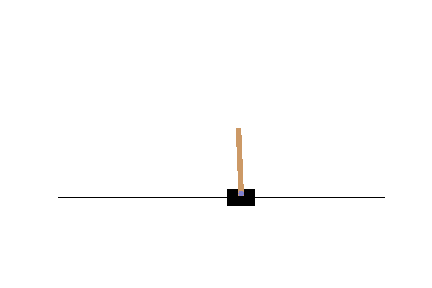
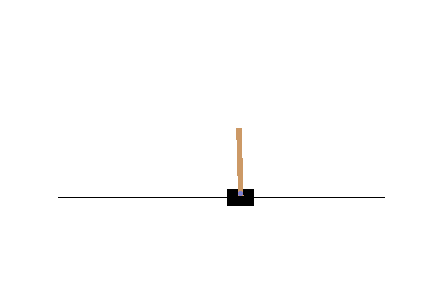
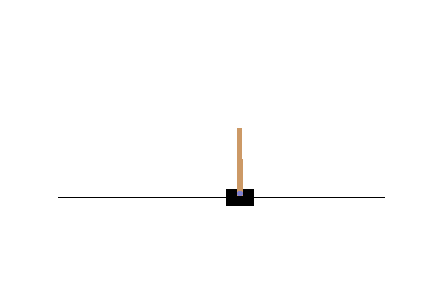
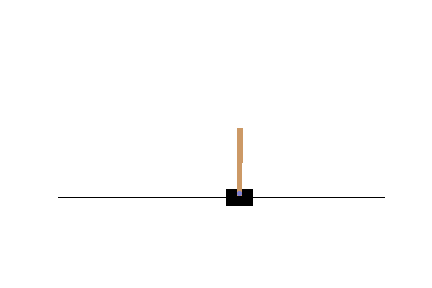
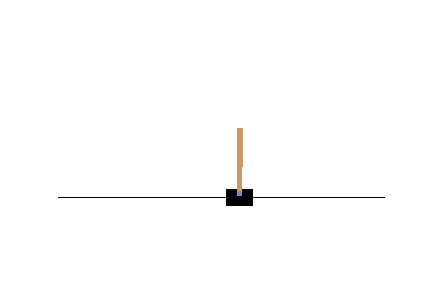
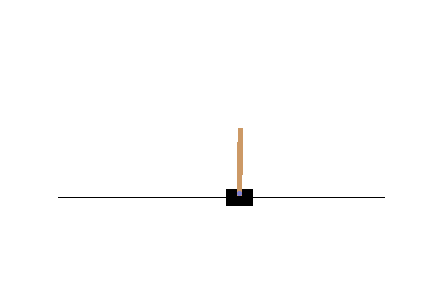
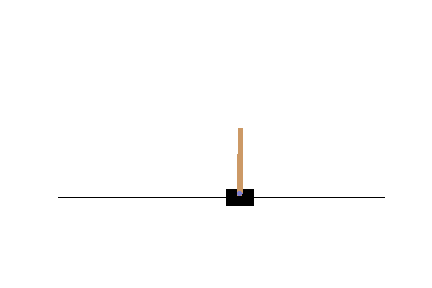
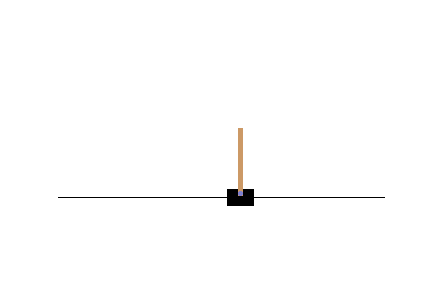
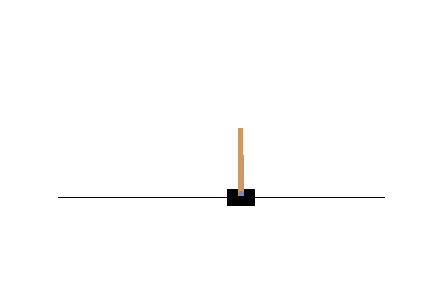
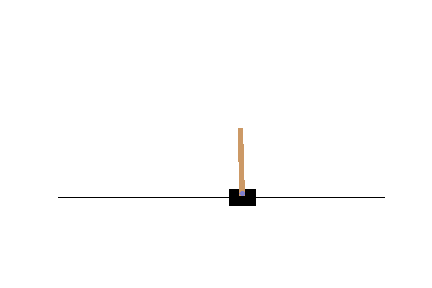
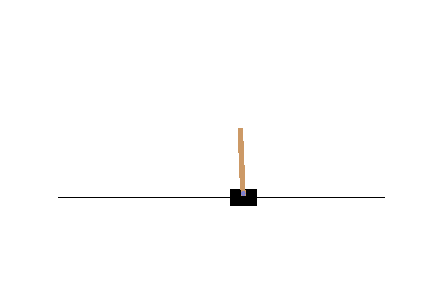
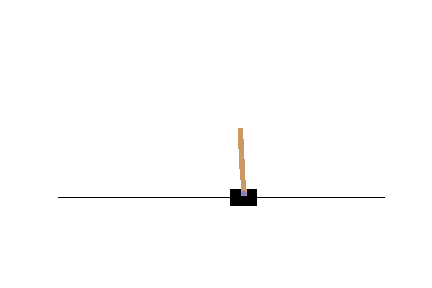
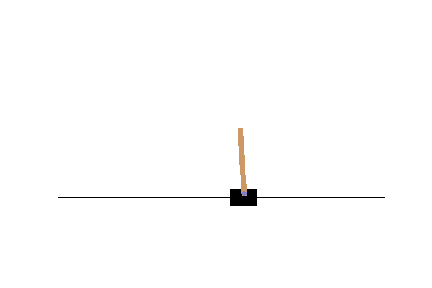
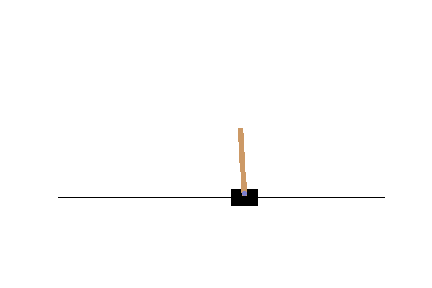
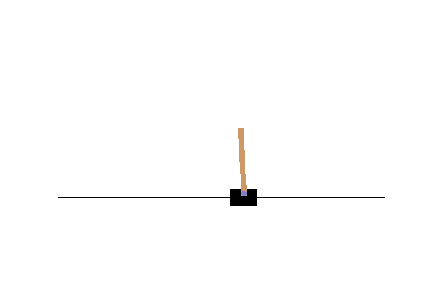
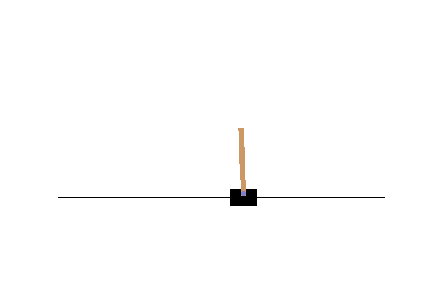
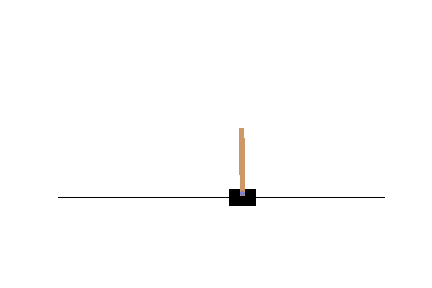
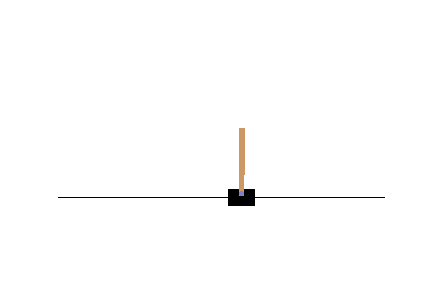
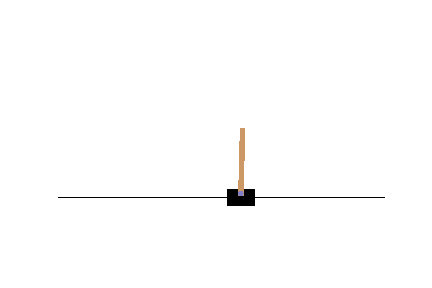
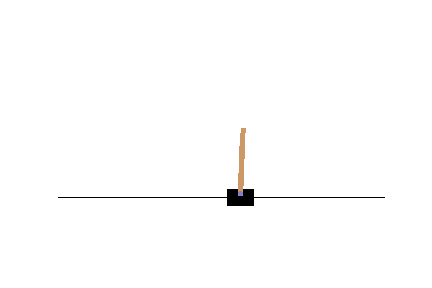
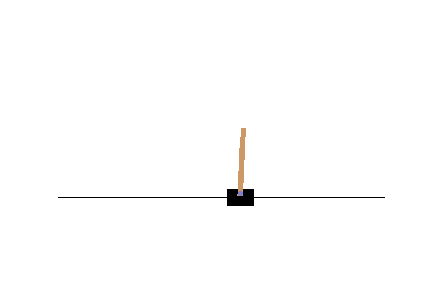
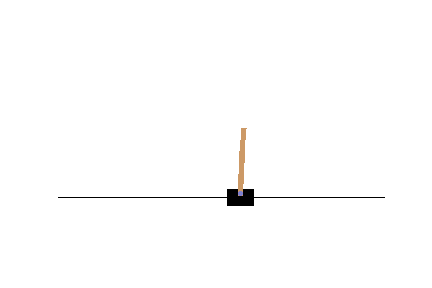
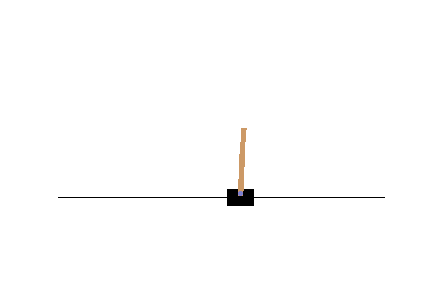
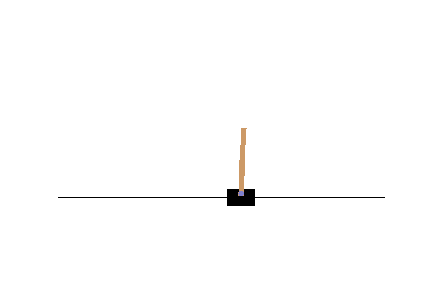
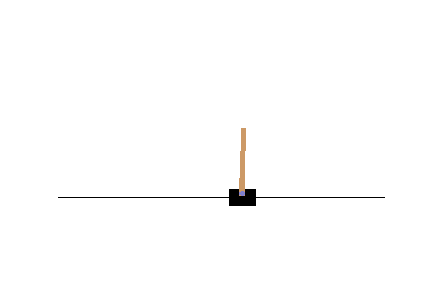
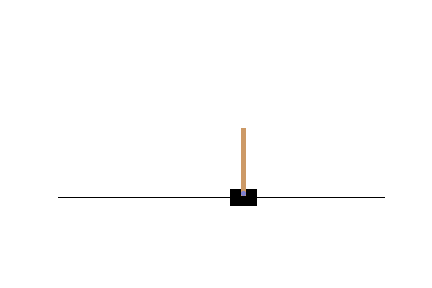
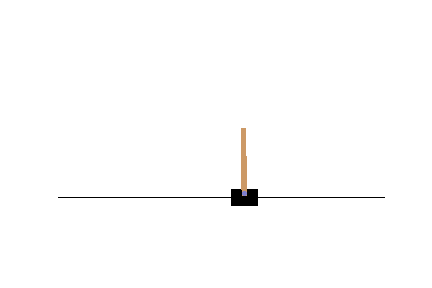
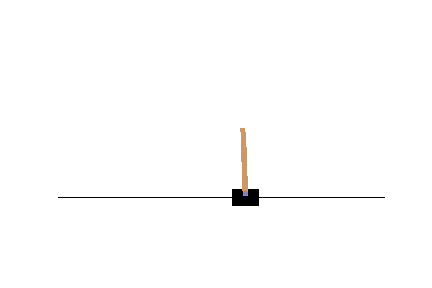
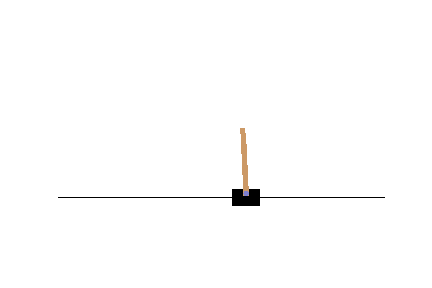
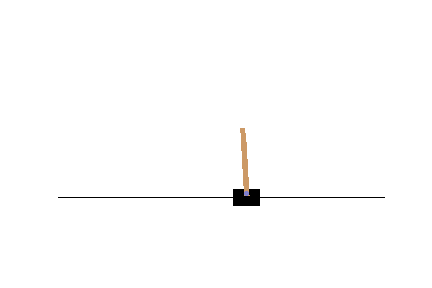
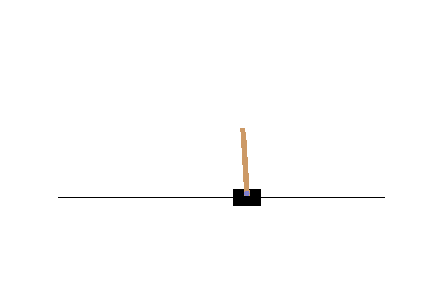
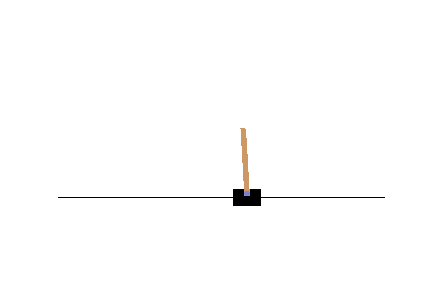
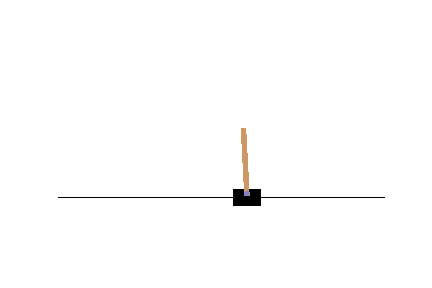
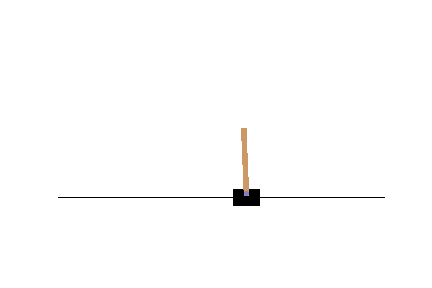
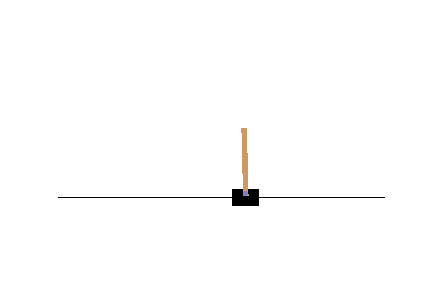
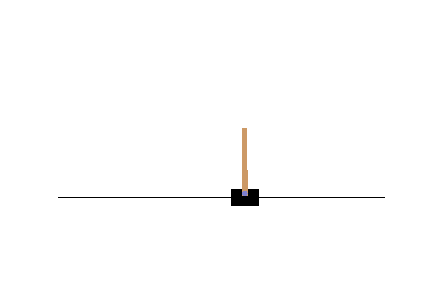
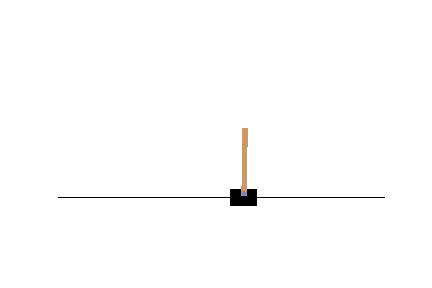
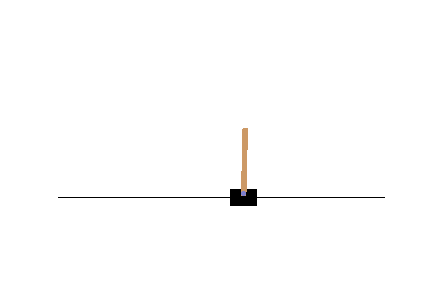
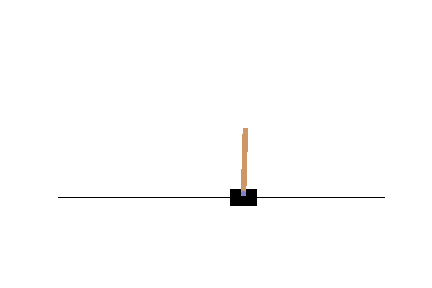
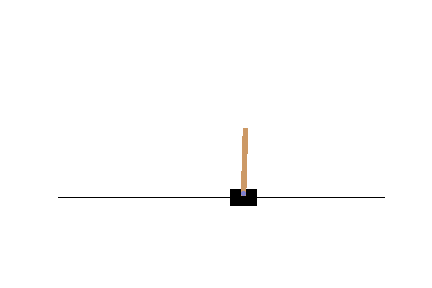
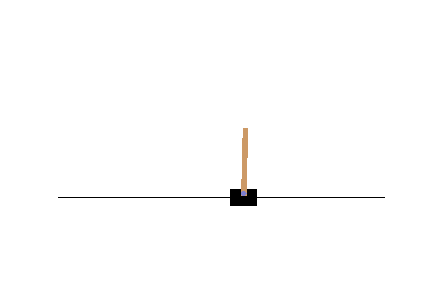
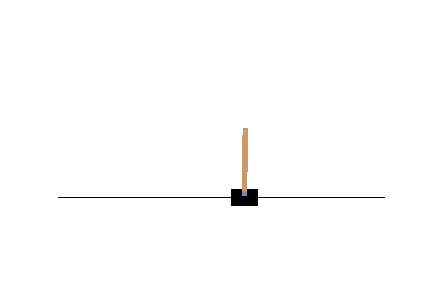
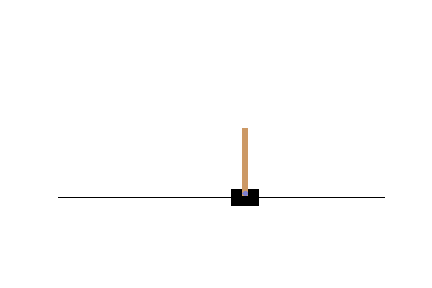
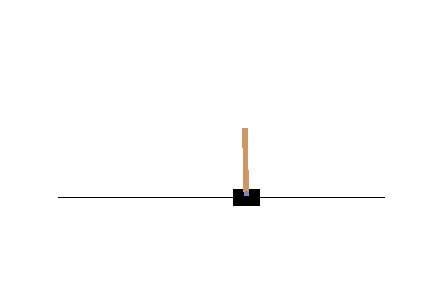
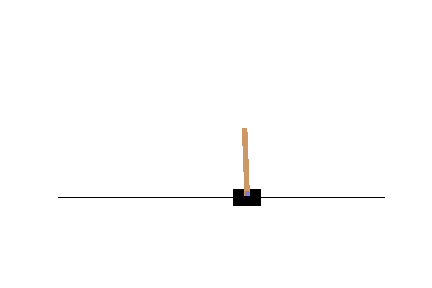
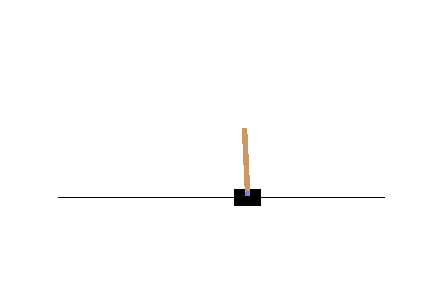
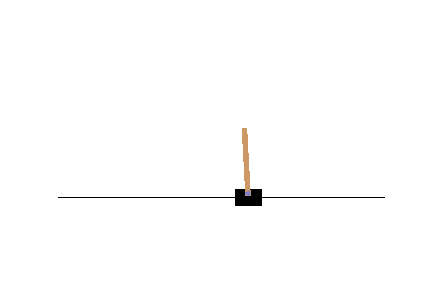
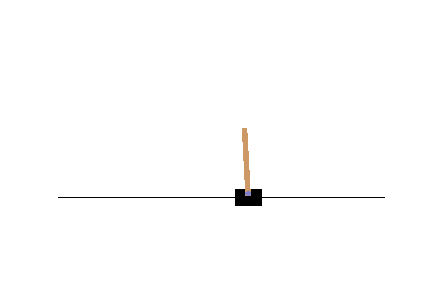
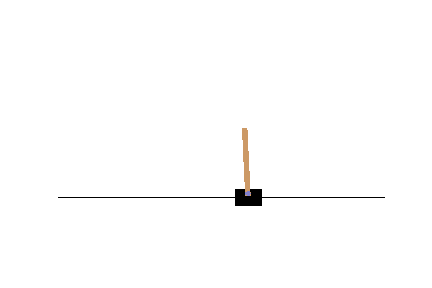
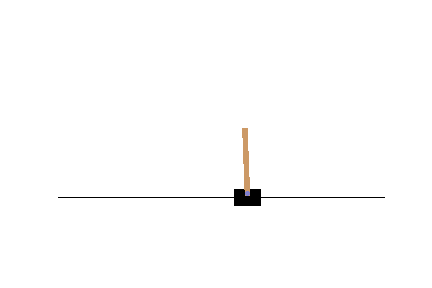
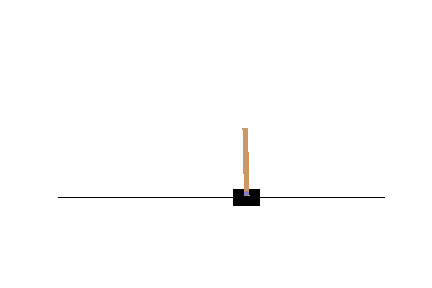
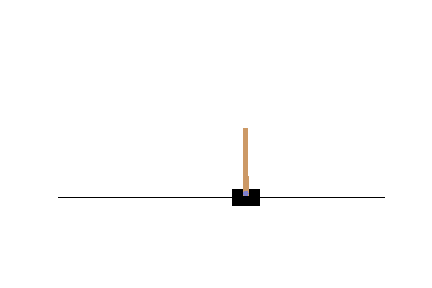
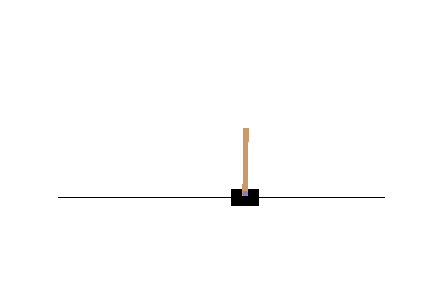
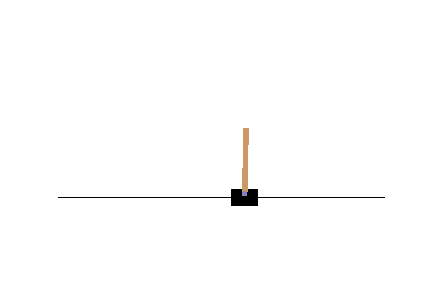
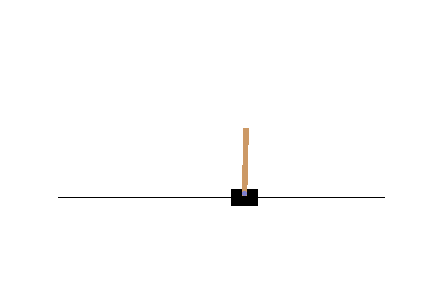
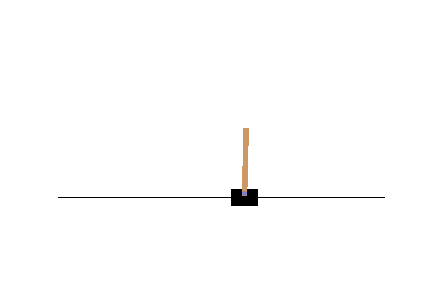
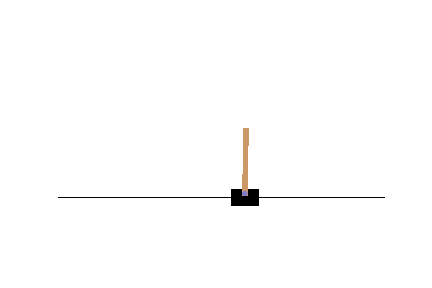
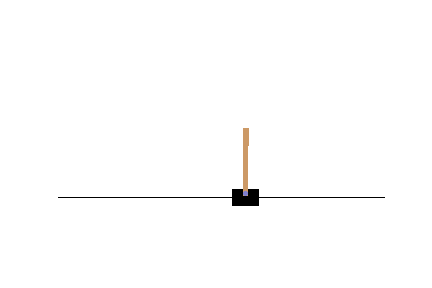
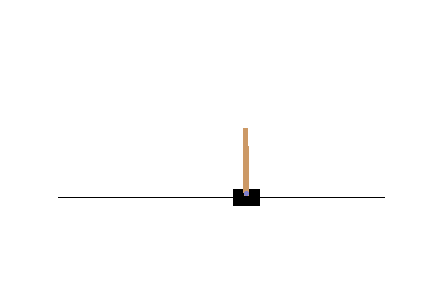
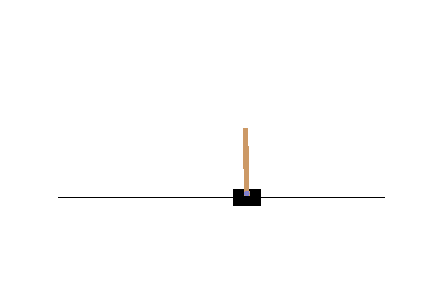
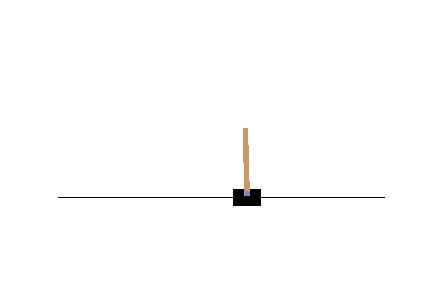
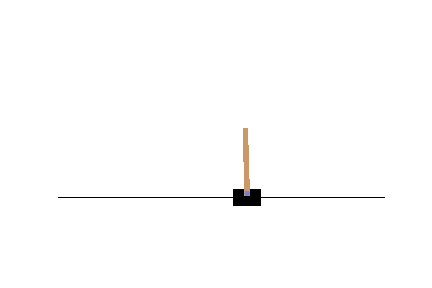
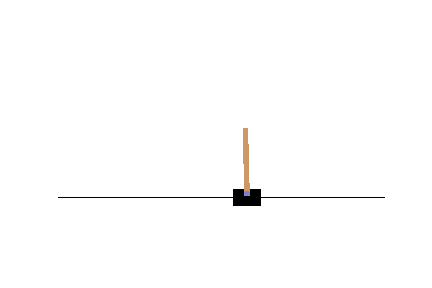
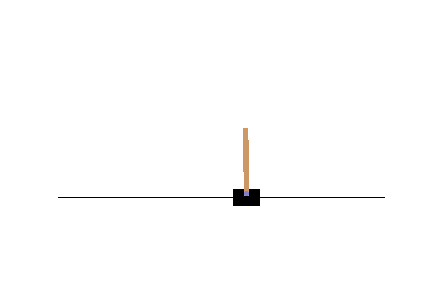
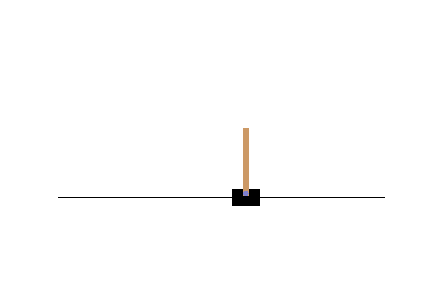
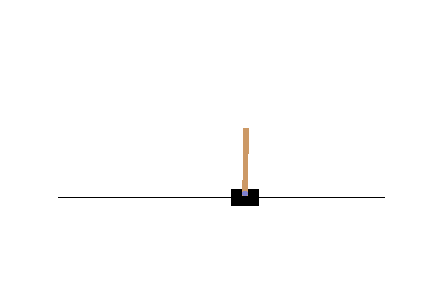
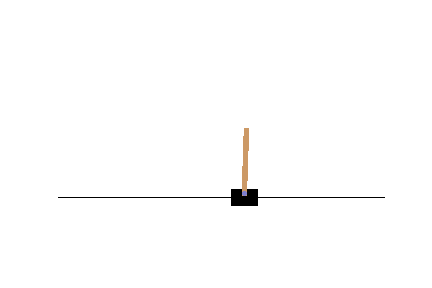
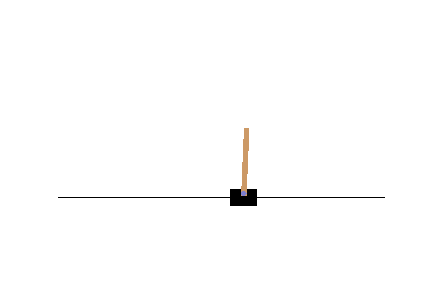
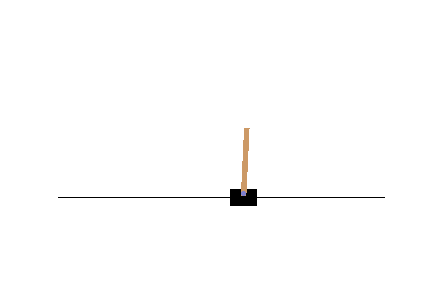
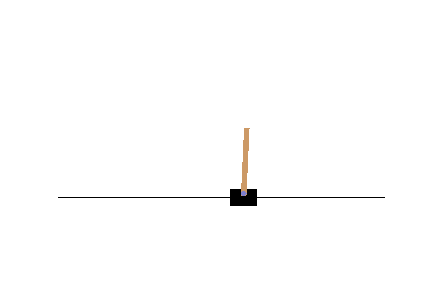
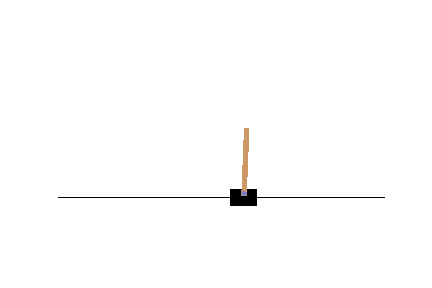
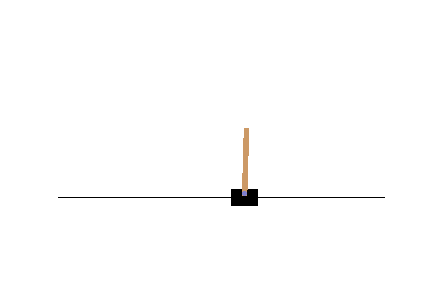
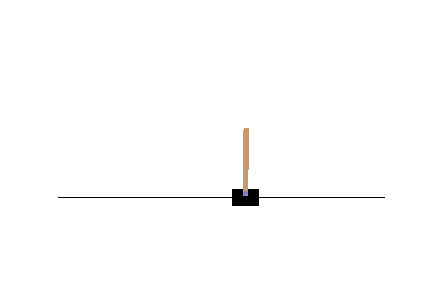
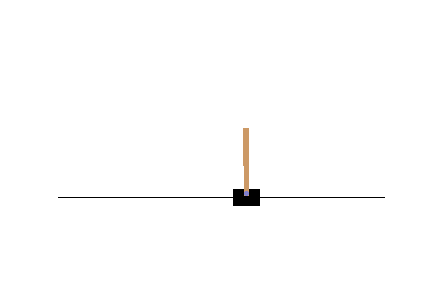
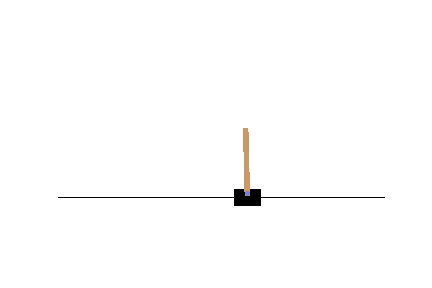
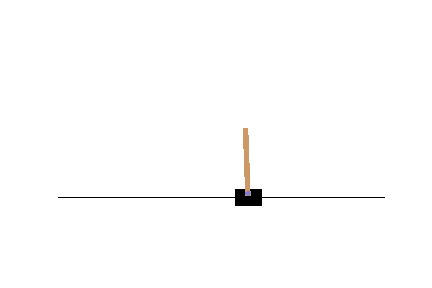
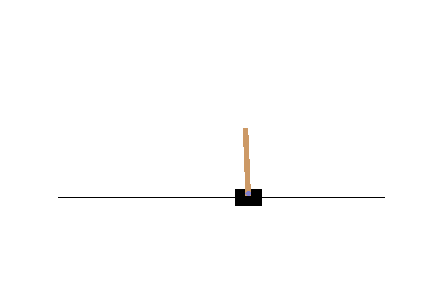
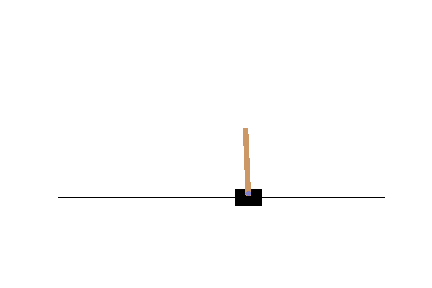
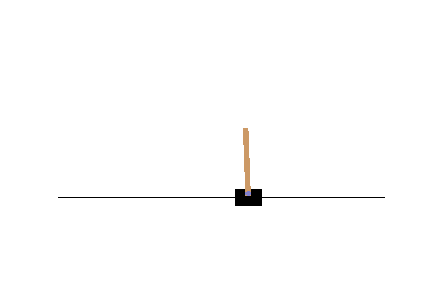
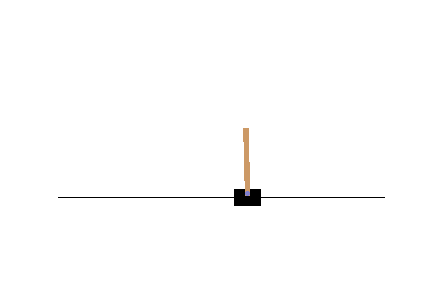
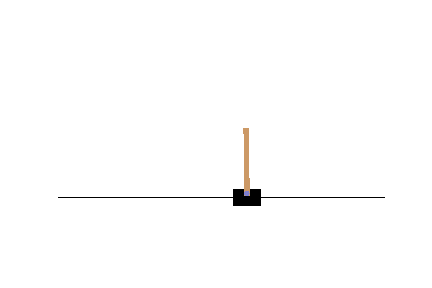
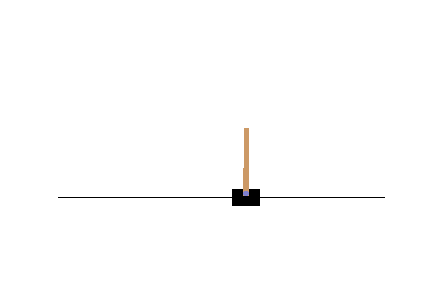
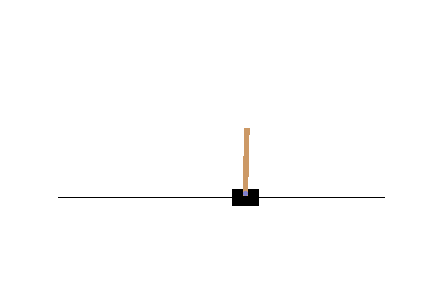
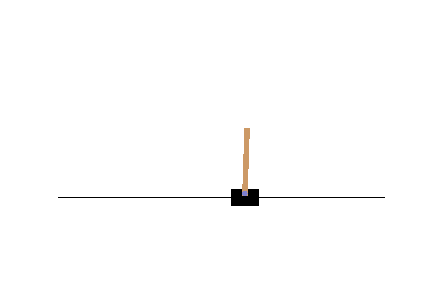
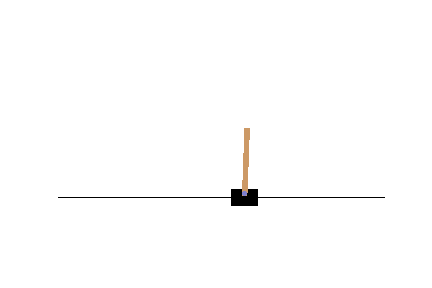
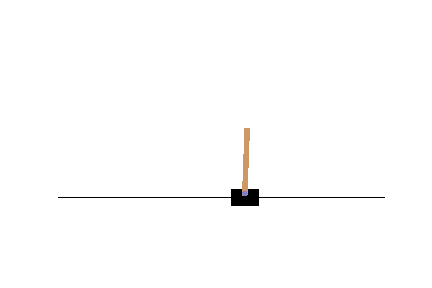
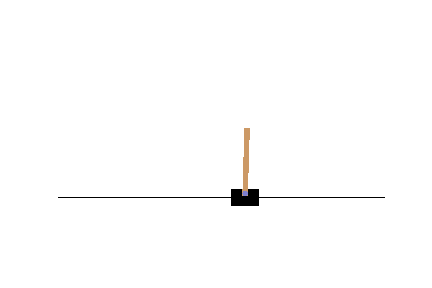
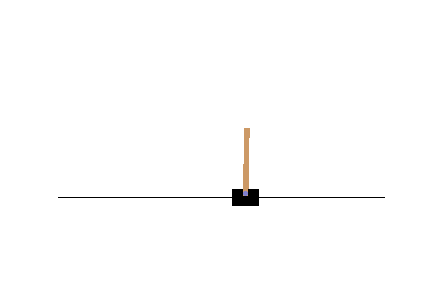
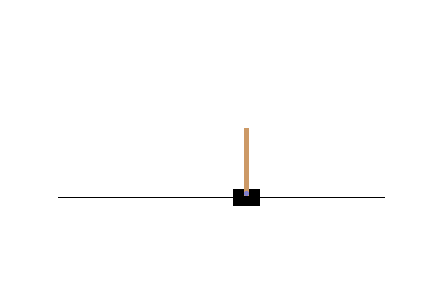
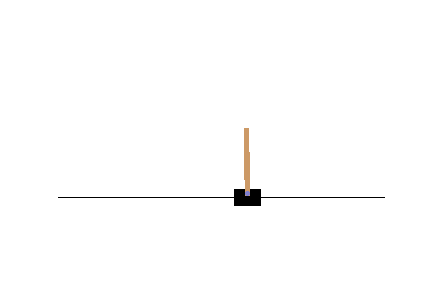
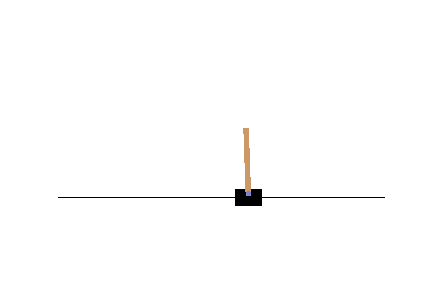
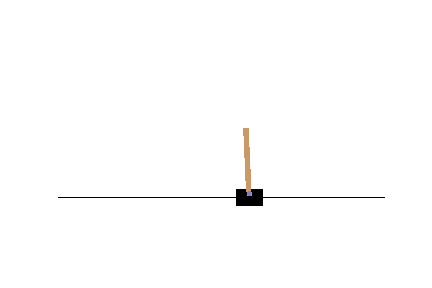
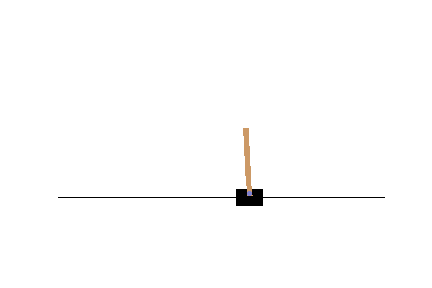
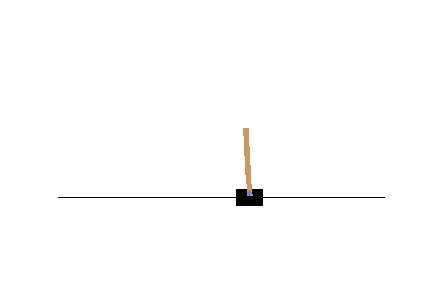
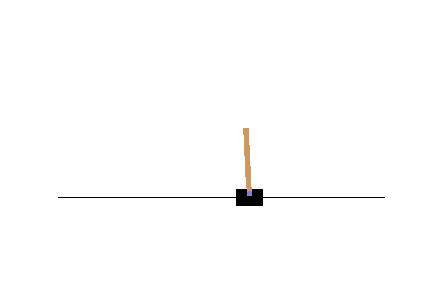
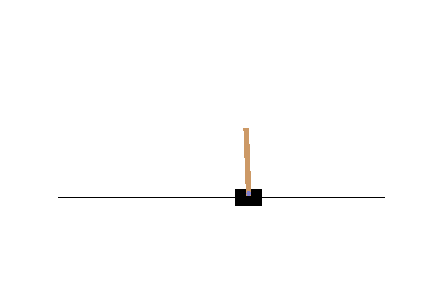
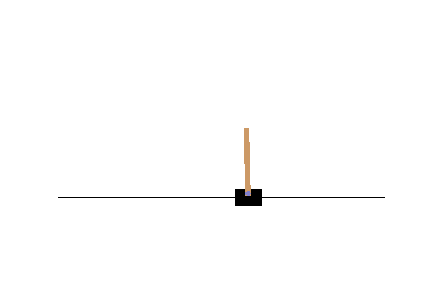
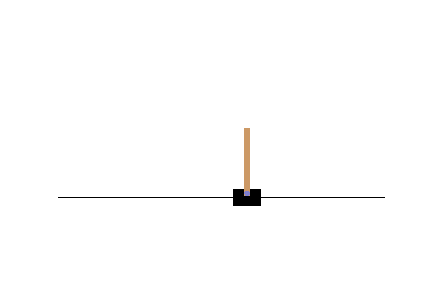
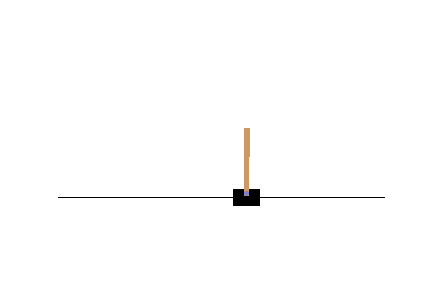
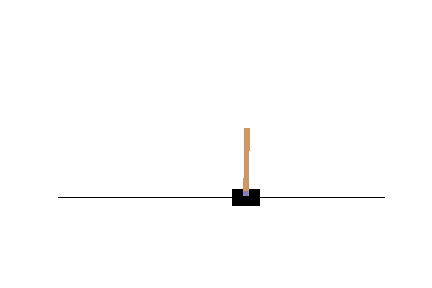
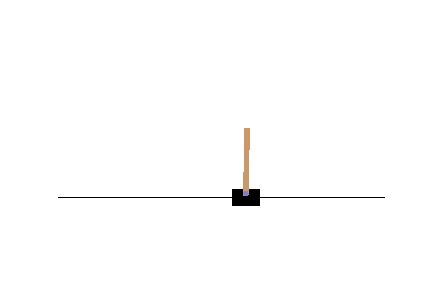
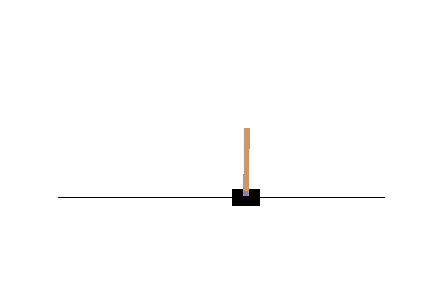
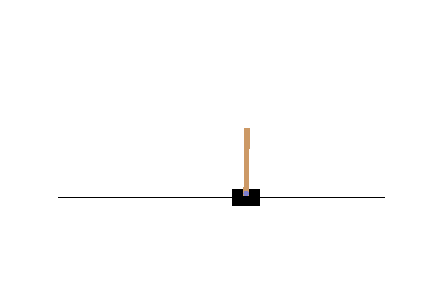
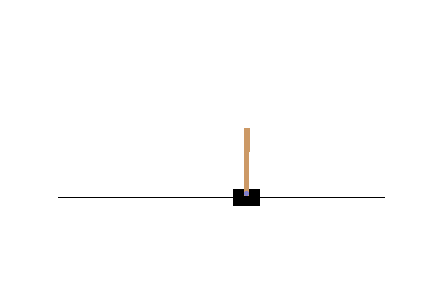
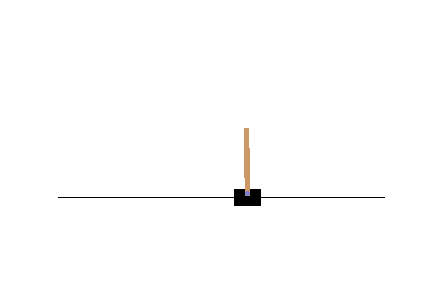
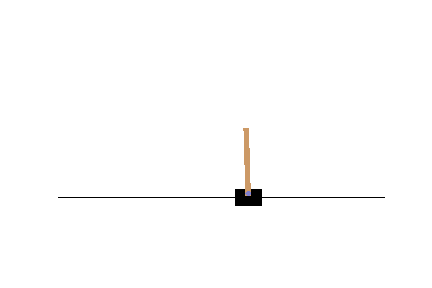
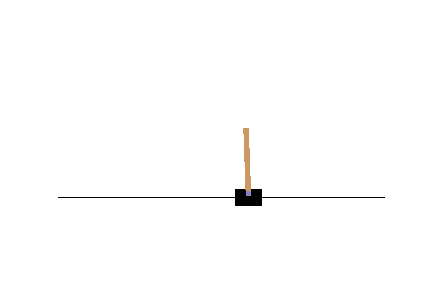
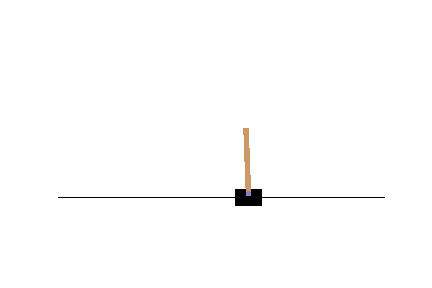
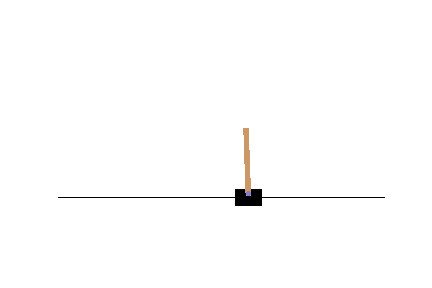
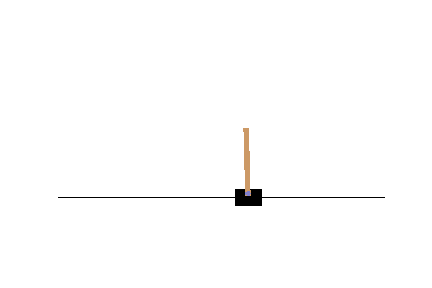
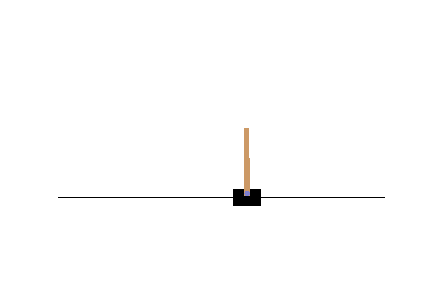
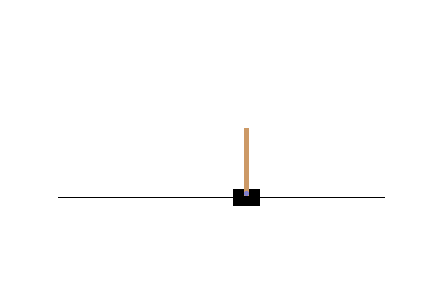
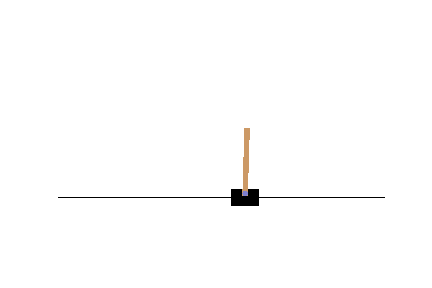
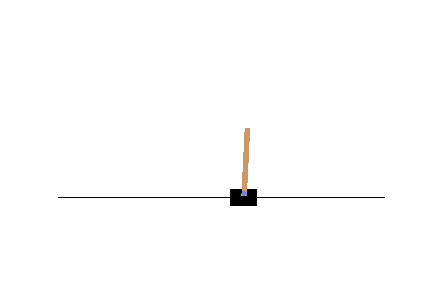
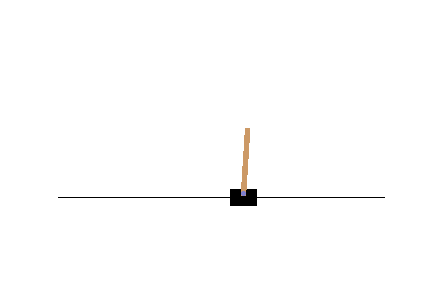
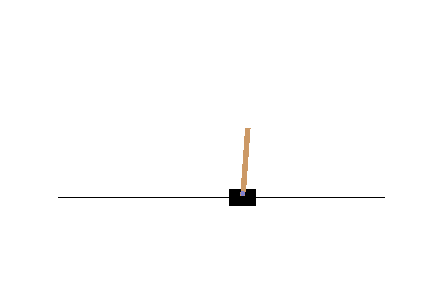
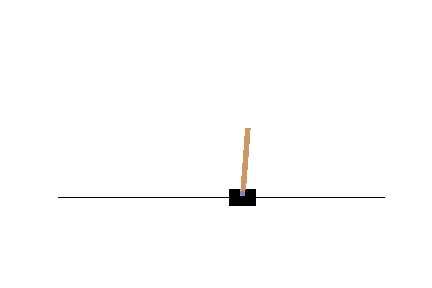
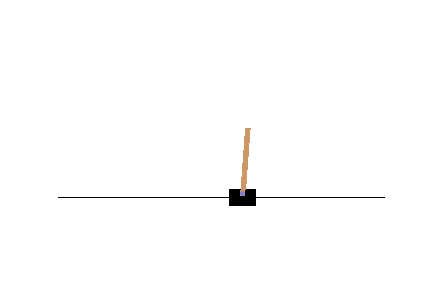
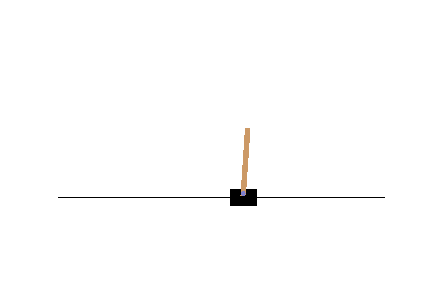
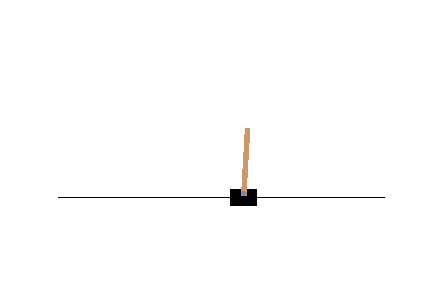
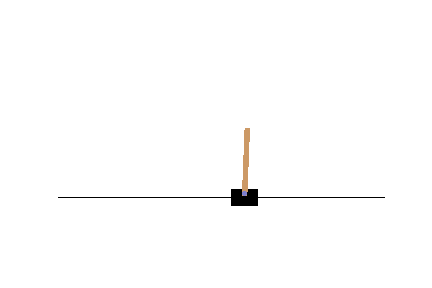
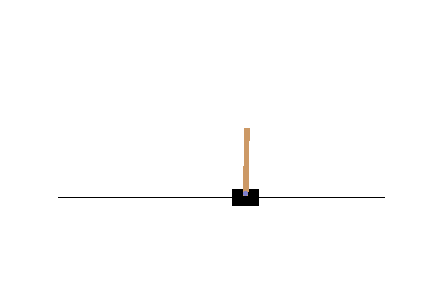
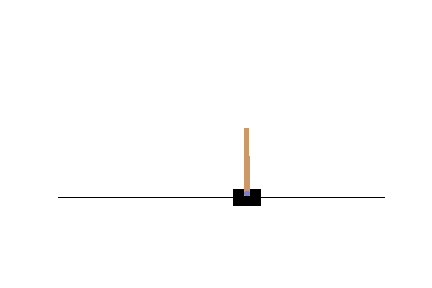
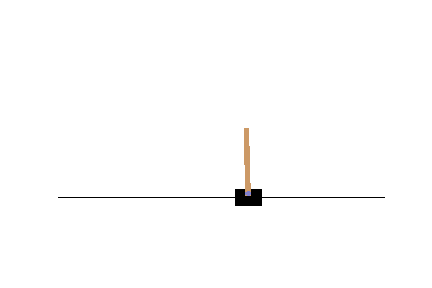
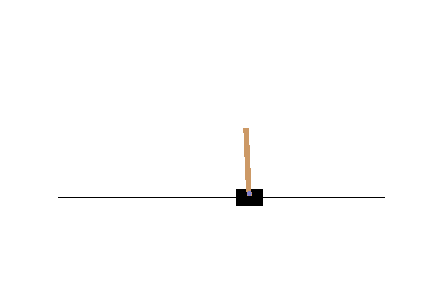
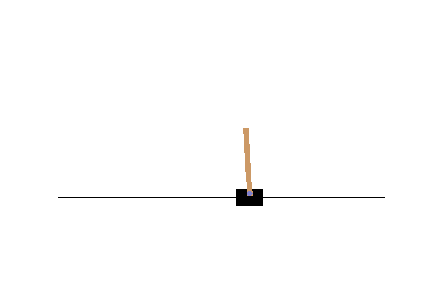
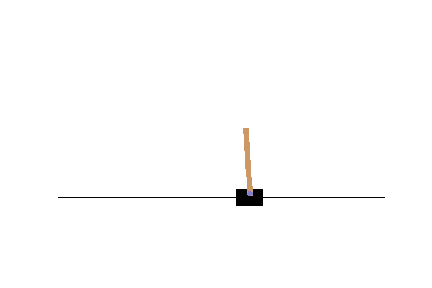
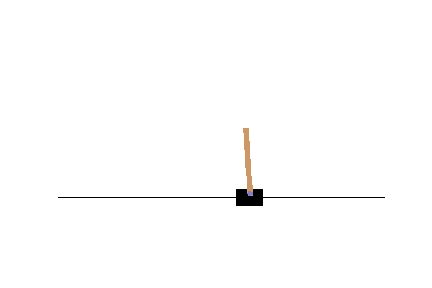
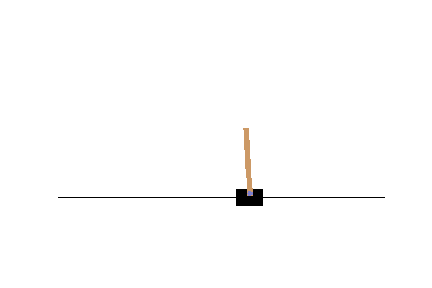
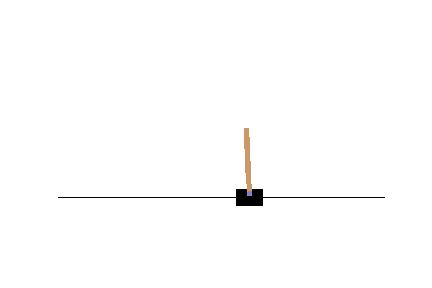
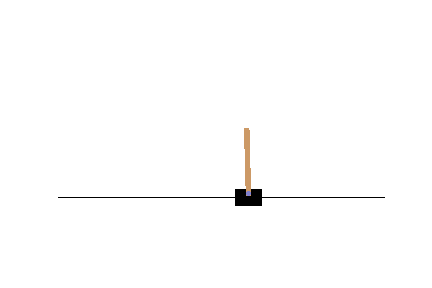
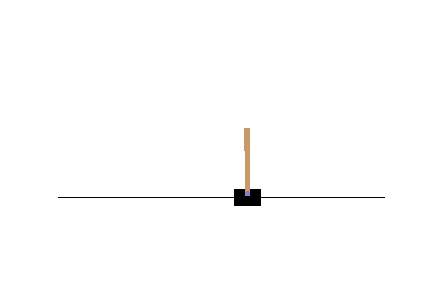
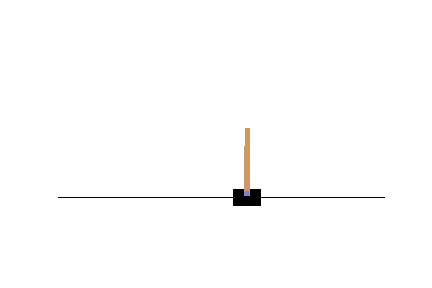
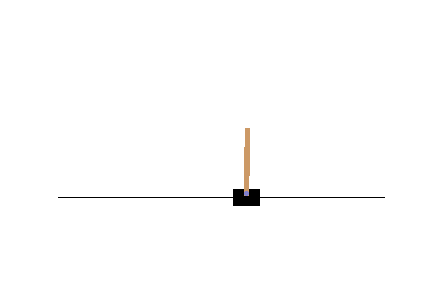
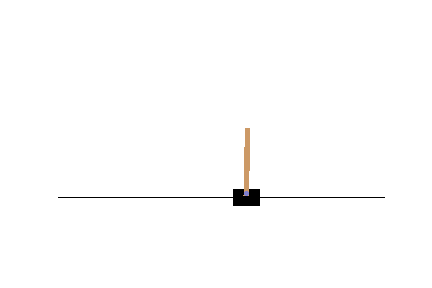
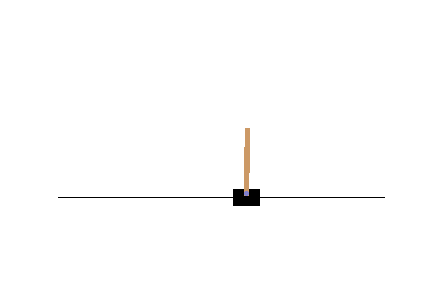
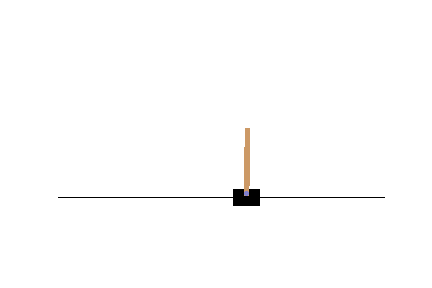
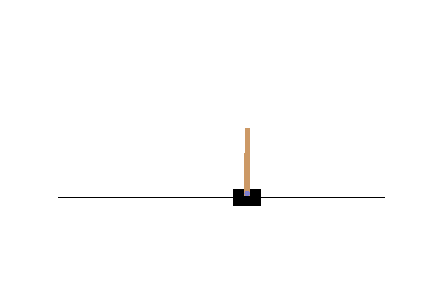
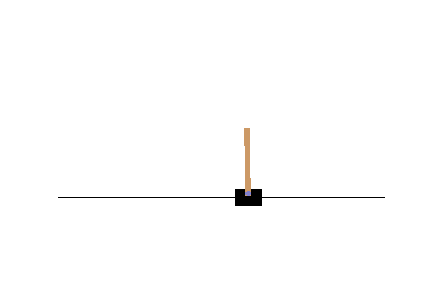
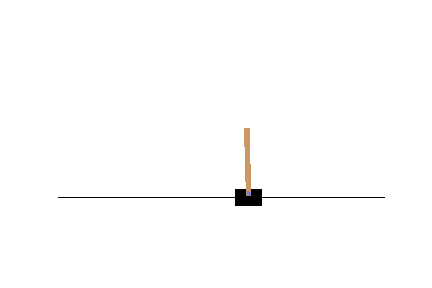
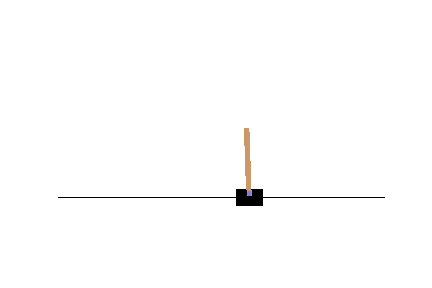
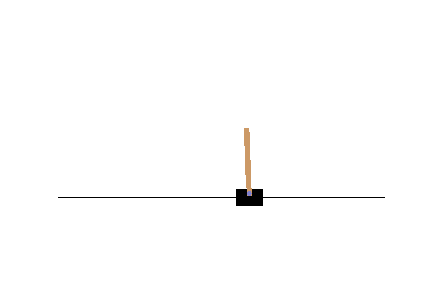
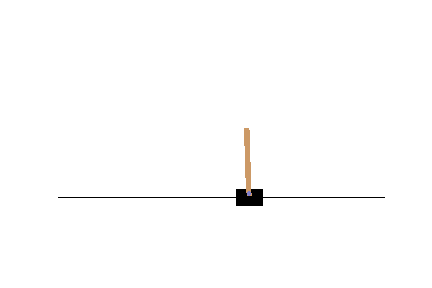
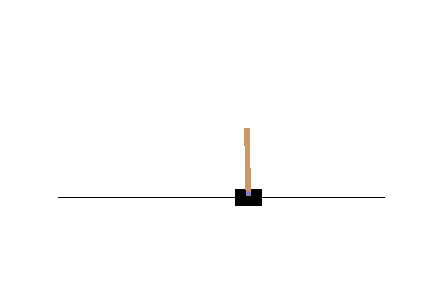
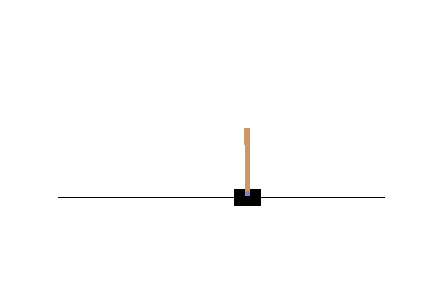
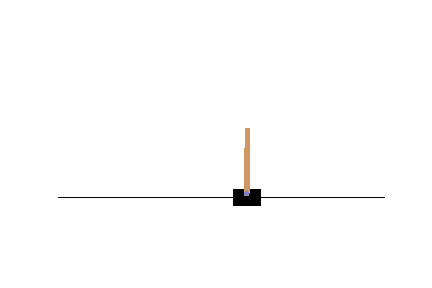
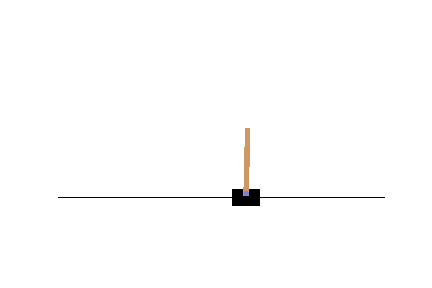
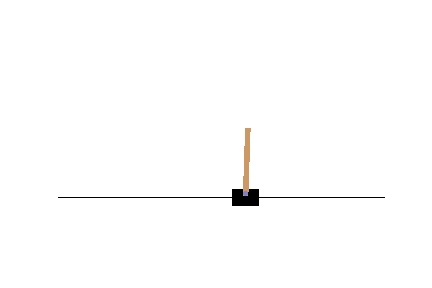
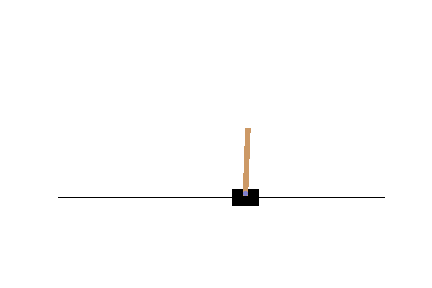
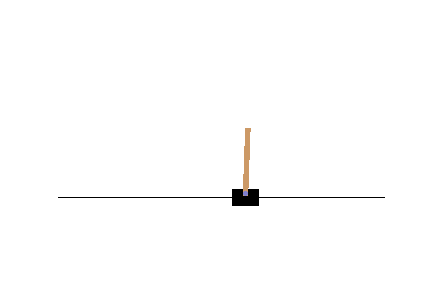
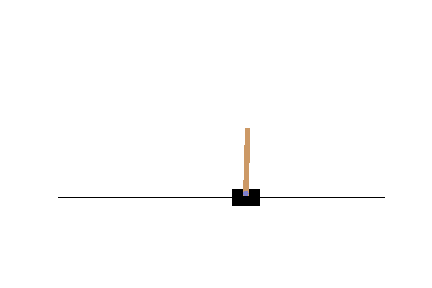
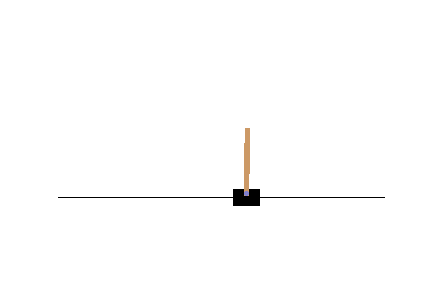
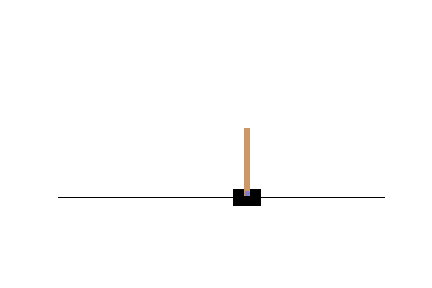
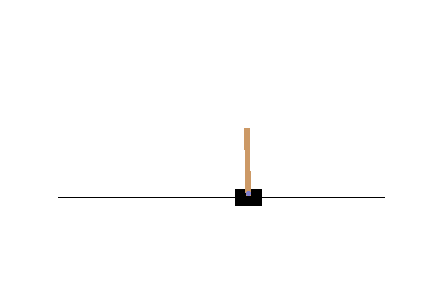
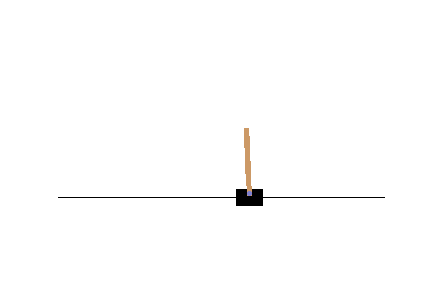
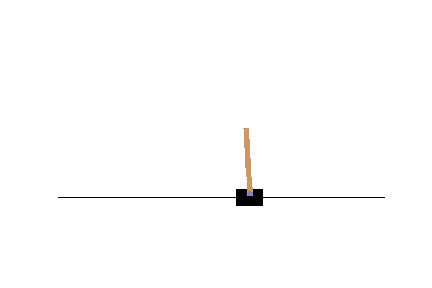
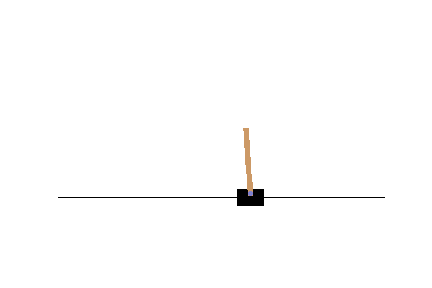
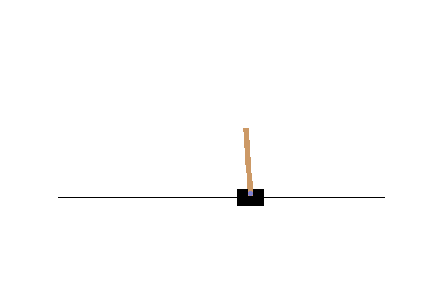
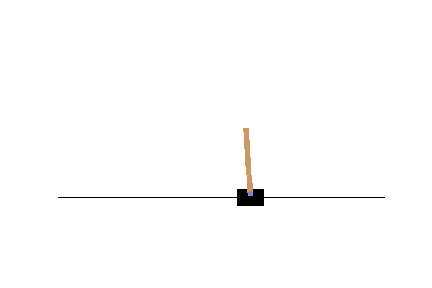
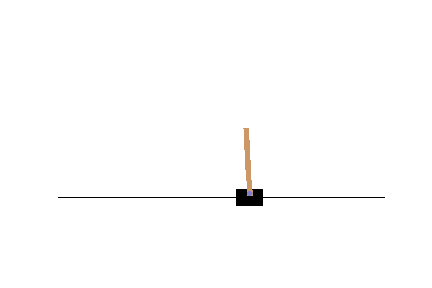
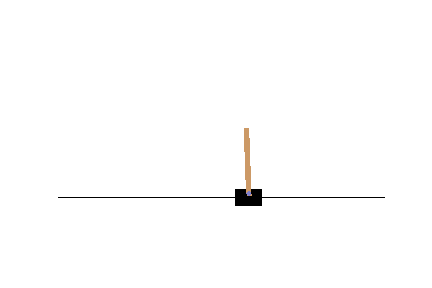
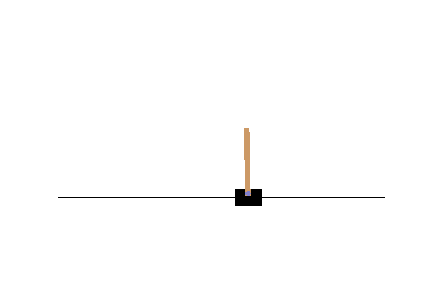
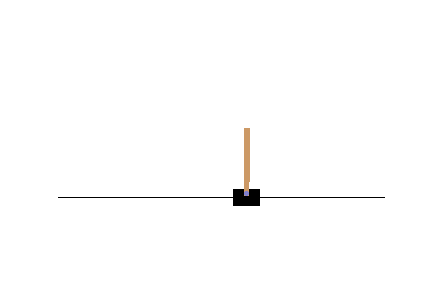
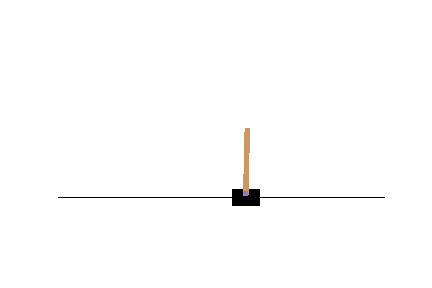
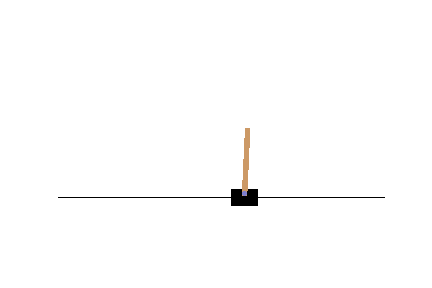
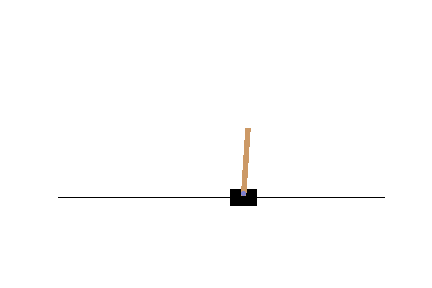
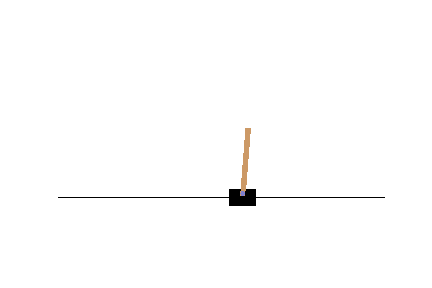
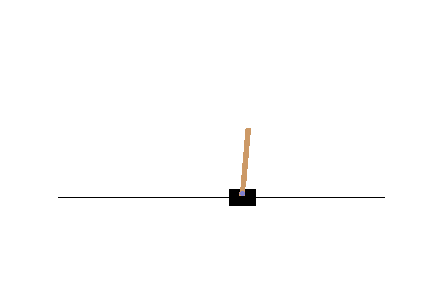
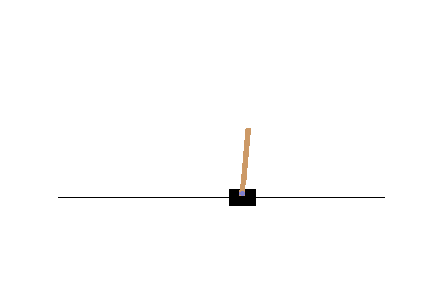
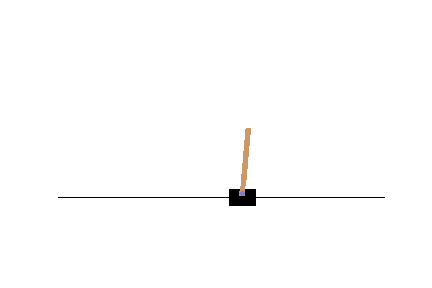
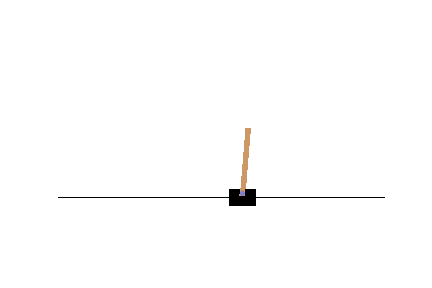
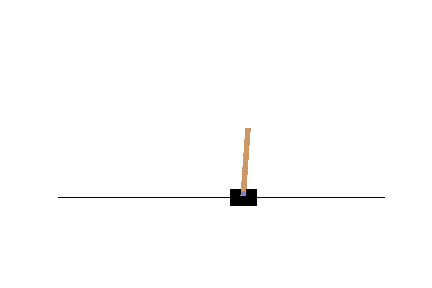
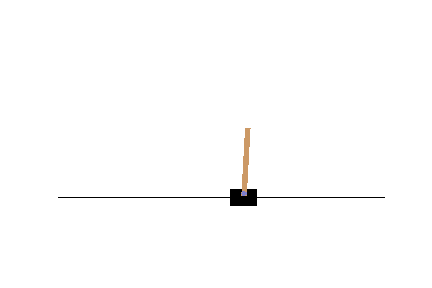
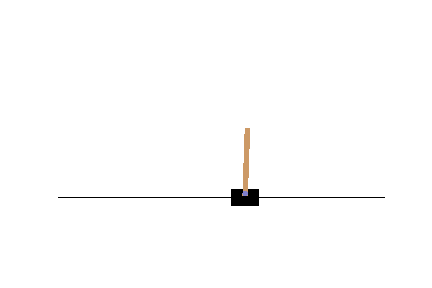
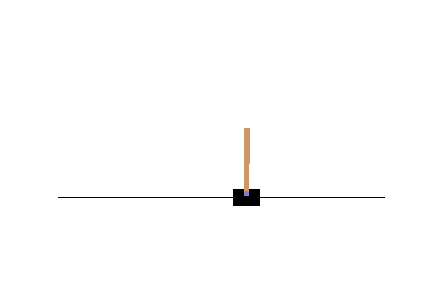
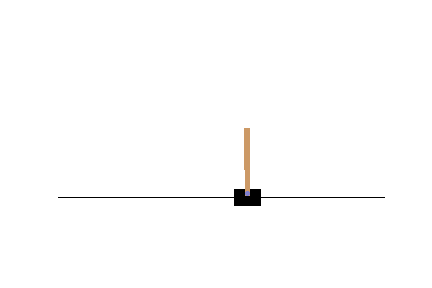
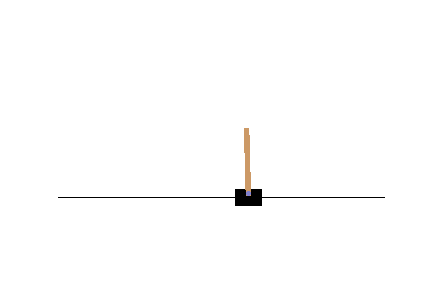
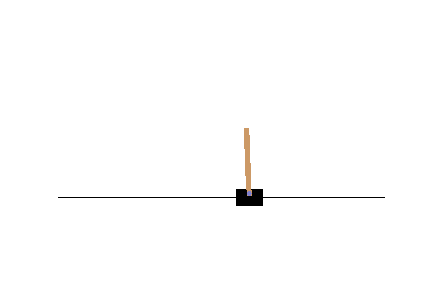
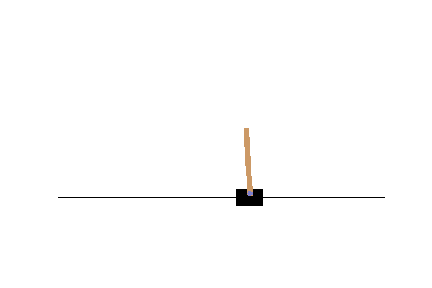
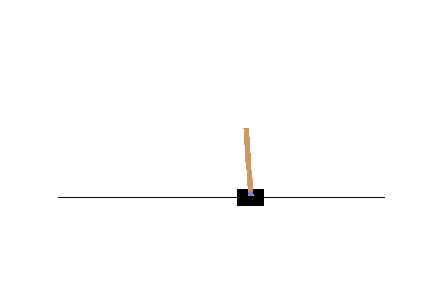
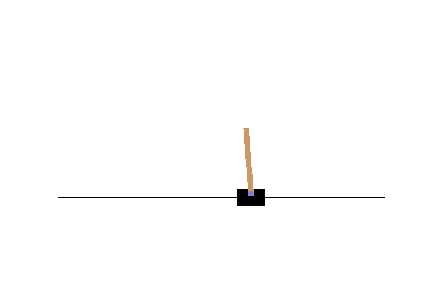
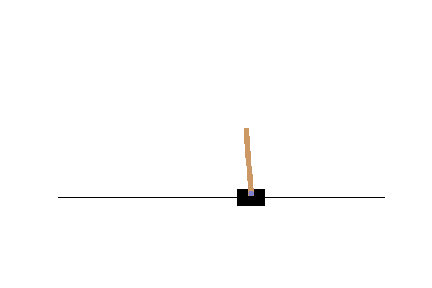
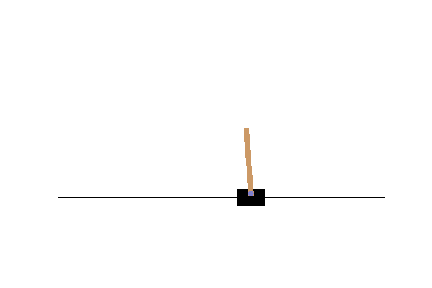
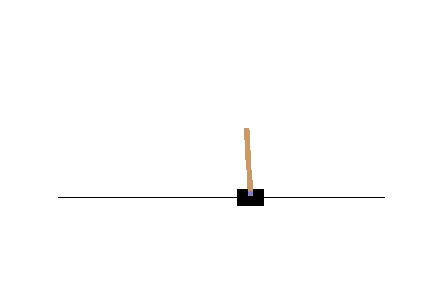
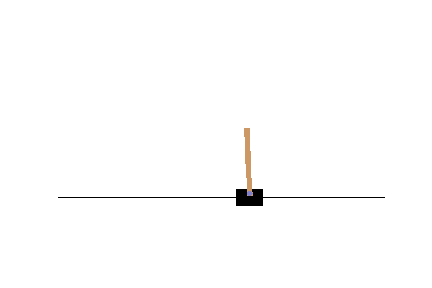
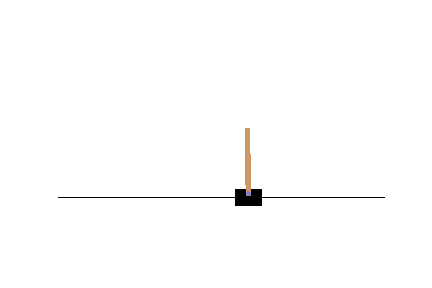
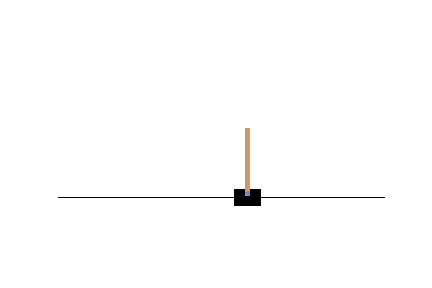
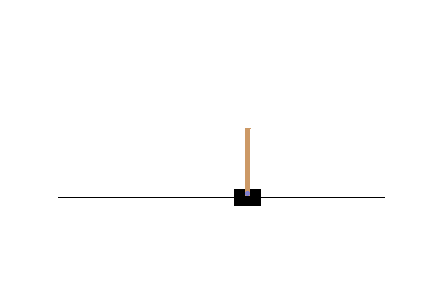
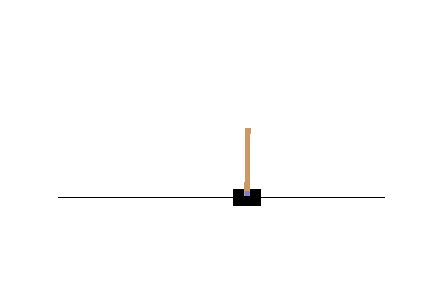
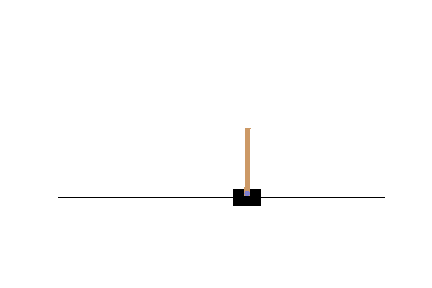
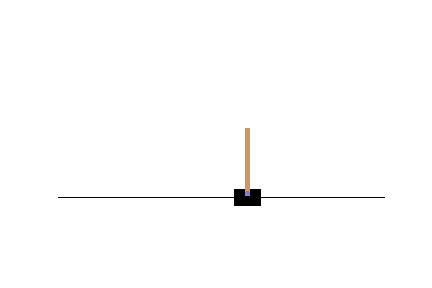
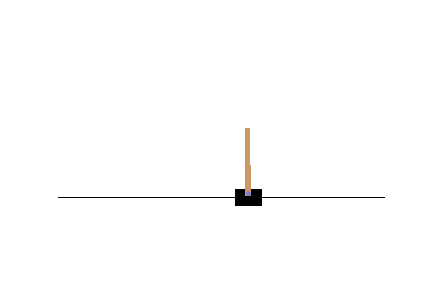
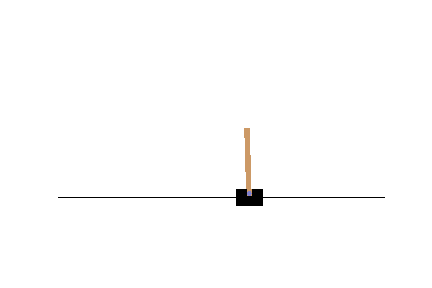
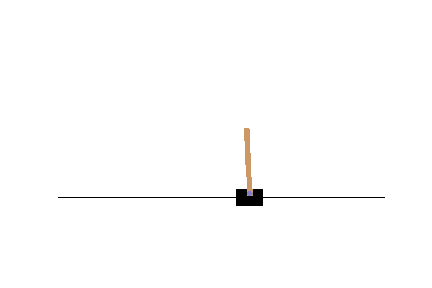
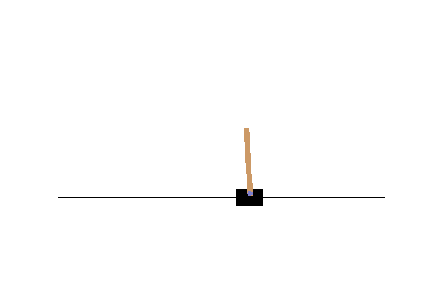
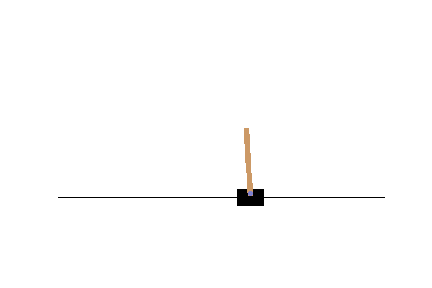
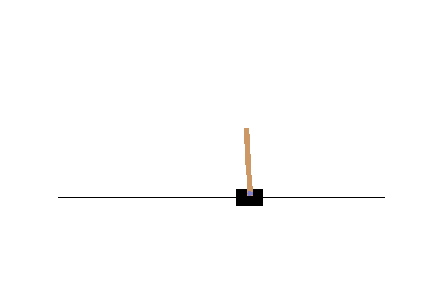
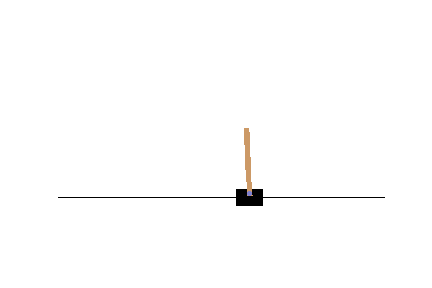
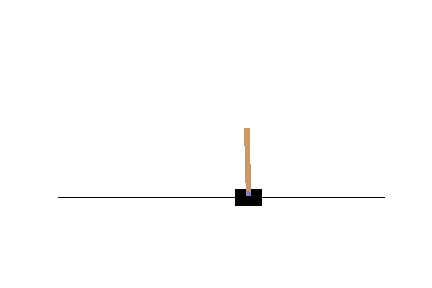
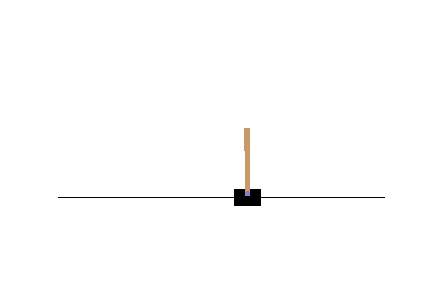
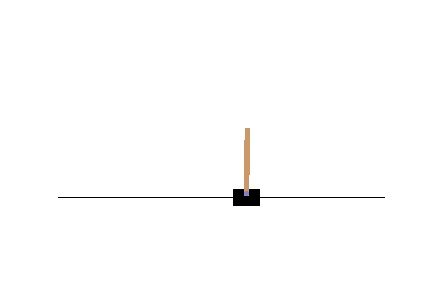
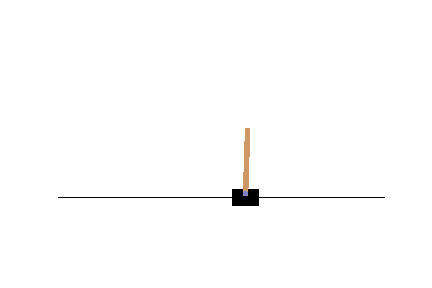
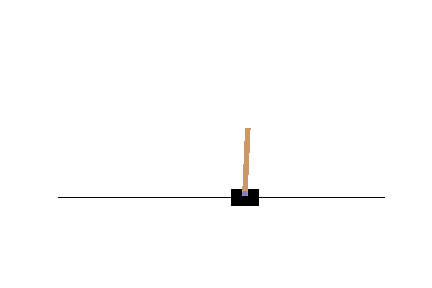
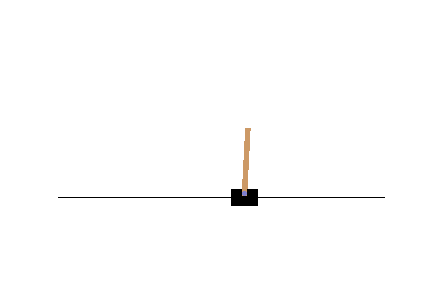
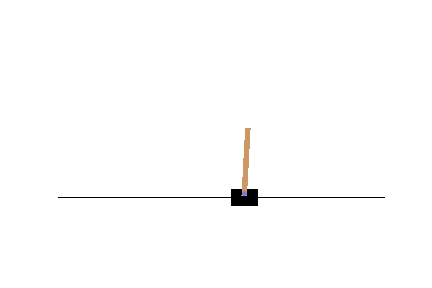
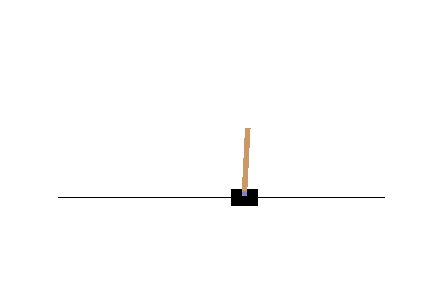
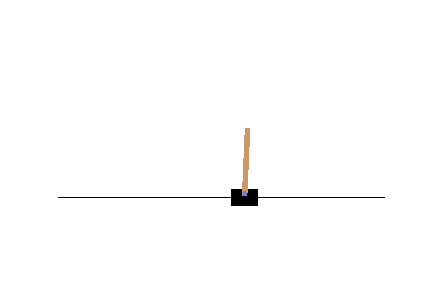
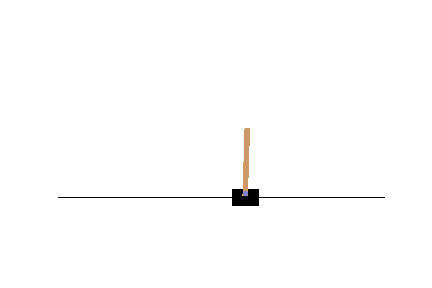
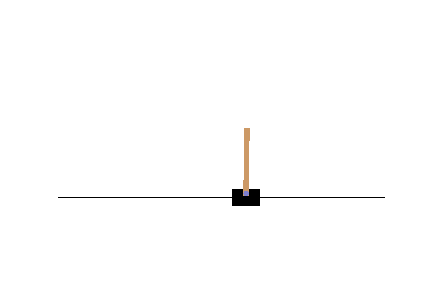
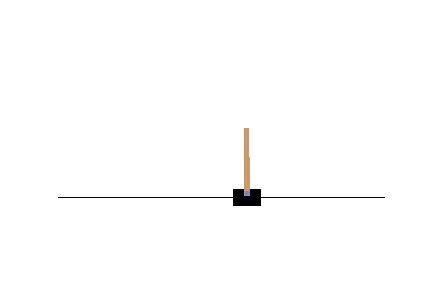
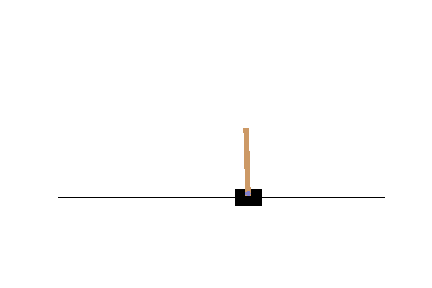
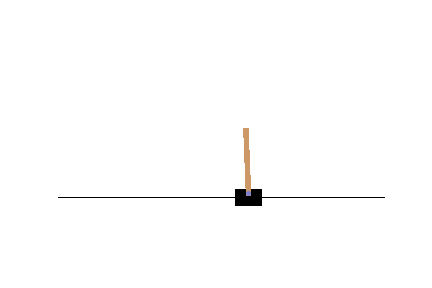
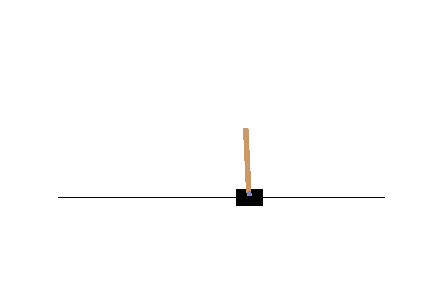
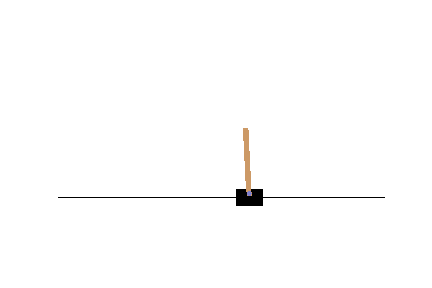
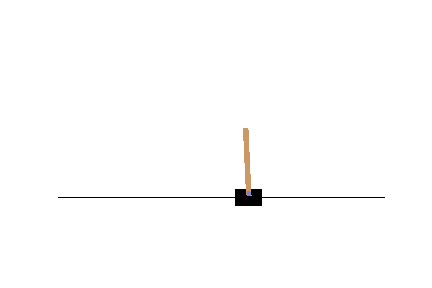
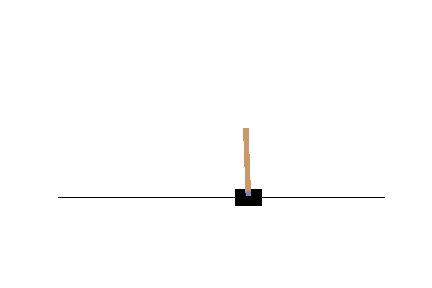
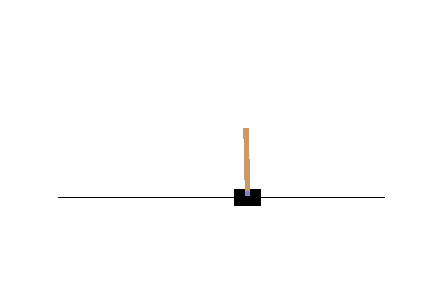
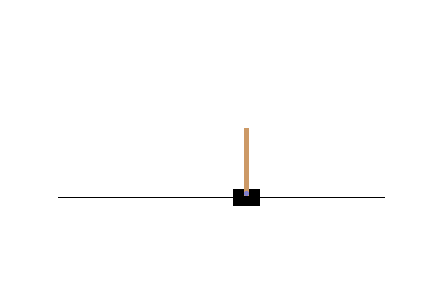
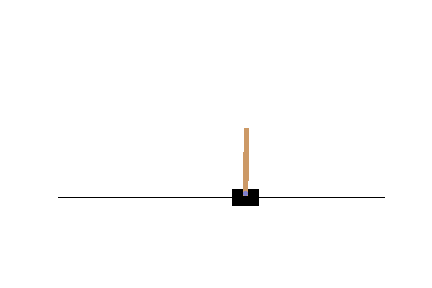
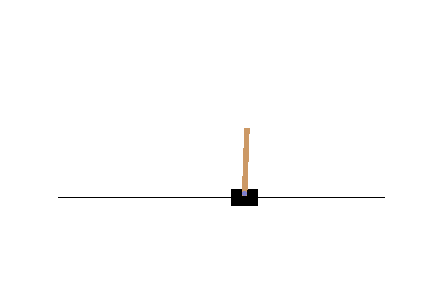
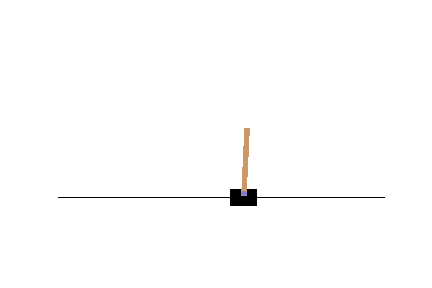
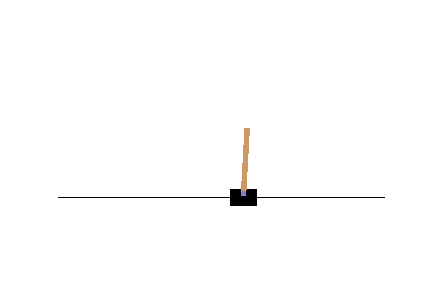
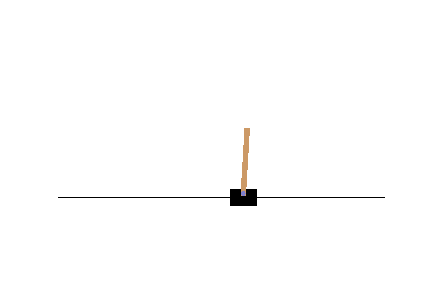
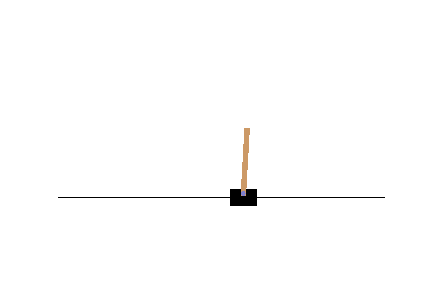
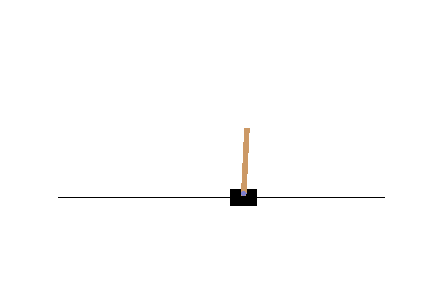
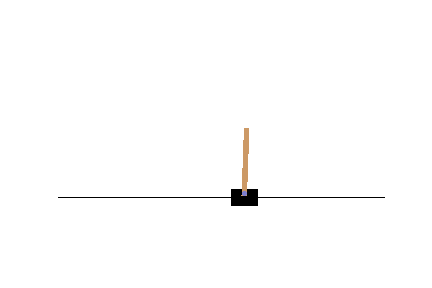
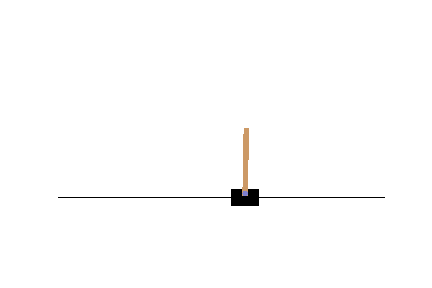
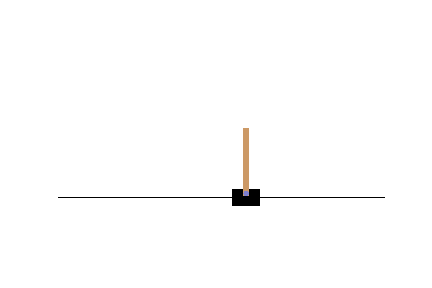
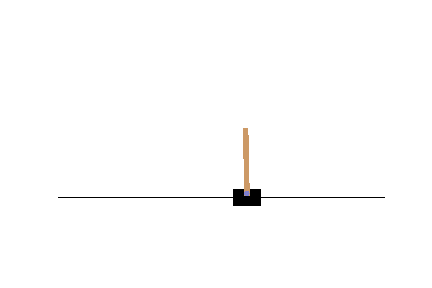
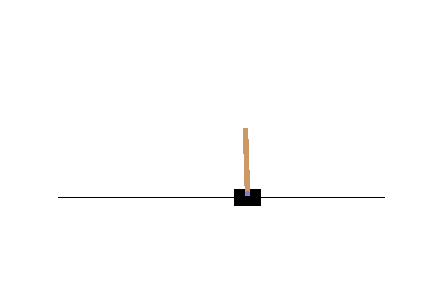
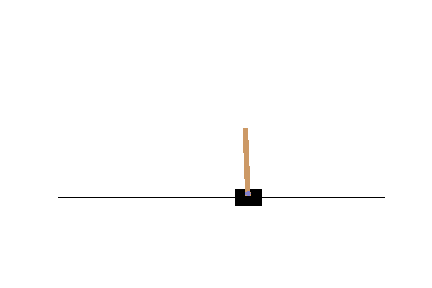
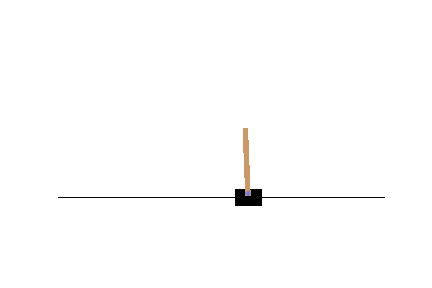
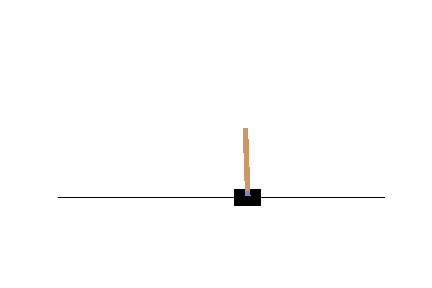
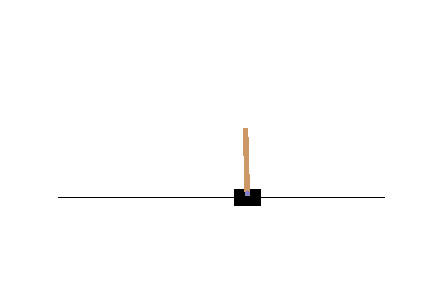
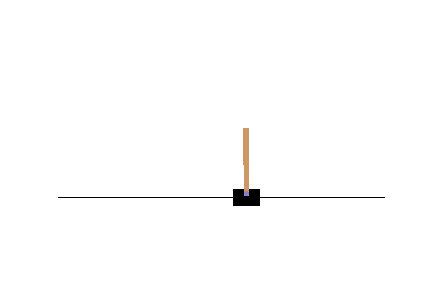
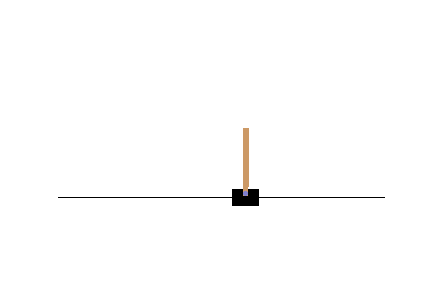
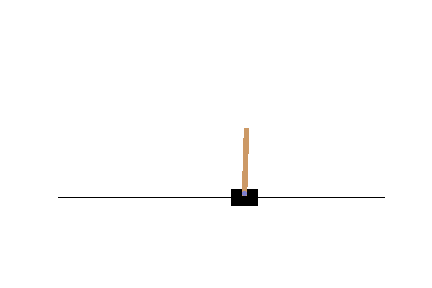
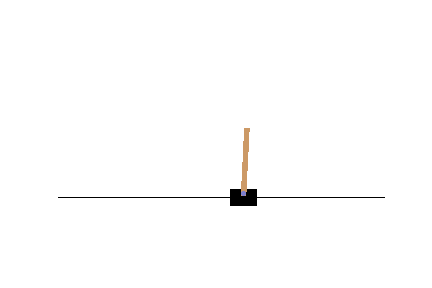
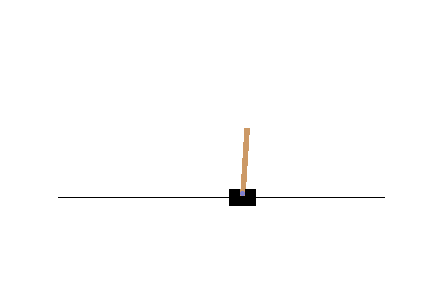
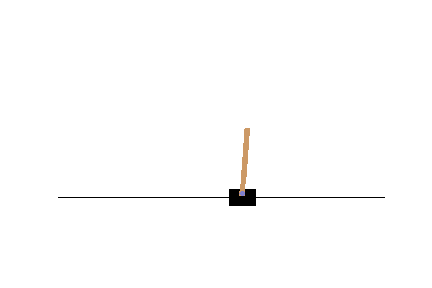
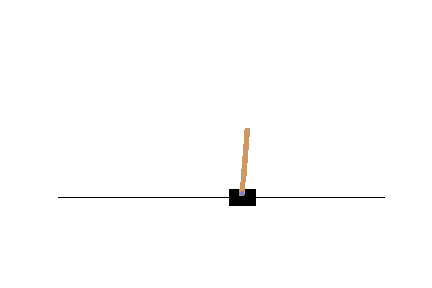
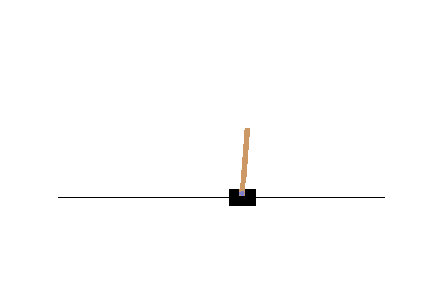
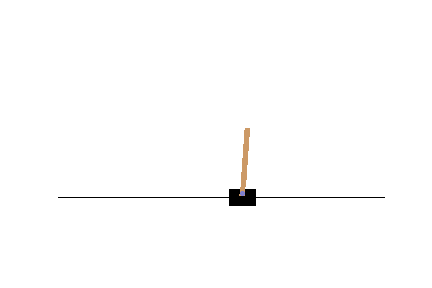
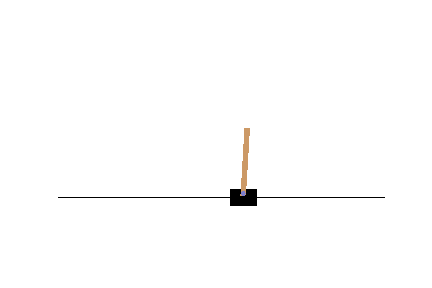
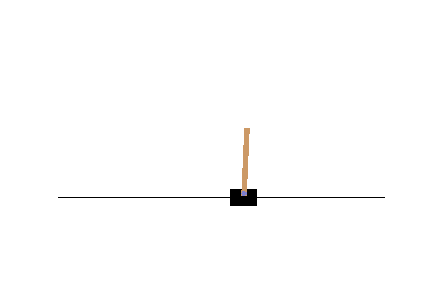
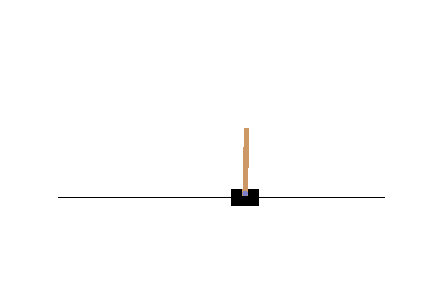
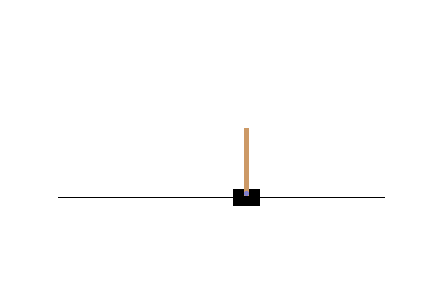
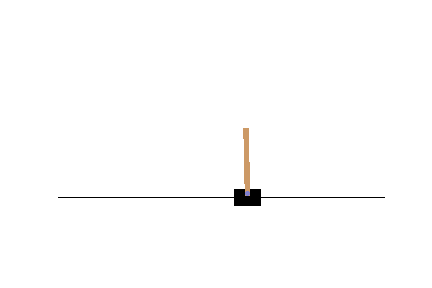
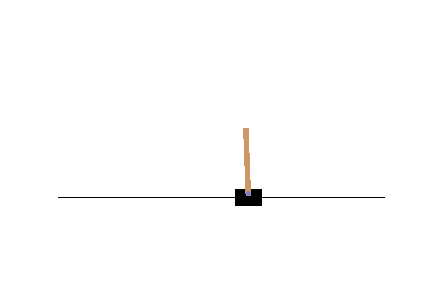
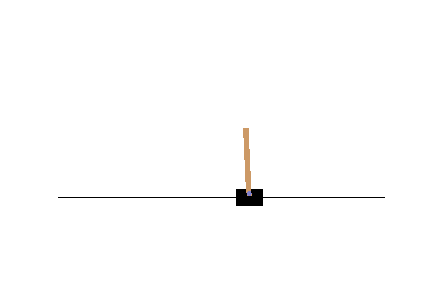
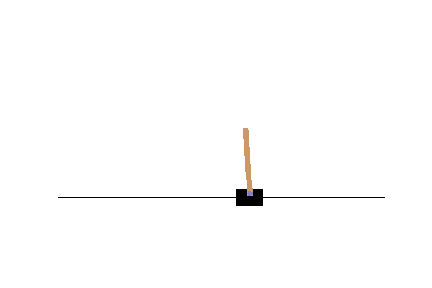
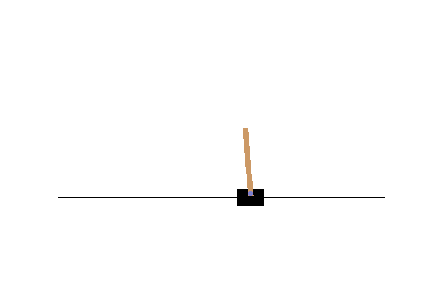
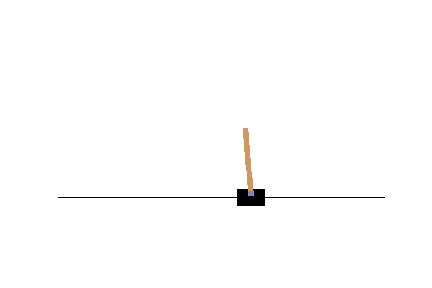
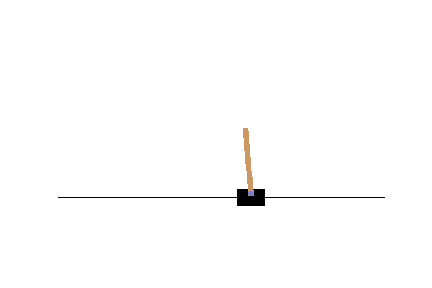
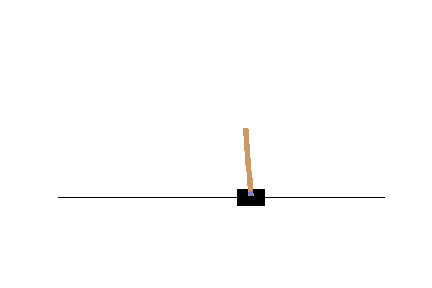
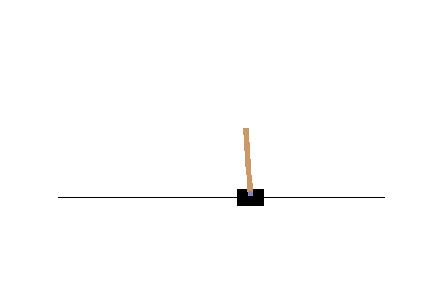
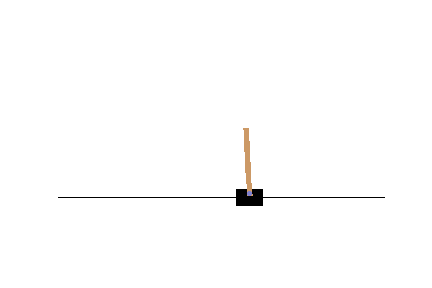
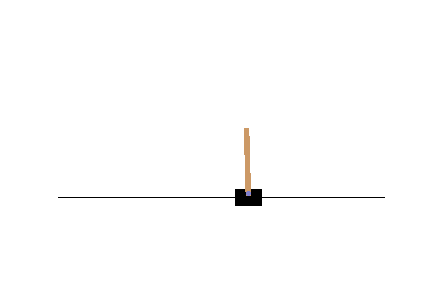
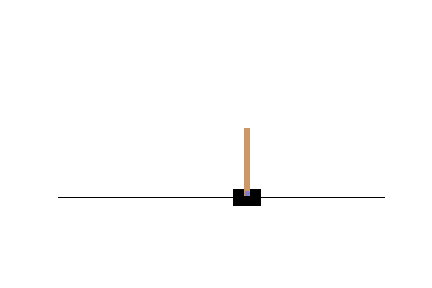
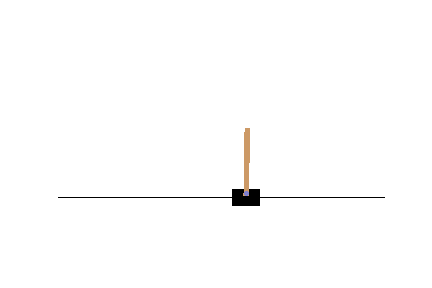
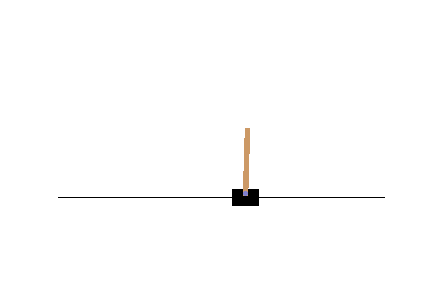
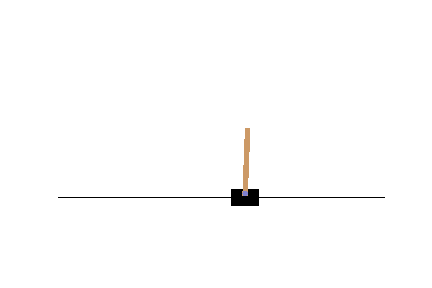
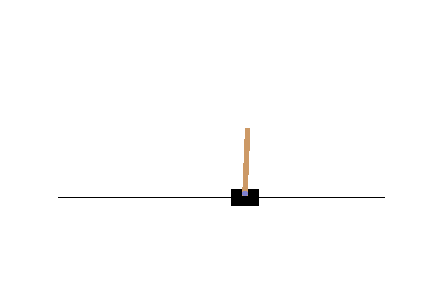
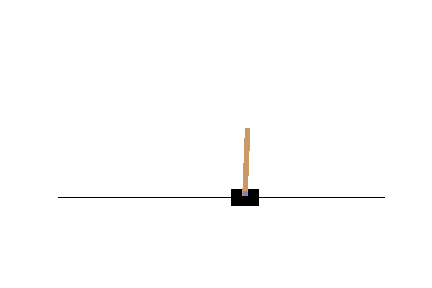
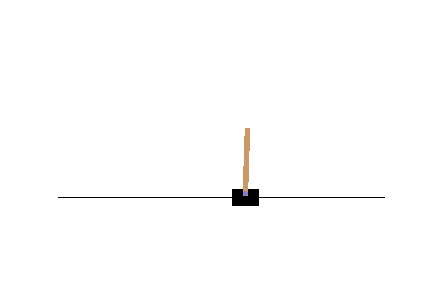
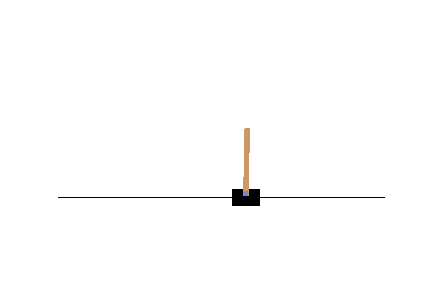
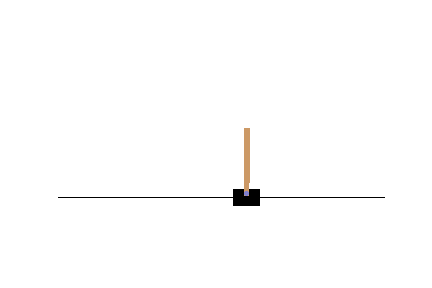
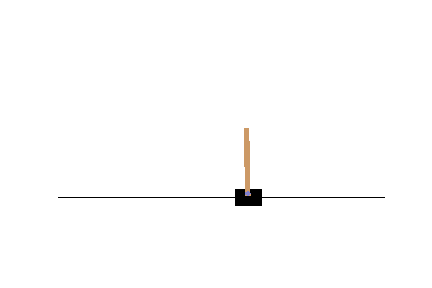
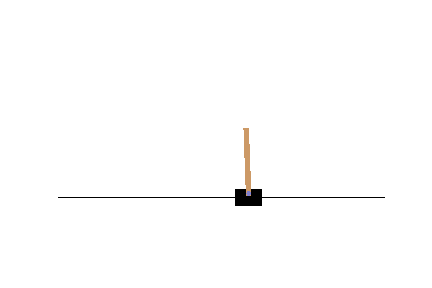
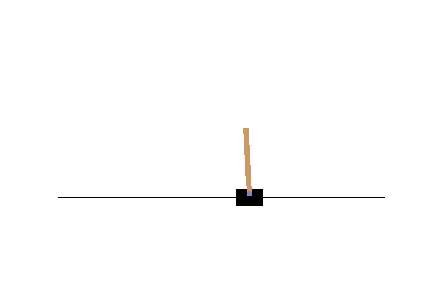
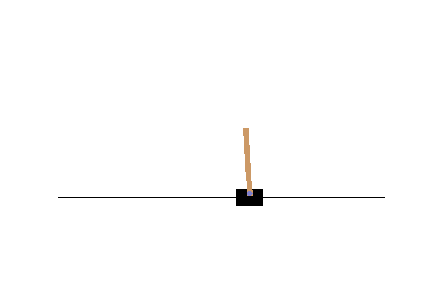
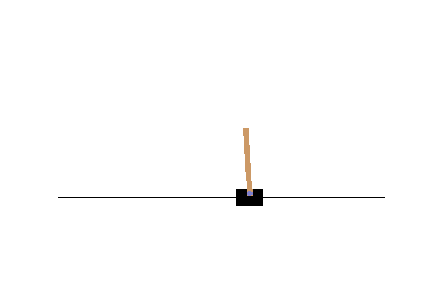
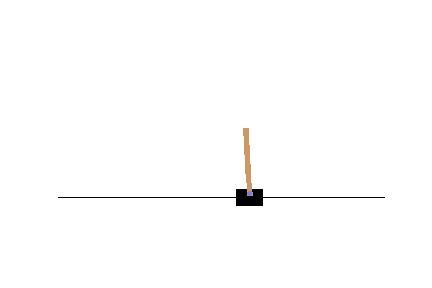
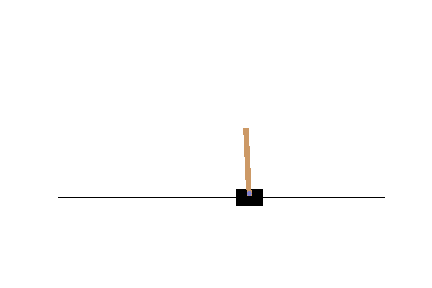
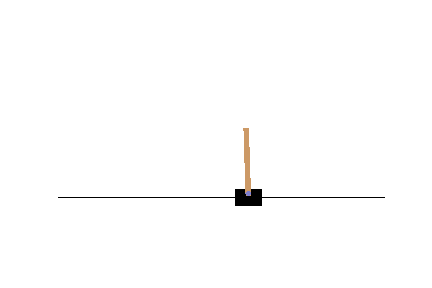
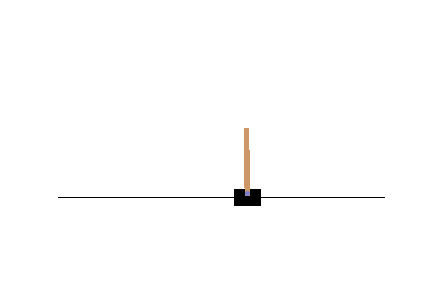
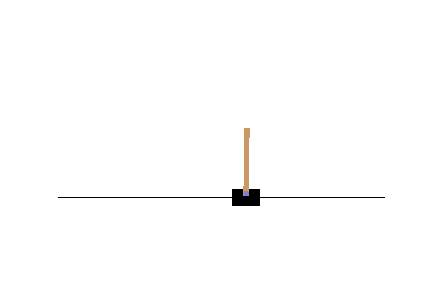
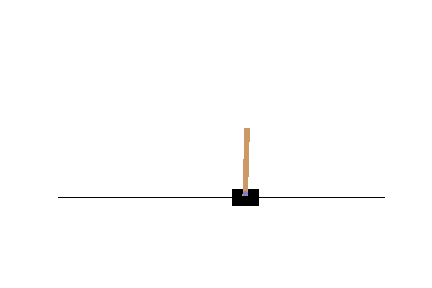
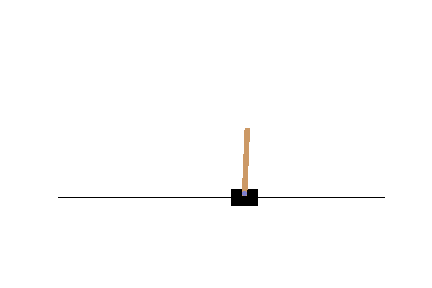
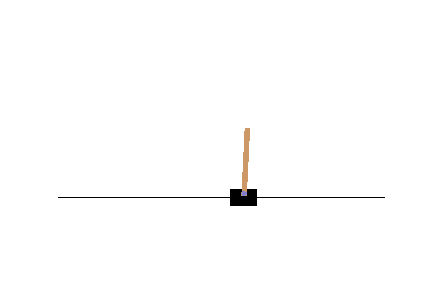
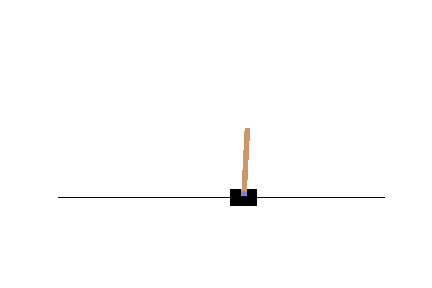
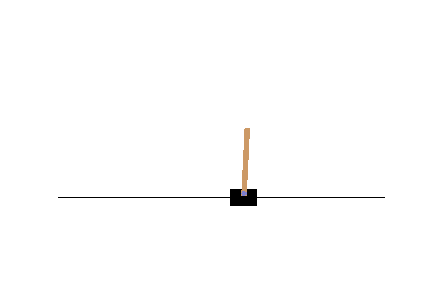
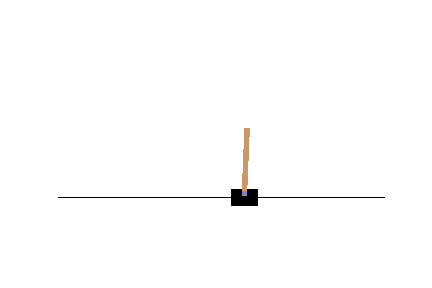
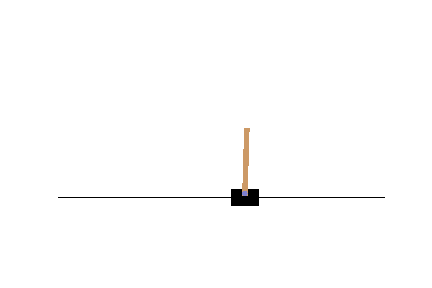
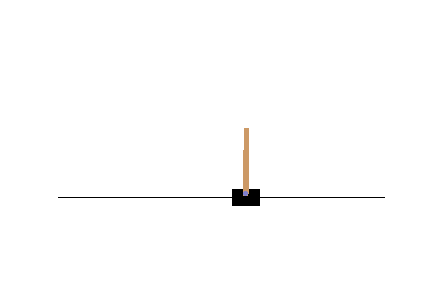
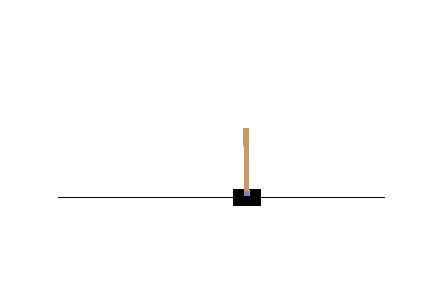
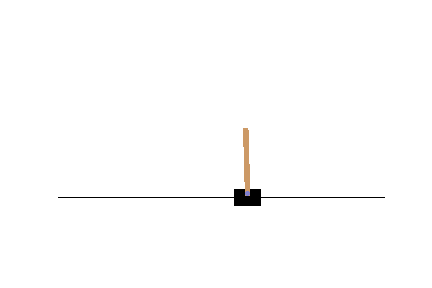
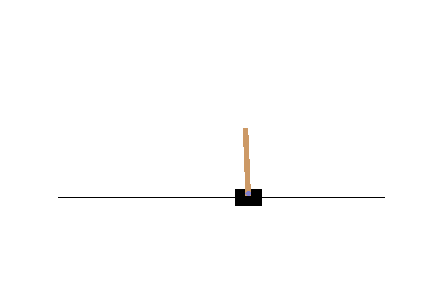
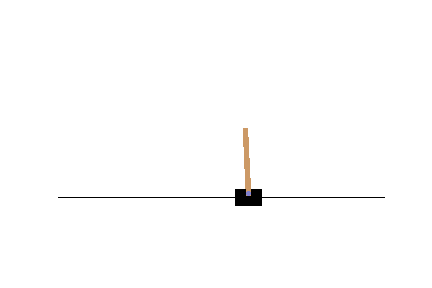
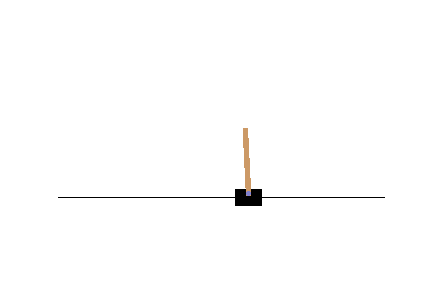
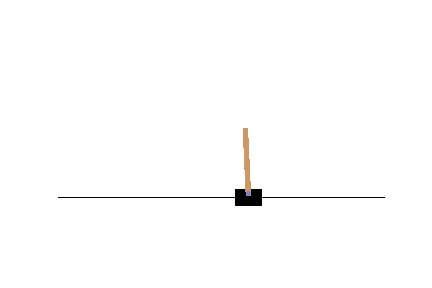
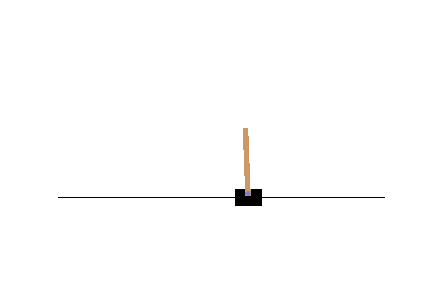
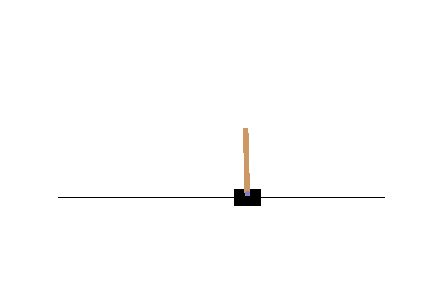
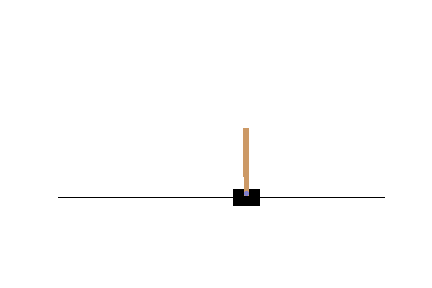
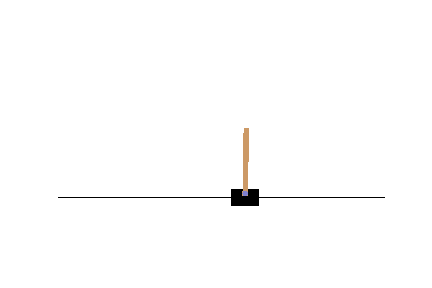
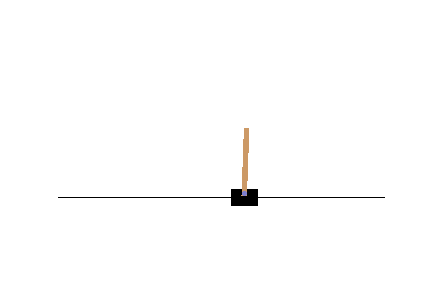
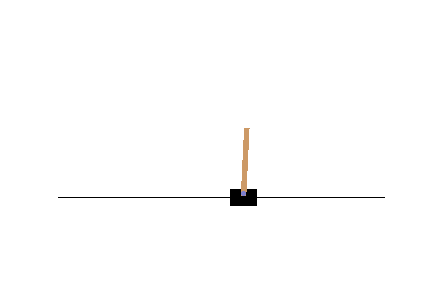
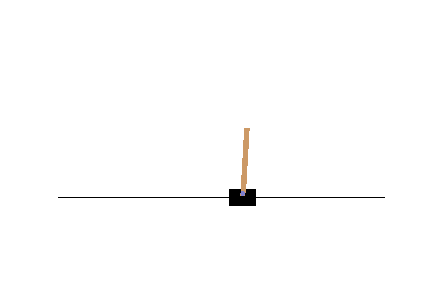
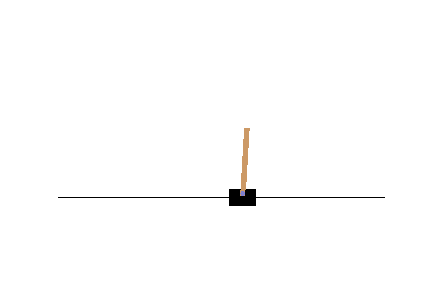
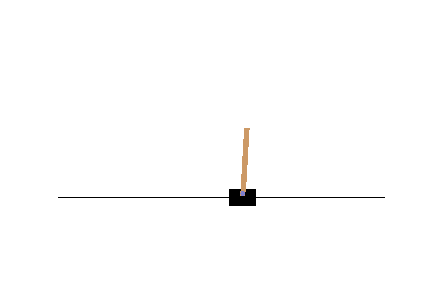
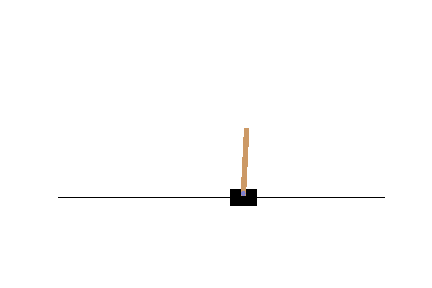
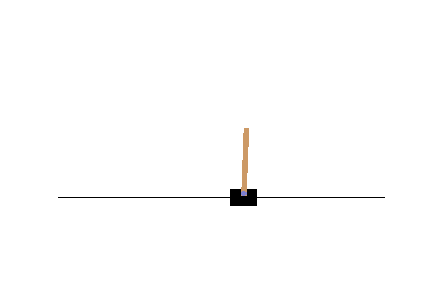
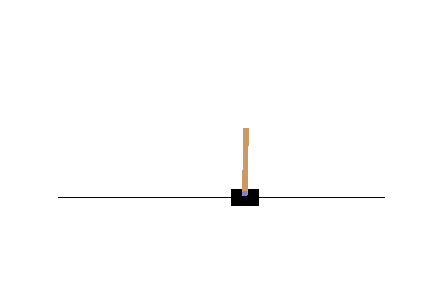
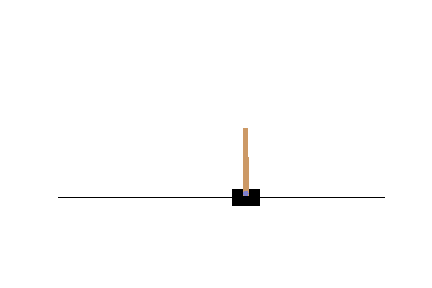
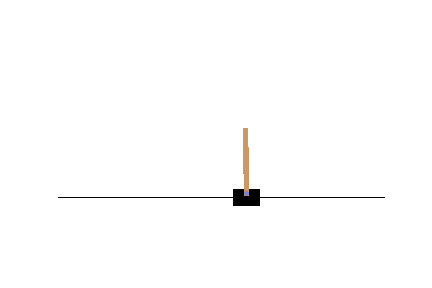
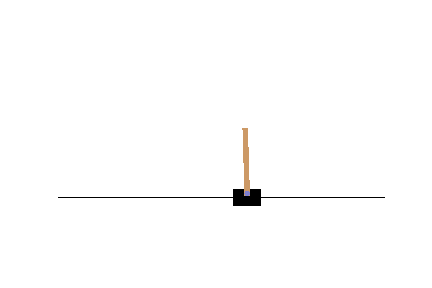
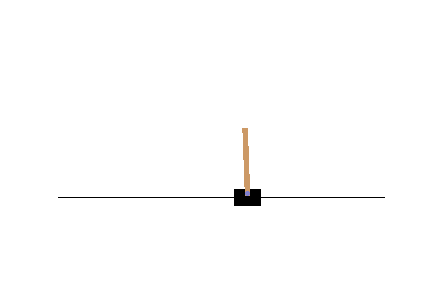
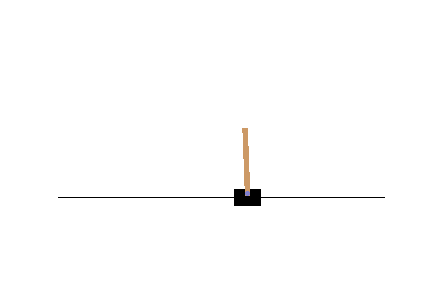
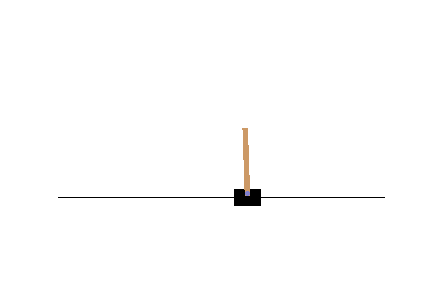
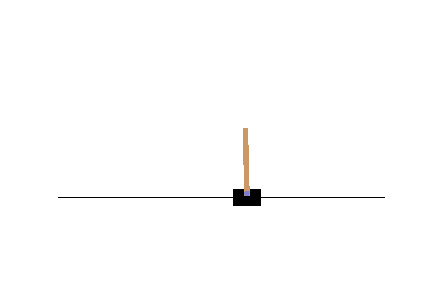
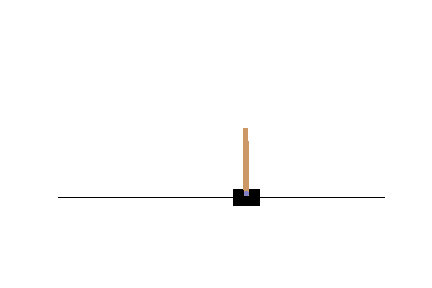
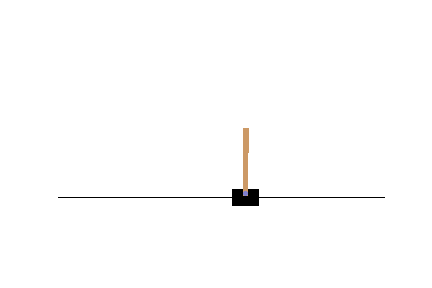
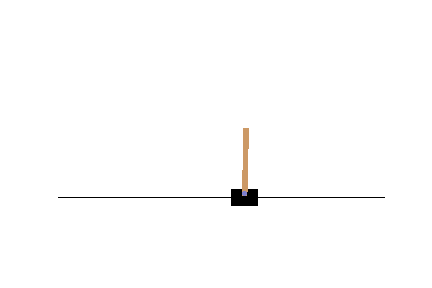
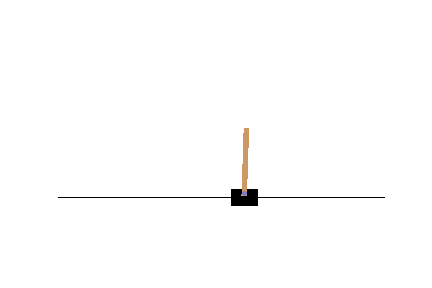
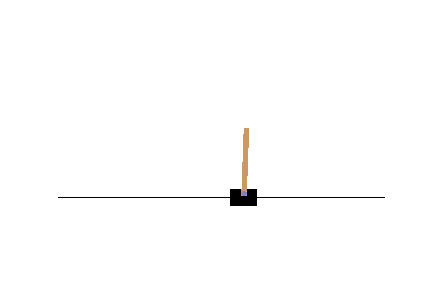
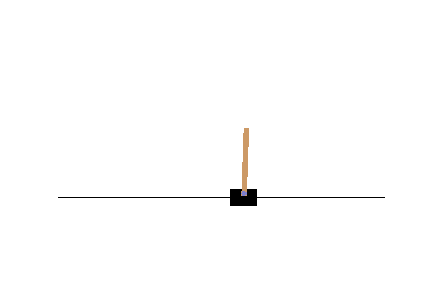
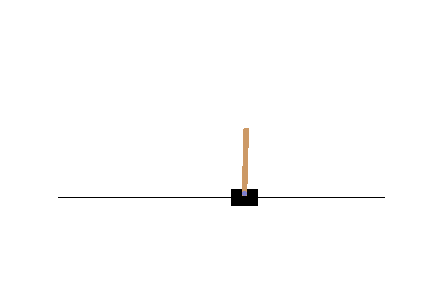
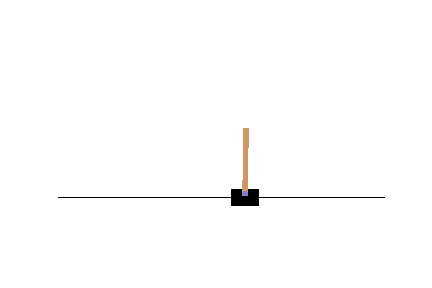
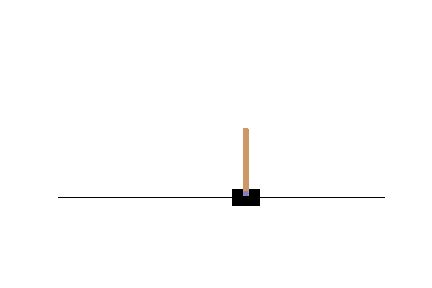
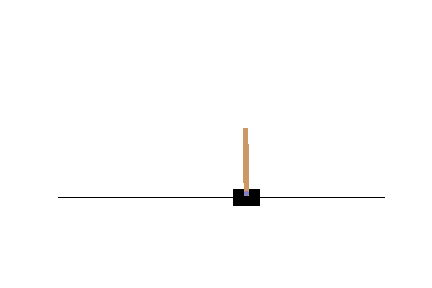
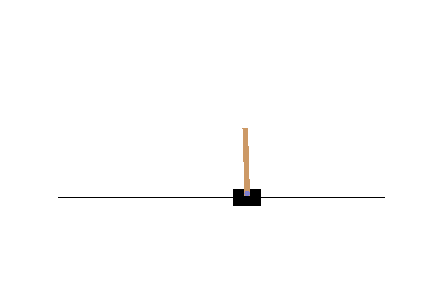
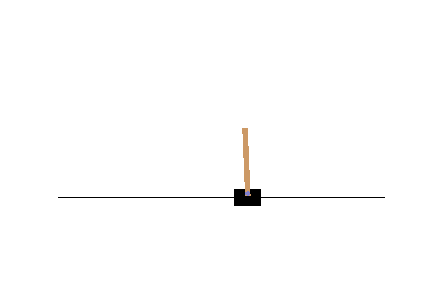
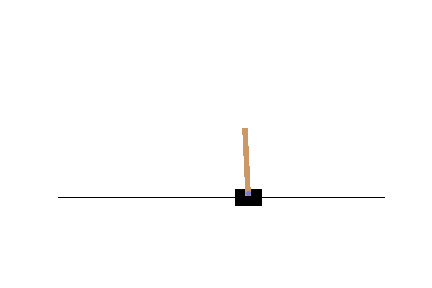
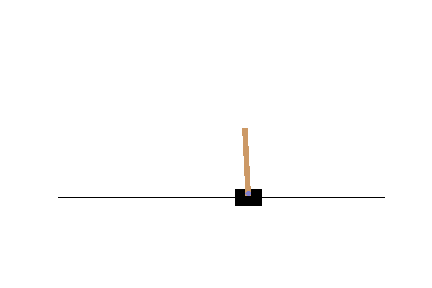
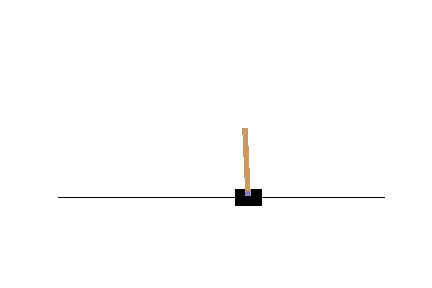
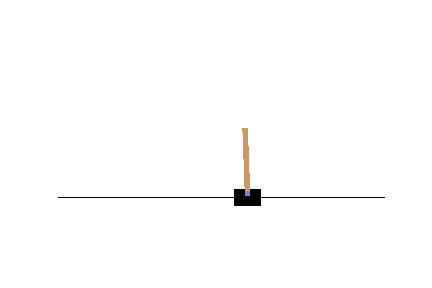
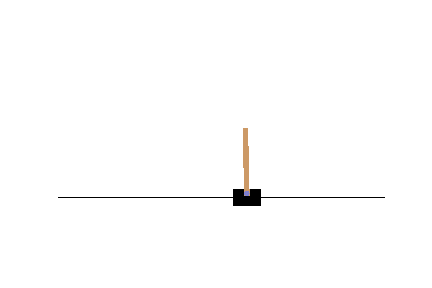
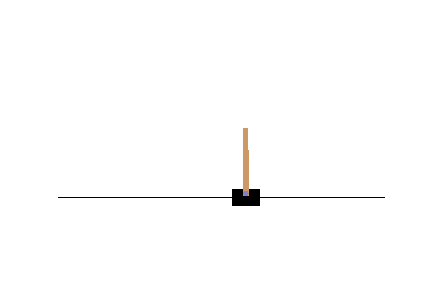
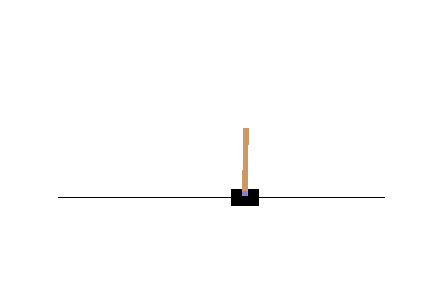
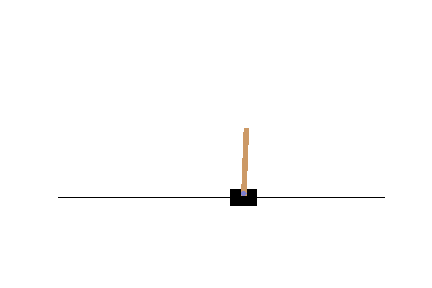
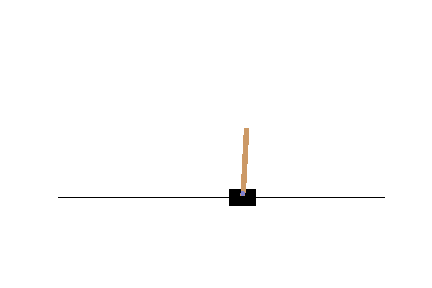
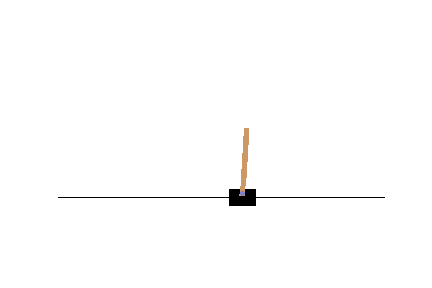
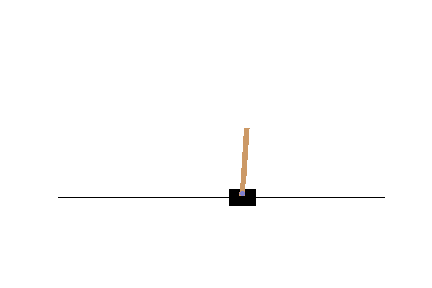
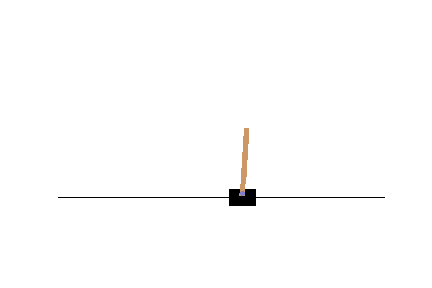
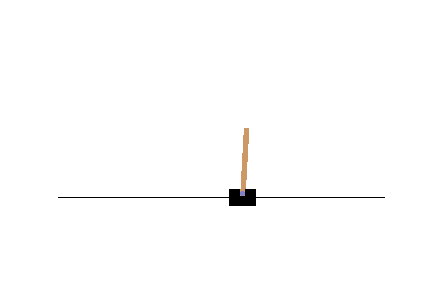
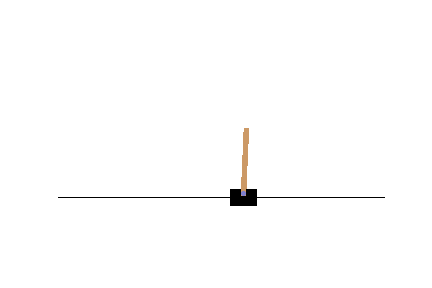
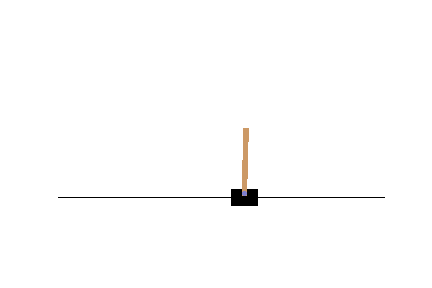
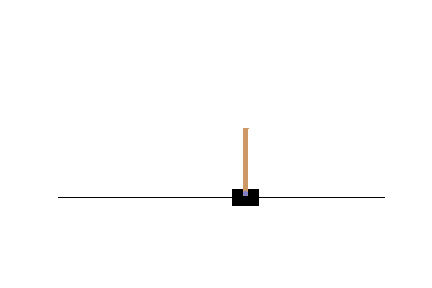
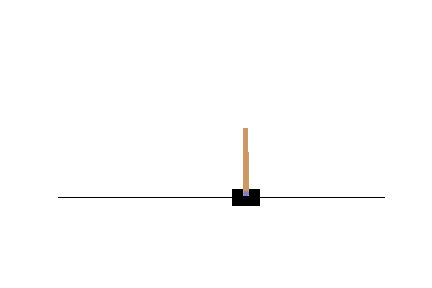
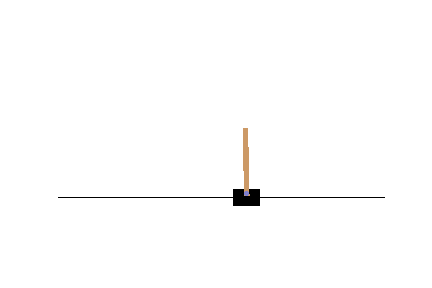
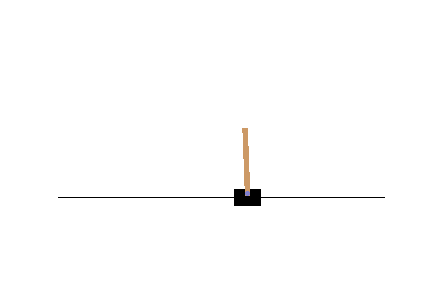
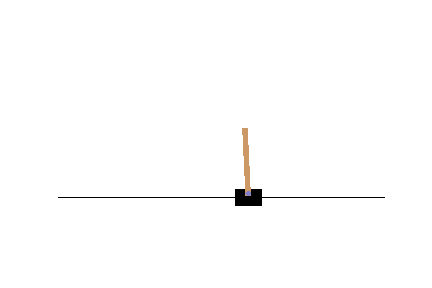
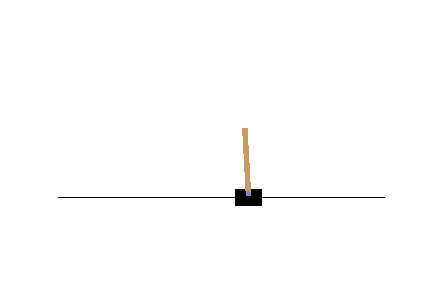
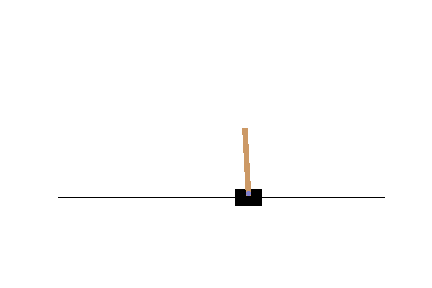
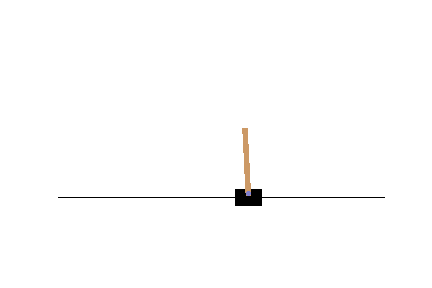
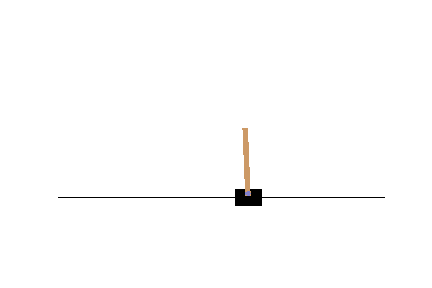
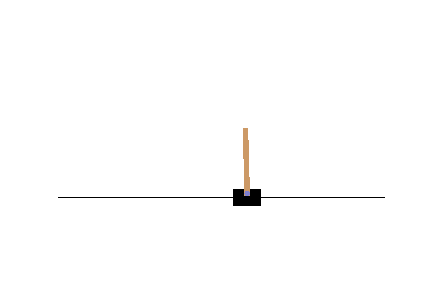
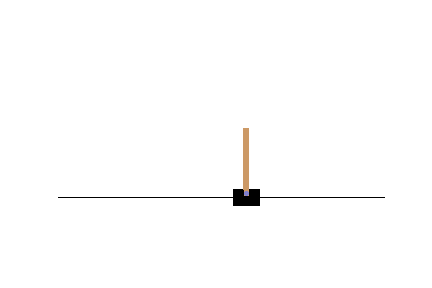
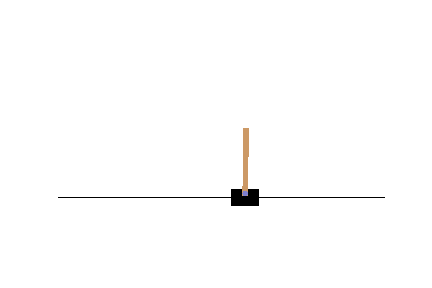
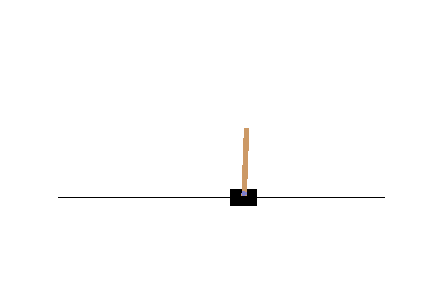
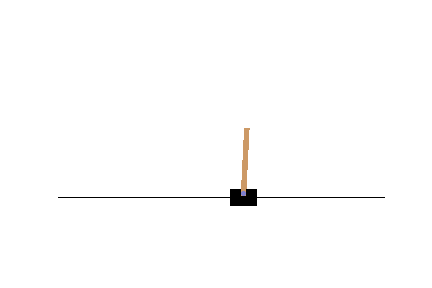
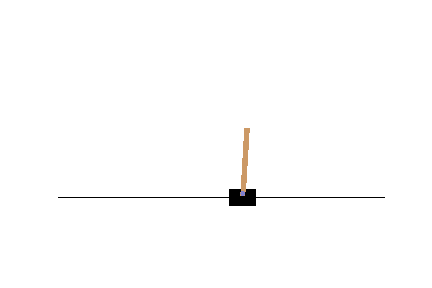
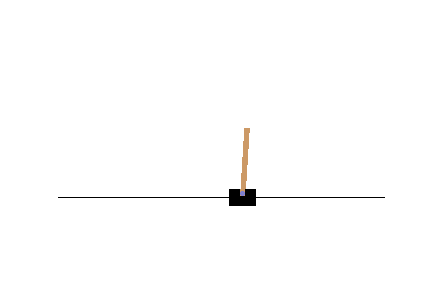
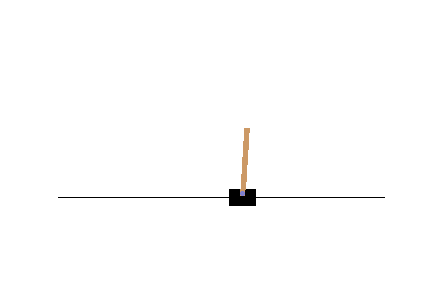
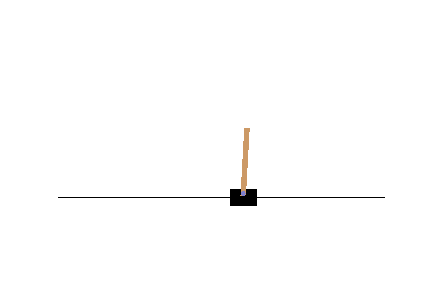
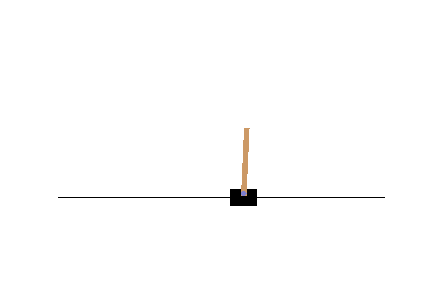
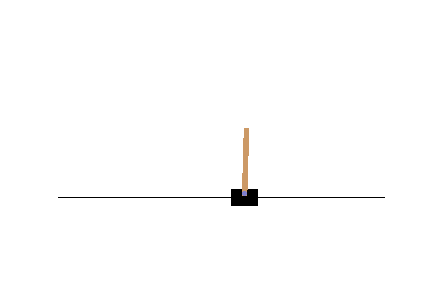
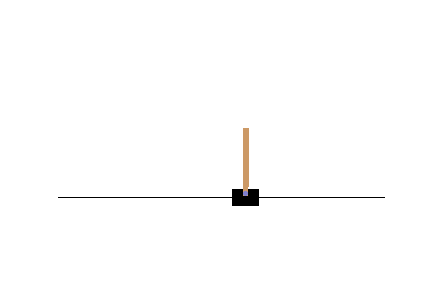
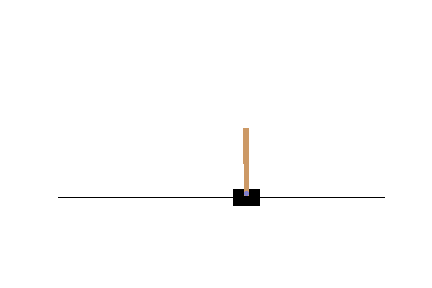
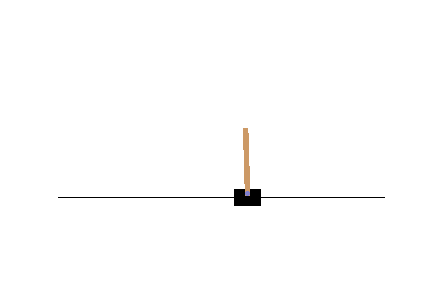
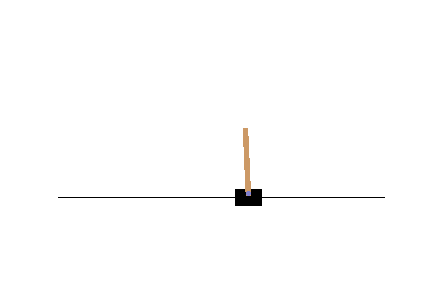
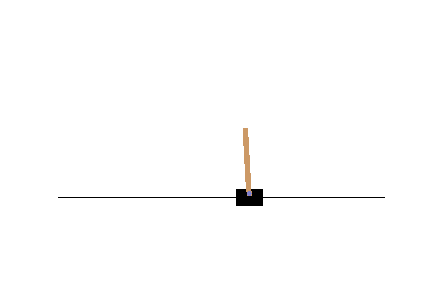
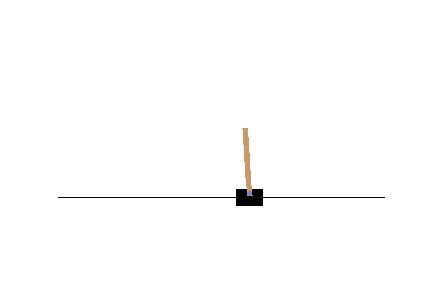
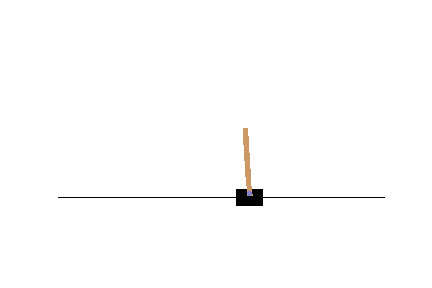
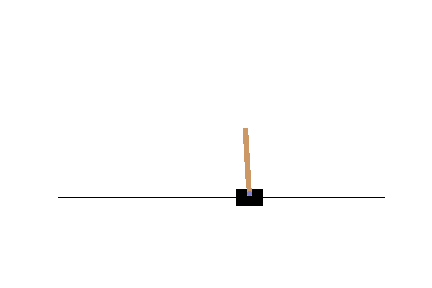
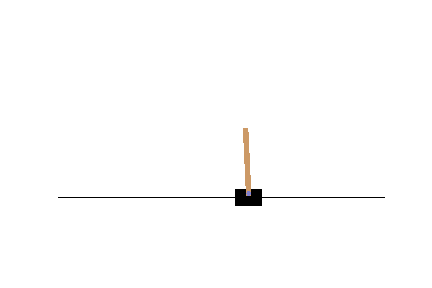
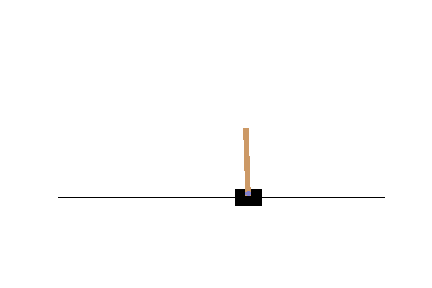
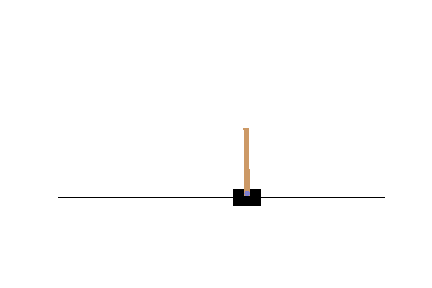
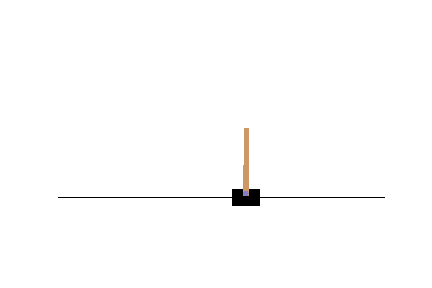
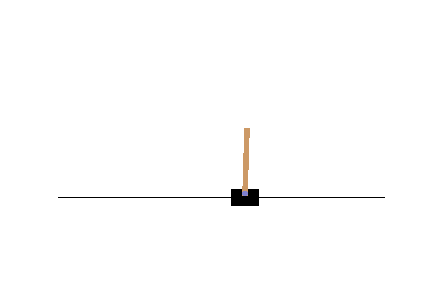
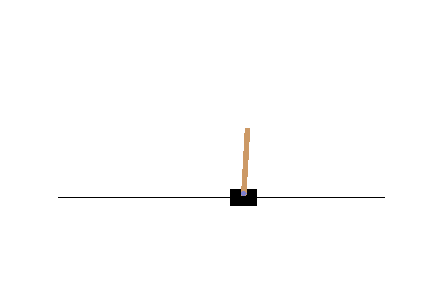
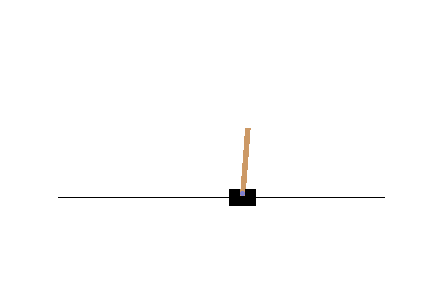
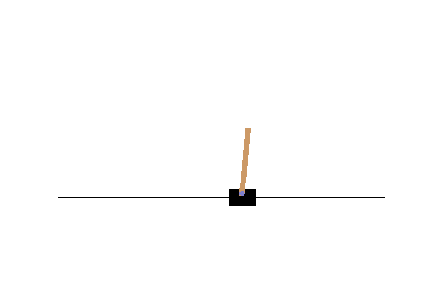
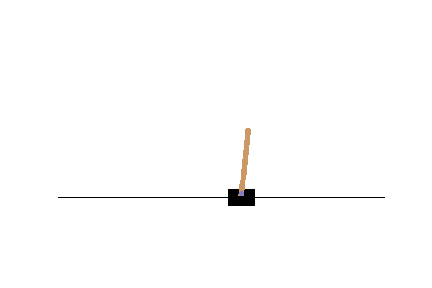
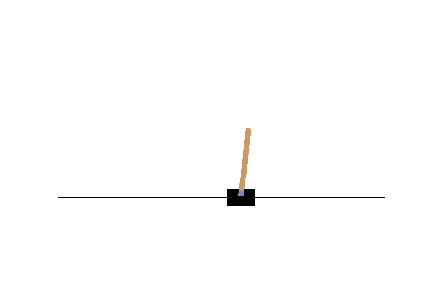
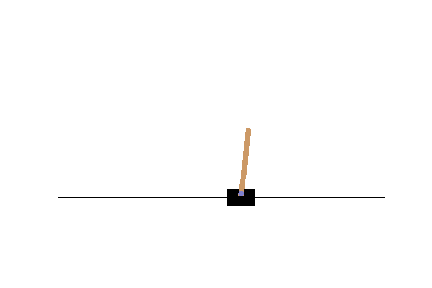
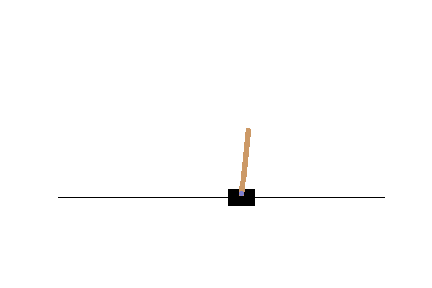
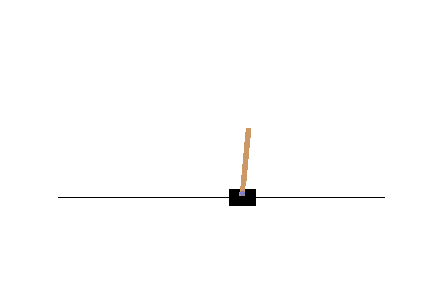
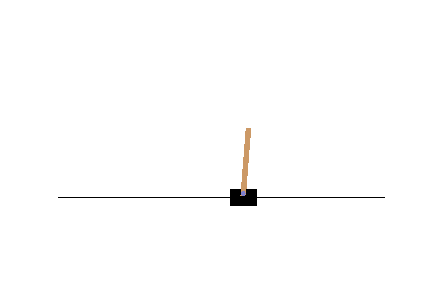
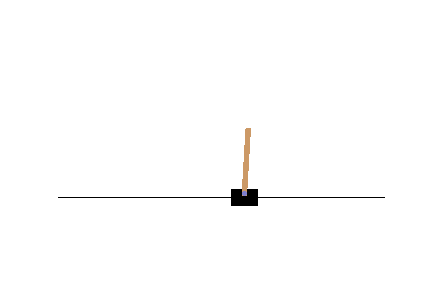
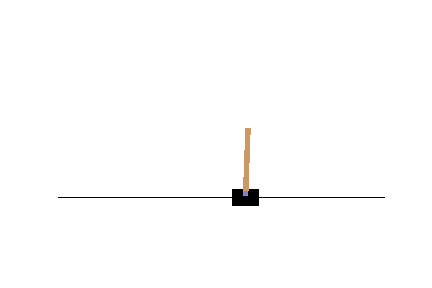
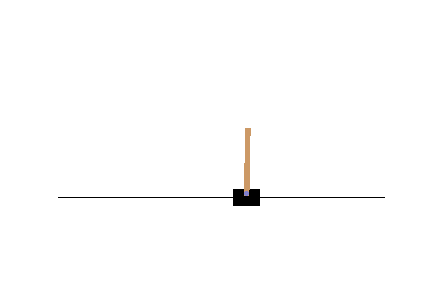
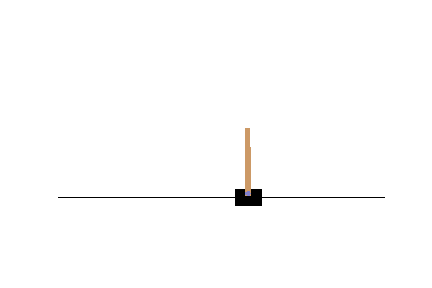
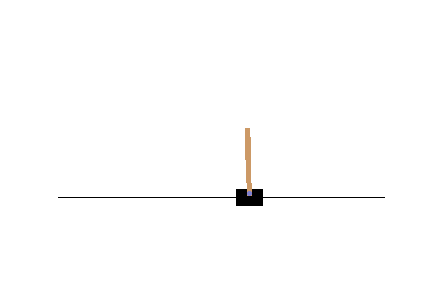
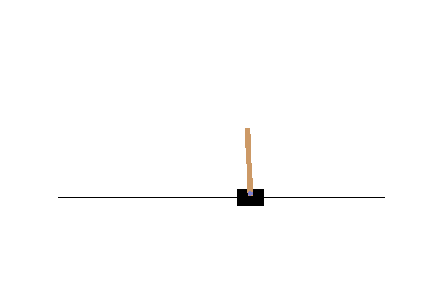
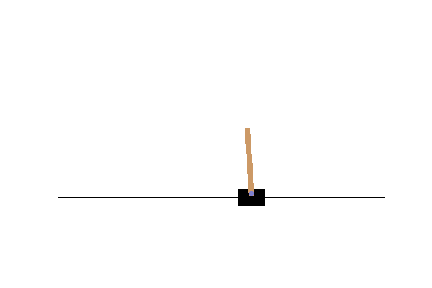
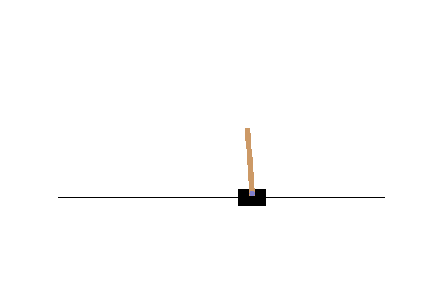
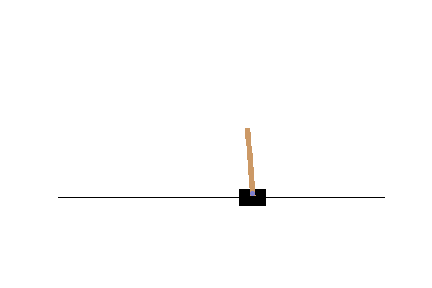
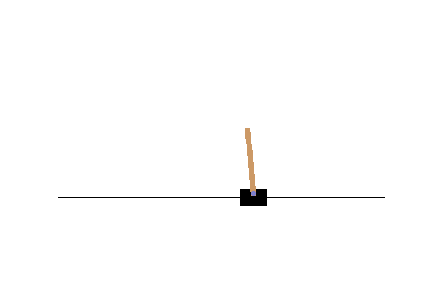
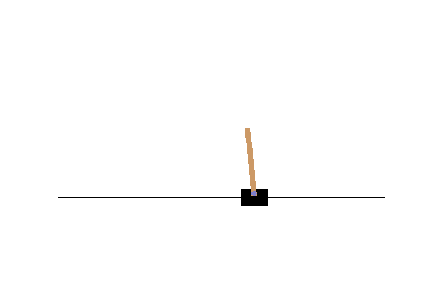
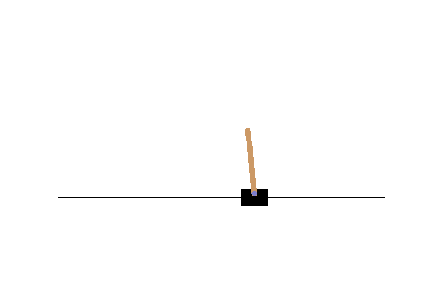
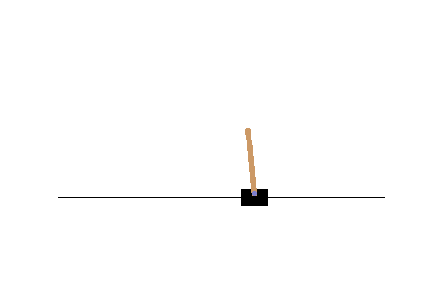
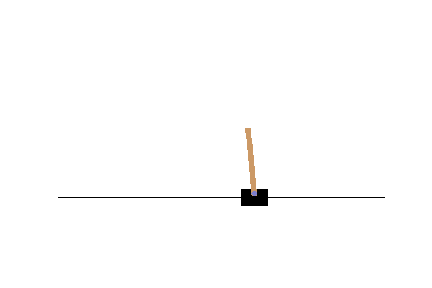
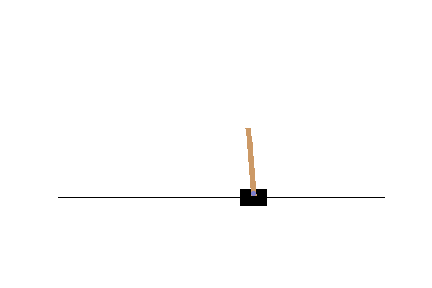
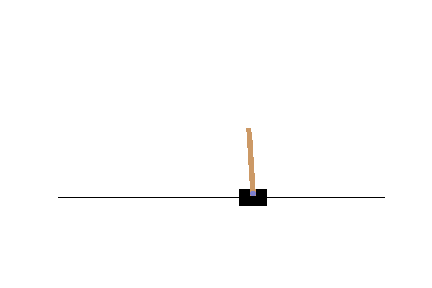
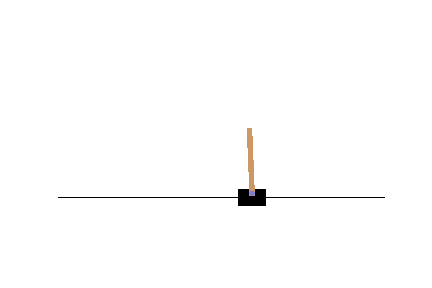
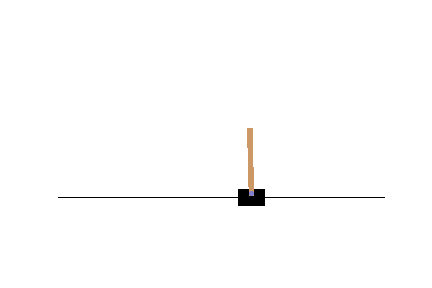
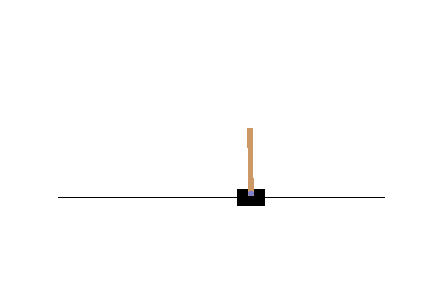
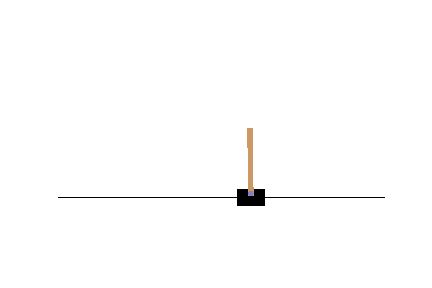
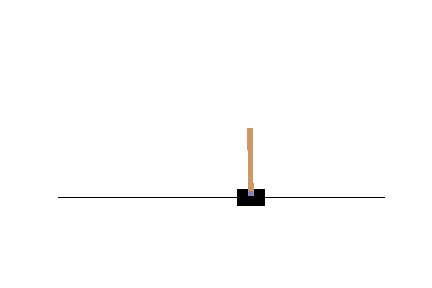
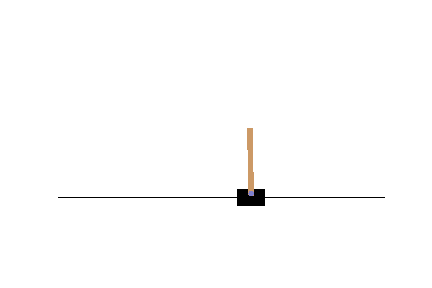
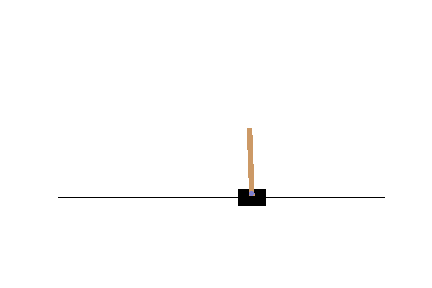
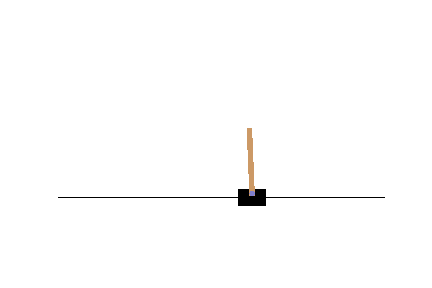
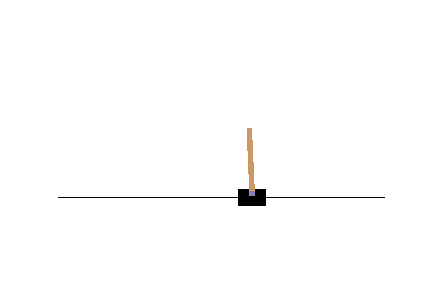
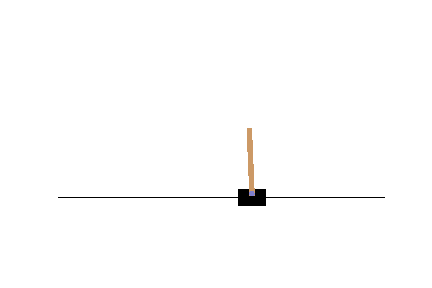
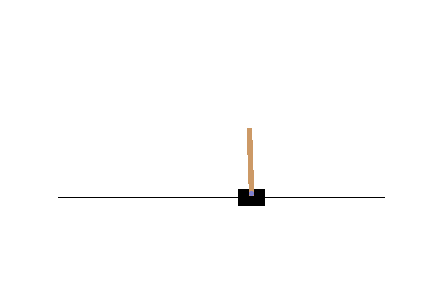
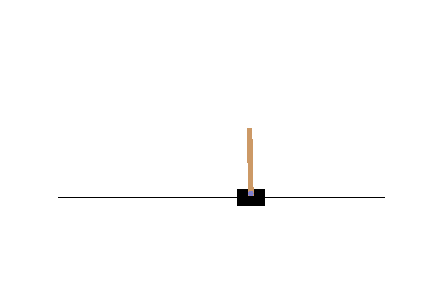
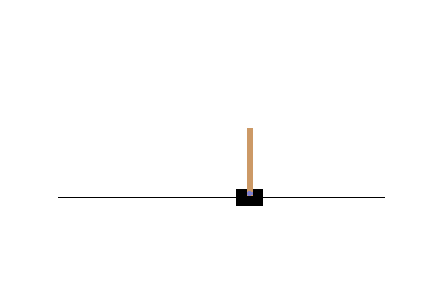
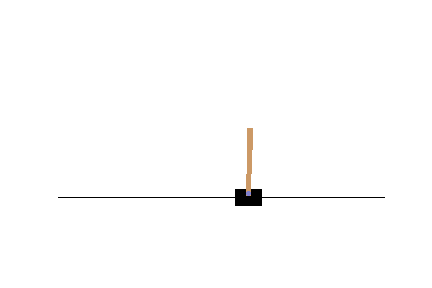
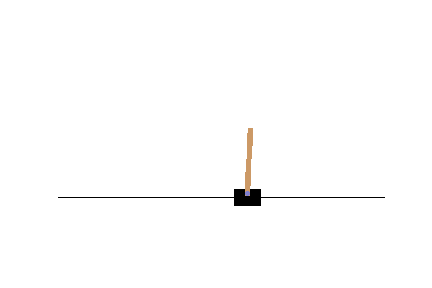
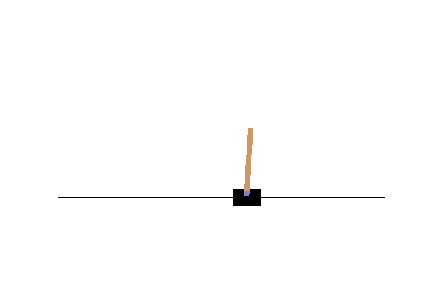
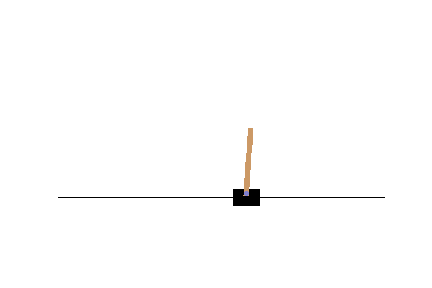
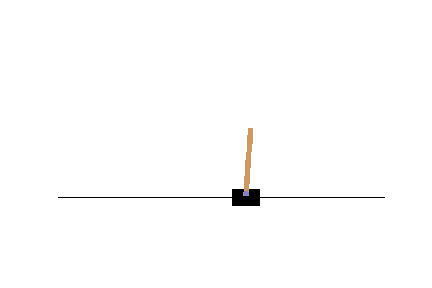
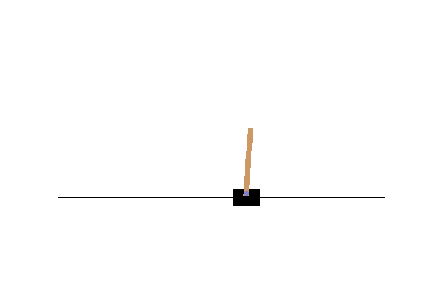
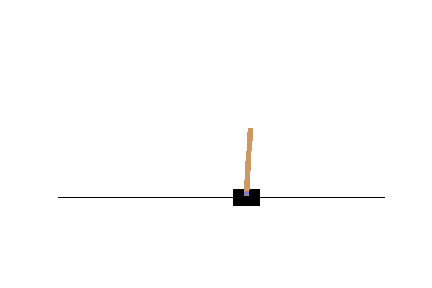
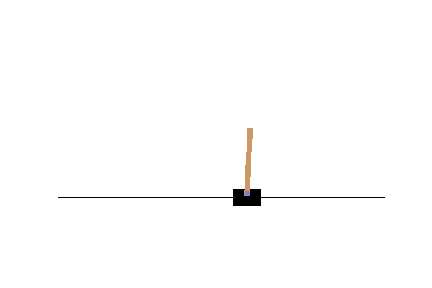
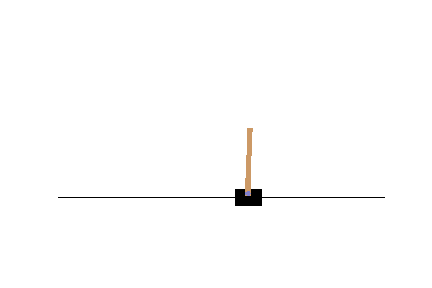
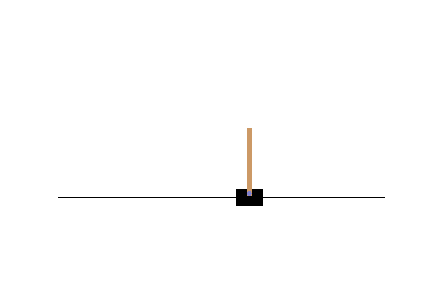
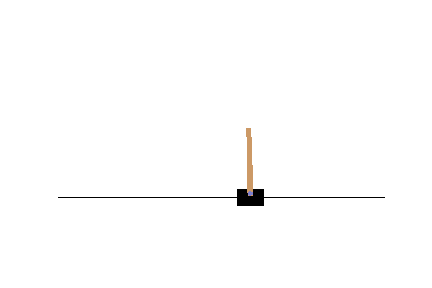
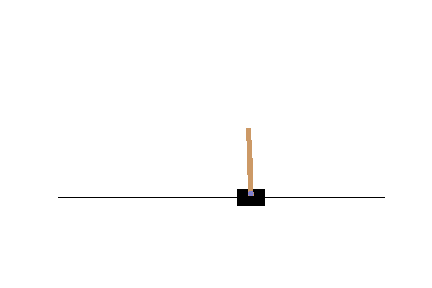
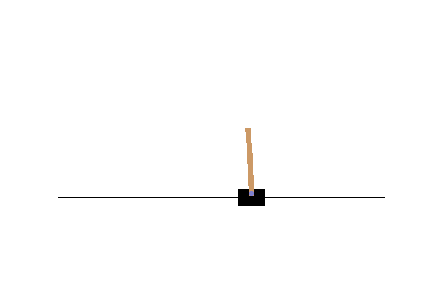
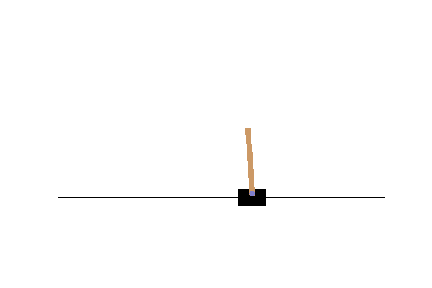
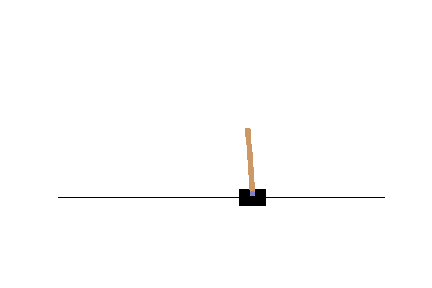
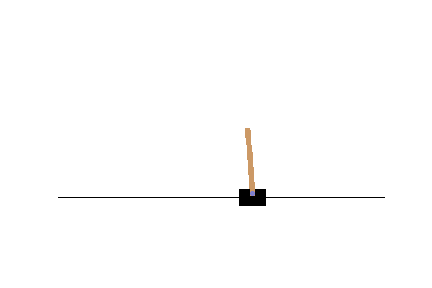
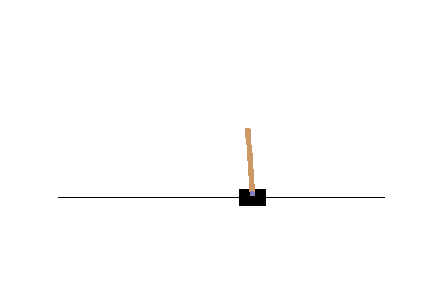
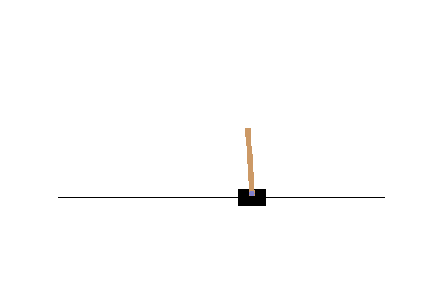
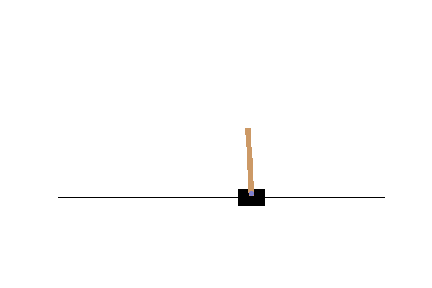
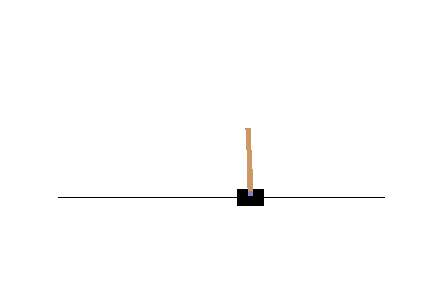
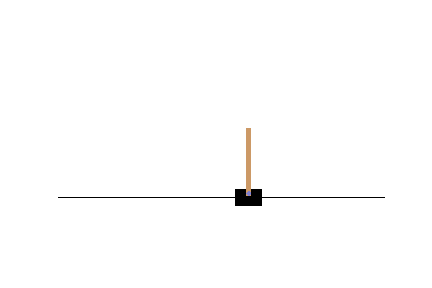
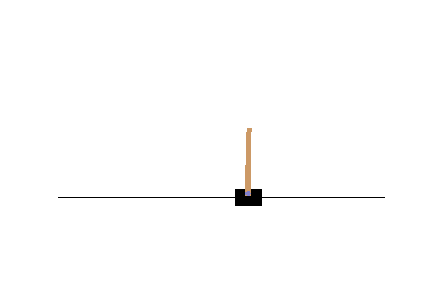
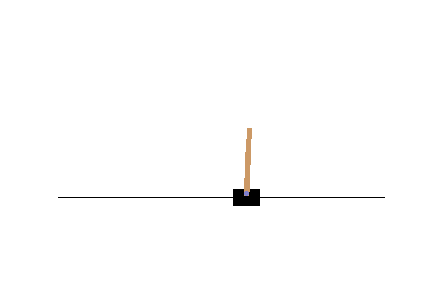
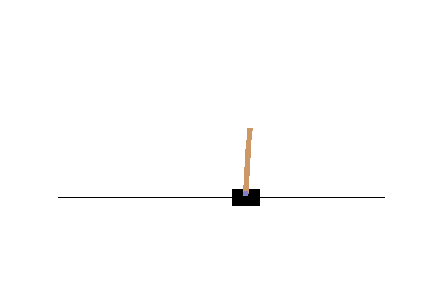
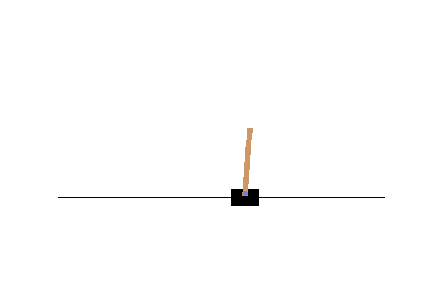
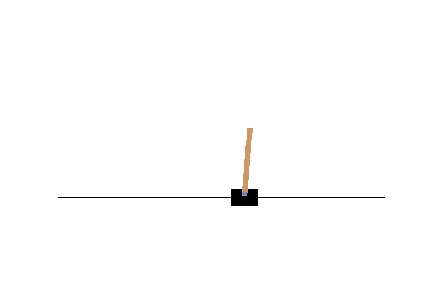
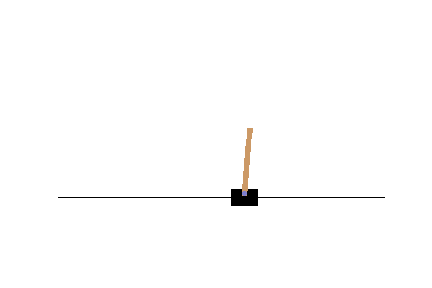
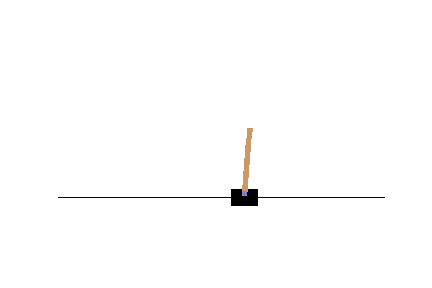
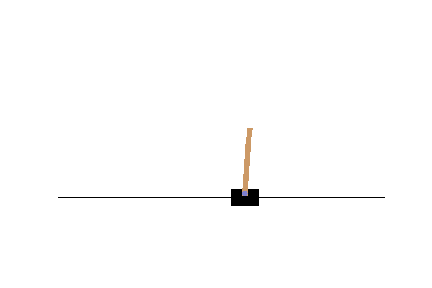
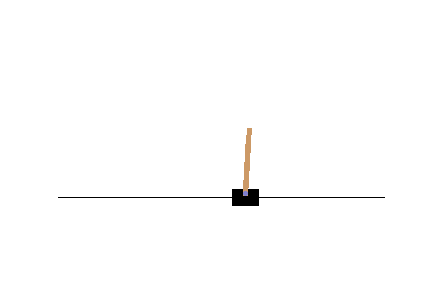
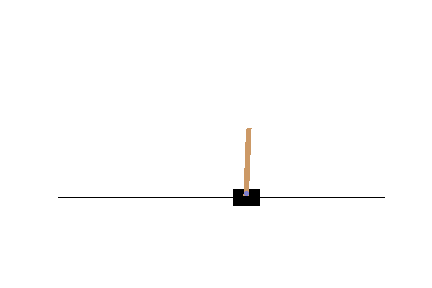
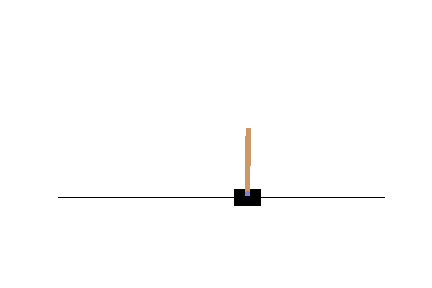
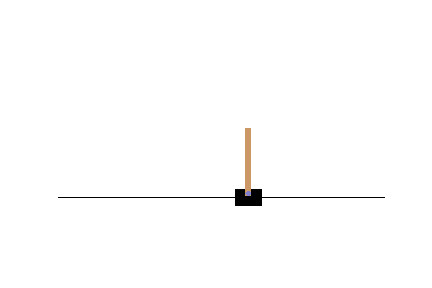
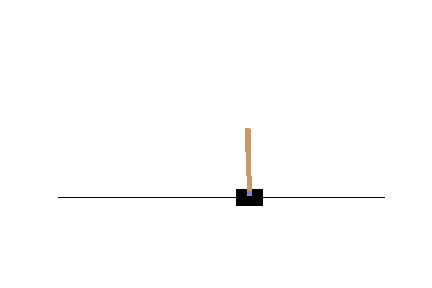
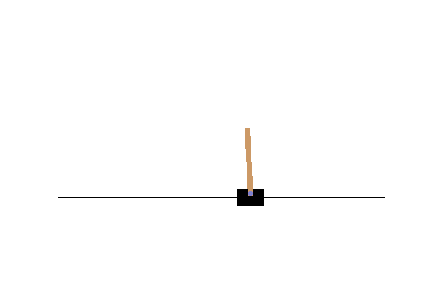
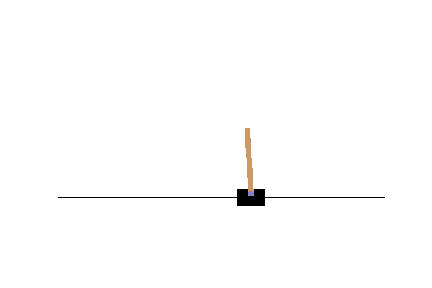
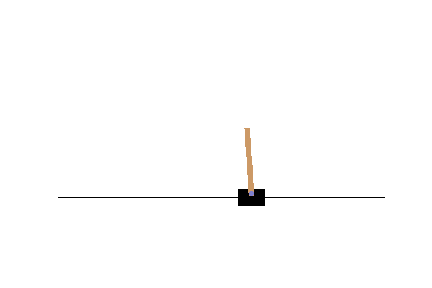
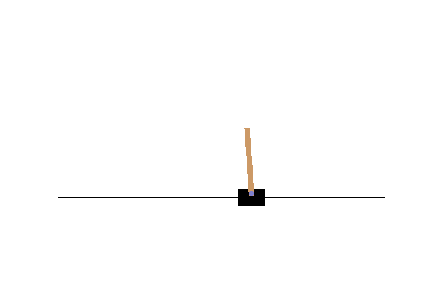
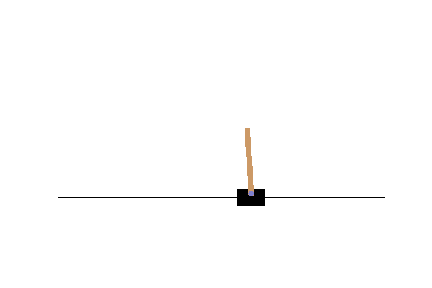
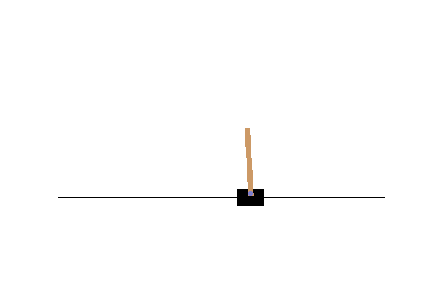
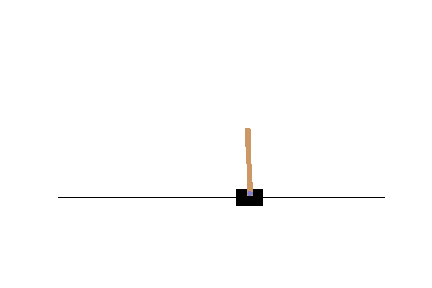
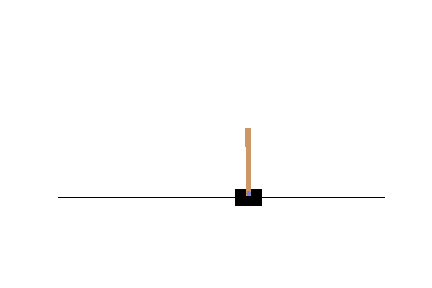

In [7]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)